# Laboratorium 3
Kamil Patan

## Wstęp
Skrypt został stworzony dla lokalnej analizy wrażliwości. 

## Opis
W analizie lokalnej badano wpływ zmian każdego z parametrów modelu na poziom białka p53 w czasie. Zaimplementowano podejście oparte na funkcjach wrażliwości, które opisują pochodną zmiennej stanu względem danego parametru:
S(t) = ∂x(t) / ∂θ
Funkcje wrażliwości zostały obliczone poprzez rozwiązanie układu równań różniczkowych:
dS/dt = (∂f/∂x) · S + ∂f/∂θ
gdzie:
∂f/∂x to macierz Jacobiego względem zmiennych stanu,
∂f/∂θ to pochodna funkcji układu względem badanego parametru.
Wszystkie pochodne cząstkowe wyznaczono numerycznie metodą różnic centralnych. Obliczone wartości zostały dodatkowo znormalizowane, aby umożliwić porównanie wpływu różnych parametrów:
Snorm</sub>(t) = (θ / x(t)) · (∂x(t)/∂θ)

Model rozwiązano numerycznie za pomocą metody Rungego-Kutty 4. rzędu (RK4) w kroku czasowym co 6 minut, w przedziale 48 godzin. Dla każdego scenariusza wykonano analizę osobno dla każdego parametru przy stałych wartościach pozostałych (tzw. podejście „one-at-a-time”).

Dodatkowo dla dwóch wybranych parametrów (o najwyższym i najniższym średnim wpływie) przeprowadzono symulacje dla ±20% zmian wartości, a ich wpływ na poziom p53 przedstawiono graficznie.

Analiza została wykonana dla dwóch scenariuszy:
Healthy – komórki zdrowe (brak uszkodzeń DNA),
Tumor – komórki nowotworowe (PTEN wyłączony).
## Skrypt

In [ ]:
# Import wymaganych bibliotek
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from copy import deepcopy

# Utworzenie folderu do zapisu wykresów, jeśli nie istnieje
os.makedirs("wykresy", exist_ok=True)

# Słownik z parametrami modelu biologicznego
params = {
    'p1': 8.8,      # produkcja p53
    'p2': 440,      # produkcja MDM2 (cytoplazmatycznego)
    'p3': 100,      # produkcja PTEN
    'd1': 1.375e-14, # degradacja p53 (zależna od MDM2)
    'd2': 1.375e-4,  # degradacja MDM2 (cyto i jądro)
    'd3': 3e-5,      # degradacja PTEN
    'k1': 1.925e-4,  # transport MDM2 do jądra
    'k2': 1e5,       # stała nasycenia dla p53
    'k3': 1.5e5,     # stała nasycenia dla PTEN
}

# Wartości początkowe: p53, mdm2_cyto, mdm2_nuclear, pten
proteins = [26854, 11173, 17245, 154378]

# Krok czasowy i liczba kroków do 48 godzin symulacji (co 6 minut)
h = 6
iterations = int(48 * 60 / h)

# Zdefiniowane scenariusze biologiczne
scenarios = {
    "Basic": (False, False, False),   # kontrola
    "Tumor": (False, True, False)     # nowotwor
}

# Funkcja opisująca zmiany stężenia p53
def f_p53(params, p53, mdmn):
    return params['p1'] - params['d1'] * p53 * (mdmn ** 2)

# Funkcja dla MDM2 w cytoplazmie
def f_mdmcyto(params, p53, mdmcyto, pten):
    return (params['p2'] * (p53 ** 4) / ((p53 ** 4) + (params['k2'] ** 4))
            - params['k1'] * (params['k3'] ** 2) / ((params['k3'] ** 2) + (pten ** 2)) * mdmcyto
            - params['d2'] * mdmcyto)

# Funkcja dla MDM2 w jądrze
def f_mdmn(params, mdmn, mdmcyto, pten):
    return (params['k1'] * (params['k3'] ** 2) / ((params['k3'] ** 2) + (pten ** 2)) * mdmcyto
            - params['d2'] * mdmn)

# Funkcja opisująca zmiany stężenia PTEN
def f_pten(params, pten, p53):
    return (params['p3'] * (p53 ** 4) / ((p53 ** 4) + (params['k2'] ** 4)) - params['d3'] * pten)

# Implementacja metody RK4 dla układu ODE i zwrot tylko p53
def RK4(params, proteins, iterations, h):
    x = np.array(proteins, dtype=float)
    t_values = []
    x_values = []
    for i in range(iterations):
        t = i * h
        t_values.append(t)
        x_values.append(x[0])  # zapisujemy tylko poziom p53

        def f_all(x):
            return np.array([
                f_p53(params, x[0], x[2]),
                f_mdmcyto(params, x[0], x[1], x[3]),
                f_mdmn(params, x[2], x[1], x[3]),
                f_pten(params, x[3], x[0])
            ])

        k1 = f_all(x)
        k2 = f_all(x + h / 2 * k1)
        k3 = f_all(x + h / 2 * k2)
        k4 = f_all(x + h * k3)

        x += h * (k1 + 2*k2 + 2*k3 + k4) / 6

    return np.array(t_values), np.array(x_values)

# Obliczanie funkcji wrażliwości lokalnej dla wszystkich parametrów
# Zwracane są znormalizowane pochodne ∂p53/∂parametr

def RK4_sensitivity(params, proteins, param_keys, h, iterations):
    results = {k: [] for k in param_keys}
    t_values = []
    for i in range(iterations):
        t = i * h
        t_values.append(t)

        for param_key in param_keys:
            x = np.array(proteins, dtype=float)
            s = np.zeros_like(x)  # wektor wrażliwości ∂x/∂θ

            def f_all(x):
                return np.array([
                    f_p53(params, x[0], x[2]),
                    f_mdmcyto(params, x[0], x[1], x[3]),
                    f_mdmn(params, x[2], x[1], x[3]),
                    f_pten(params, x[3], x[0])
                ])

            def df_dx(x):  # Jacobian ∂f/∂x
                eps = 1e-6
                J = np.zeros((4, 4))
                for j in range(4):
                    dx = np.zeros(4)
                    dx[j] = eps
                    J[:, j] = (f_all(x + dx) - f_all(x - dx)) / (2 * eps)
                return J

            def df_dp(x):  # pochodna ∂f/∂θ
                eps = 1e-6
                p_orig = params[param_key]
                params[param_key] = p_orig + eps
                f_plus = f_all(x)
                params[param_key] = p_orig - eps
                f_minus = f_all(x)
                params[param_key] = p_orig
                return (f_plus - f_minus) / (2 * eps)

            # Obliczanie wartości wrażliwości RK4
            f1 = f_all(x)
            J1 = df_dx(x)
            dp1 = df_dp(x)
            s1 = J1 @ s + dp1

            f2 = f_all(x + h / 2 * f1)
            J2 = df_dx(x + h / 2 * f1)
            dp2 = df_dp(x + h / 2 * f1)
            s2 = J2 @ (s + h / 2 * s1) + dp2

            f3 = f_all(x + h / 2 * f2)
            J3 = df_dx(x + h / 2 * f2)
            dp3 = df_dp(x + h / 2 * f2)
            s3 = J3 @ (s + h / 2 * s2) + dp3

            f4 = f_all(x + h * f3)
            J4 = df_dx(x + h * f3)
            dp4 = df_dp(x + h * f3)
            s4 = J4 @ (s + h * s3) + dp4

            s += h * (s1 + 2*s2 + 2*s3 + s4) / 6
            results[param_key].append((params[param_key] / x[0]) * s[0])  # normalizacja

    return np.array(t_values), results

# Funkcja rysująca wykresy dla ±20% zmian wybranych parametrów

def perturb_param_and_plot(params, proteins, scenario_name):
    top = 'p1'
    bottom = 'p3'
    base_t, base_p53 = RK4(params, proteins, iterations, h)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, param_key in zip(axes, [top, bottom]):
        ax.plot(base_t, base_p53, label='Brak zmian')
        for change, color in [(+0.2, 'orange'), (-0.2, 'green')]:
            mod_params = deepcopy(params)
            mod_params[param_key] *= (1 + change)
            t_mod, p53_mod = RK4(mod_params, proteins, iterations, h)
            ax.plot(t_mod, p53_mod, label=f'{"zwiększenie" if change > 0 else "zmniejszenie"} o {int(abs(change)*100)}%', color=color)
        ax.set_title(f'Parametr: {param_key}')
        ax.set_xlabel("Czas [min]")
        ax.set_ylabel("Liczba cząsteczek")
        ax.grid()
        ax.legend()

    fig.suptitle(f'Zmiana poziomu p53 przy różnych perturbacjach, scenariusz: {scenario_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"wykresy/perturbacje_{scenario_name}.png", dpi=300)
    plt.close()

# Obliczanie rankingów i generowanie wykresów dla wszystkich scenariuszy
ranking_mean_all = pd.DataFrame()
ranking_final_all = pd.DataFrame()

for scenario_name, scenario_flags in scenarios.items():
    perturb_param_and_plot(params, proteins, scenario_name)

    t, results = RK4_sensitivity(params, proteins, list(params.keys()), h, iterations)
    df = pd.DataFrame(results, index=t)
    df.to_csv(f"ranking_sensfunc_{scenario_name}.csv")

    # Obliczenie średnich i końcowych wartości wrażliwości
    mean_ranking = df.abs().mean().rename(scenario_name)
    final_ranking = df.iloc[-1].abs().rename(scenario_name)

    ranking_mean_all = pd.concat([ranking_mean_all, mean_ranking], axis=1)
    ranking_final_all = pd.concat([ranking_final_all, final_ranking], axis=1)

    # Wykres funkcji wrażliwości
    plt.figure(figsize=(10, 5))
    for k in df.columns:
        plt.plot(df.index, df[k], label=f"Sensitivity to {k}")
    plt.xlabel("Czas [min]")
    plt.ylabel("Wrażliwość")
    plt.title(f"Lokalna wrażliwość p53 od parametrów, scenariusz: {scenario_name}")
    plt.grid()
    plt.legend()
    plt.savefig(f"wykresy/wrazliwosc_{scenario_name}.png", dpi=300)
    plt.close()

# Zapis końcowych rankingów
ranking_mean_all.to_csv("ranking_sredni.csv")
ranking_final_all.to_csv("ranking_koncowy.csv")
print("Wykresy i rankingi gotowe.")


Matplotlib is building the font cache; this may take a moment.


## Wykresy
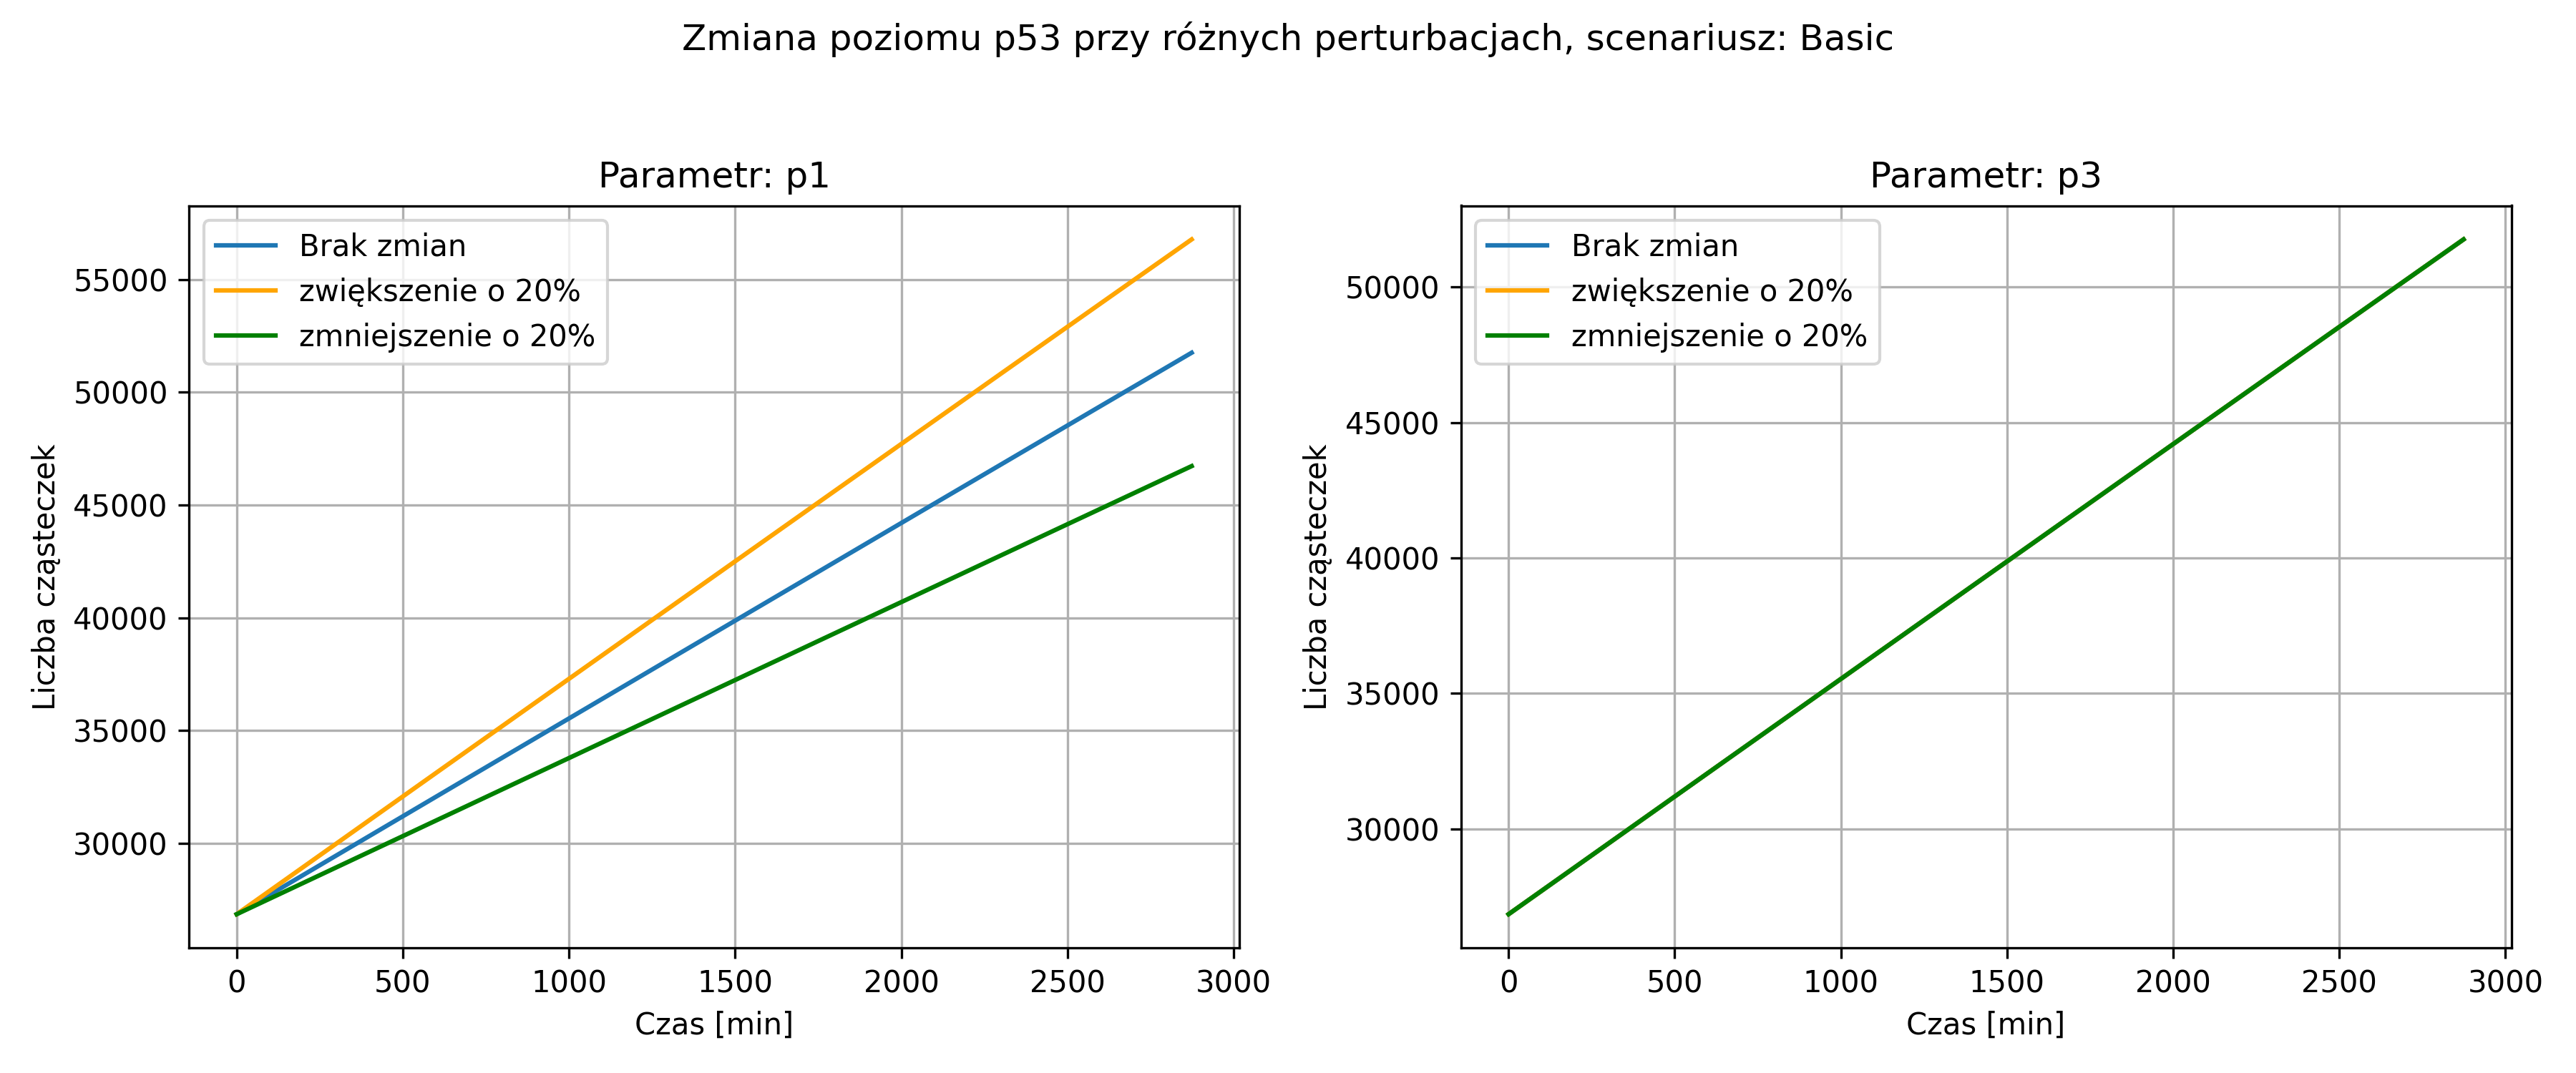
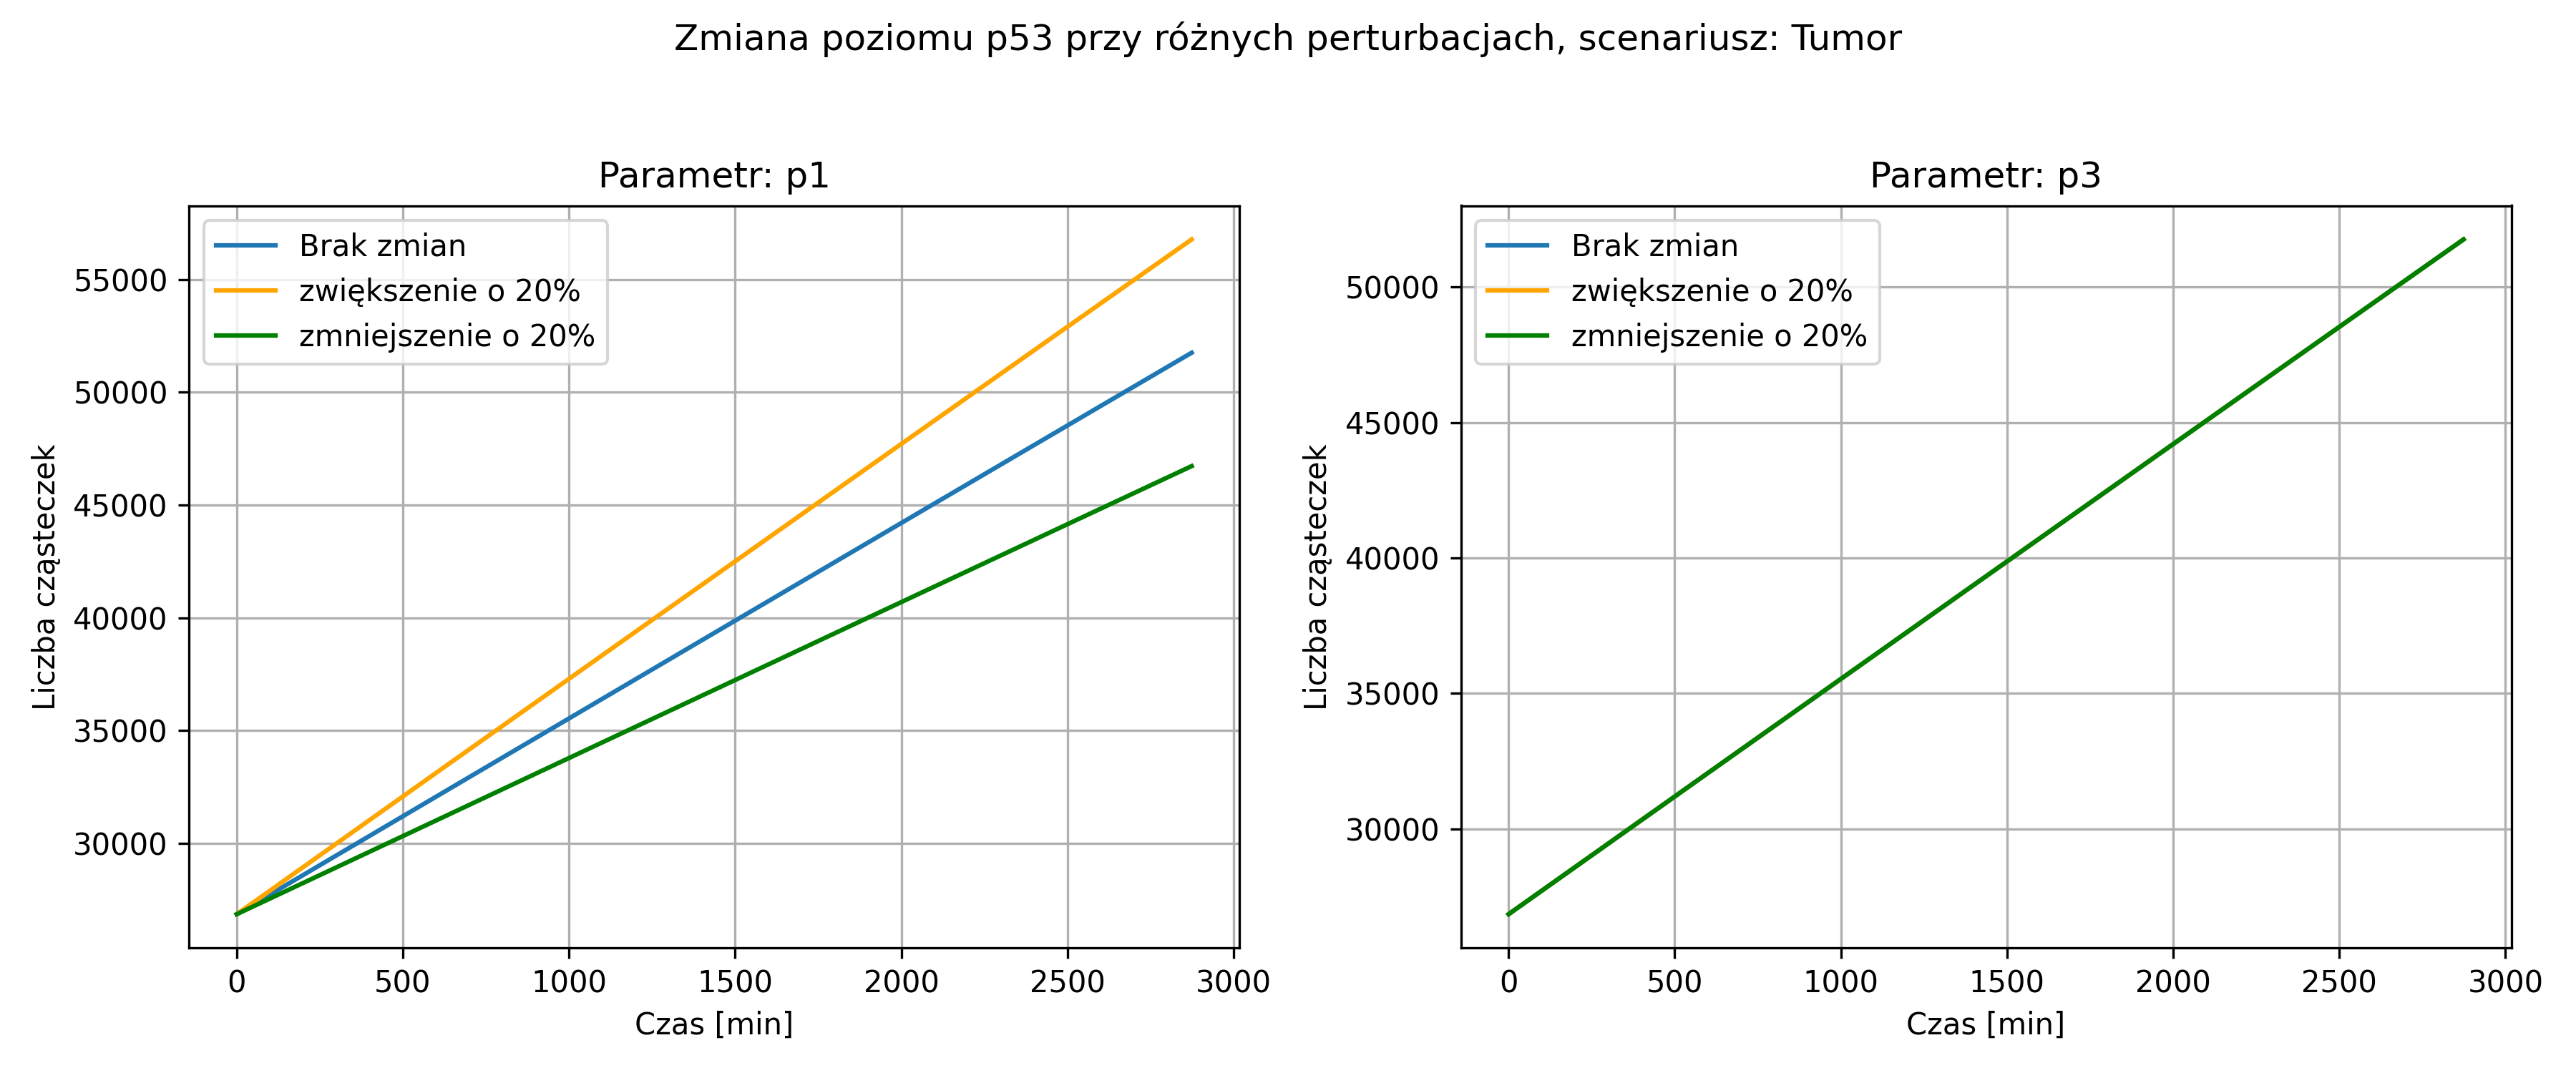
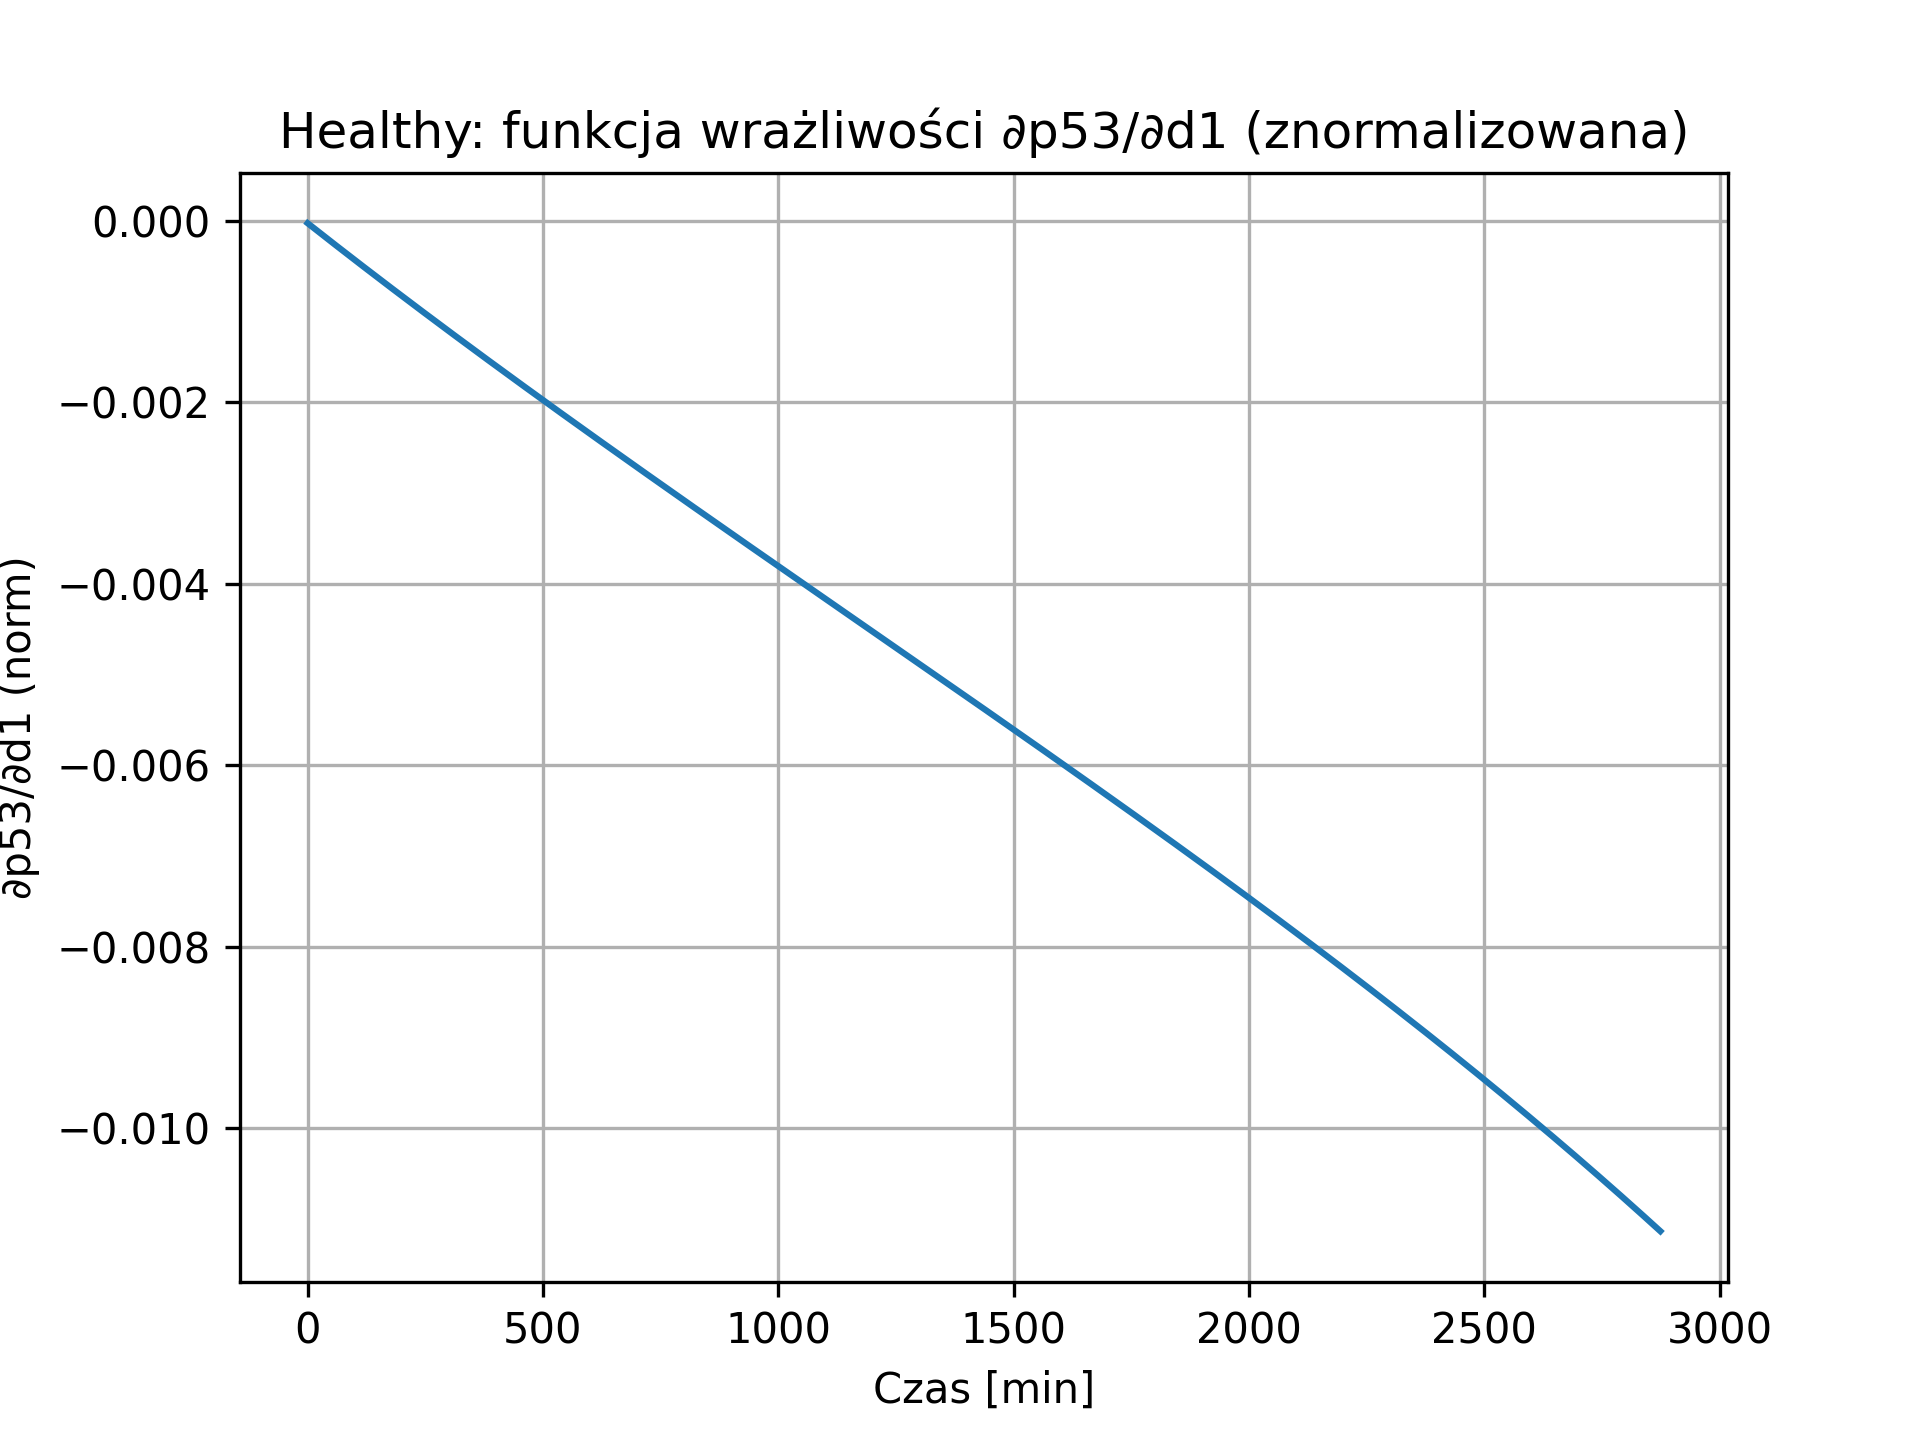
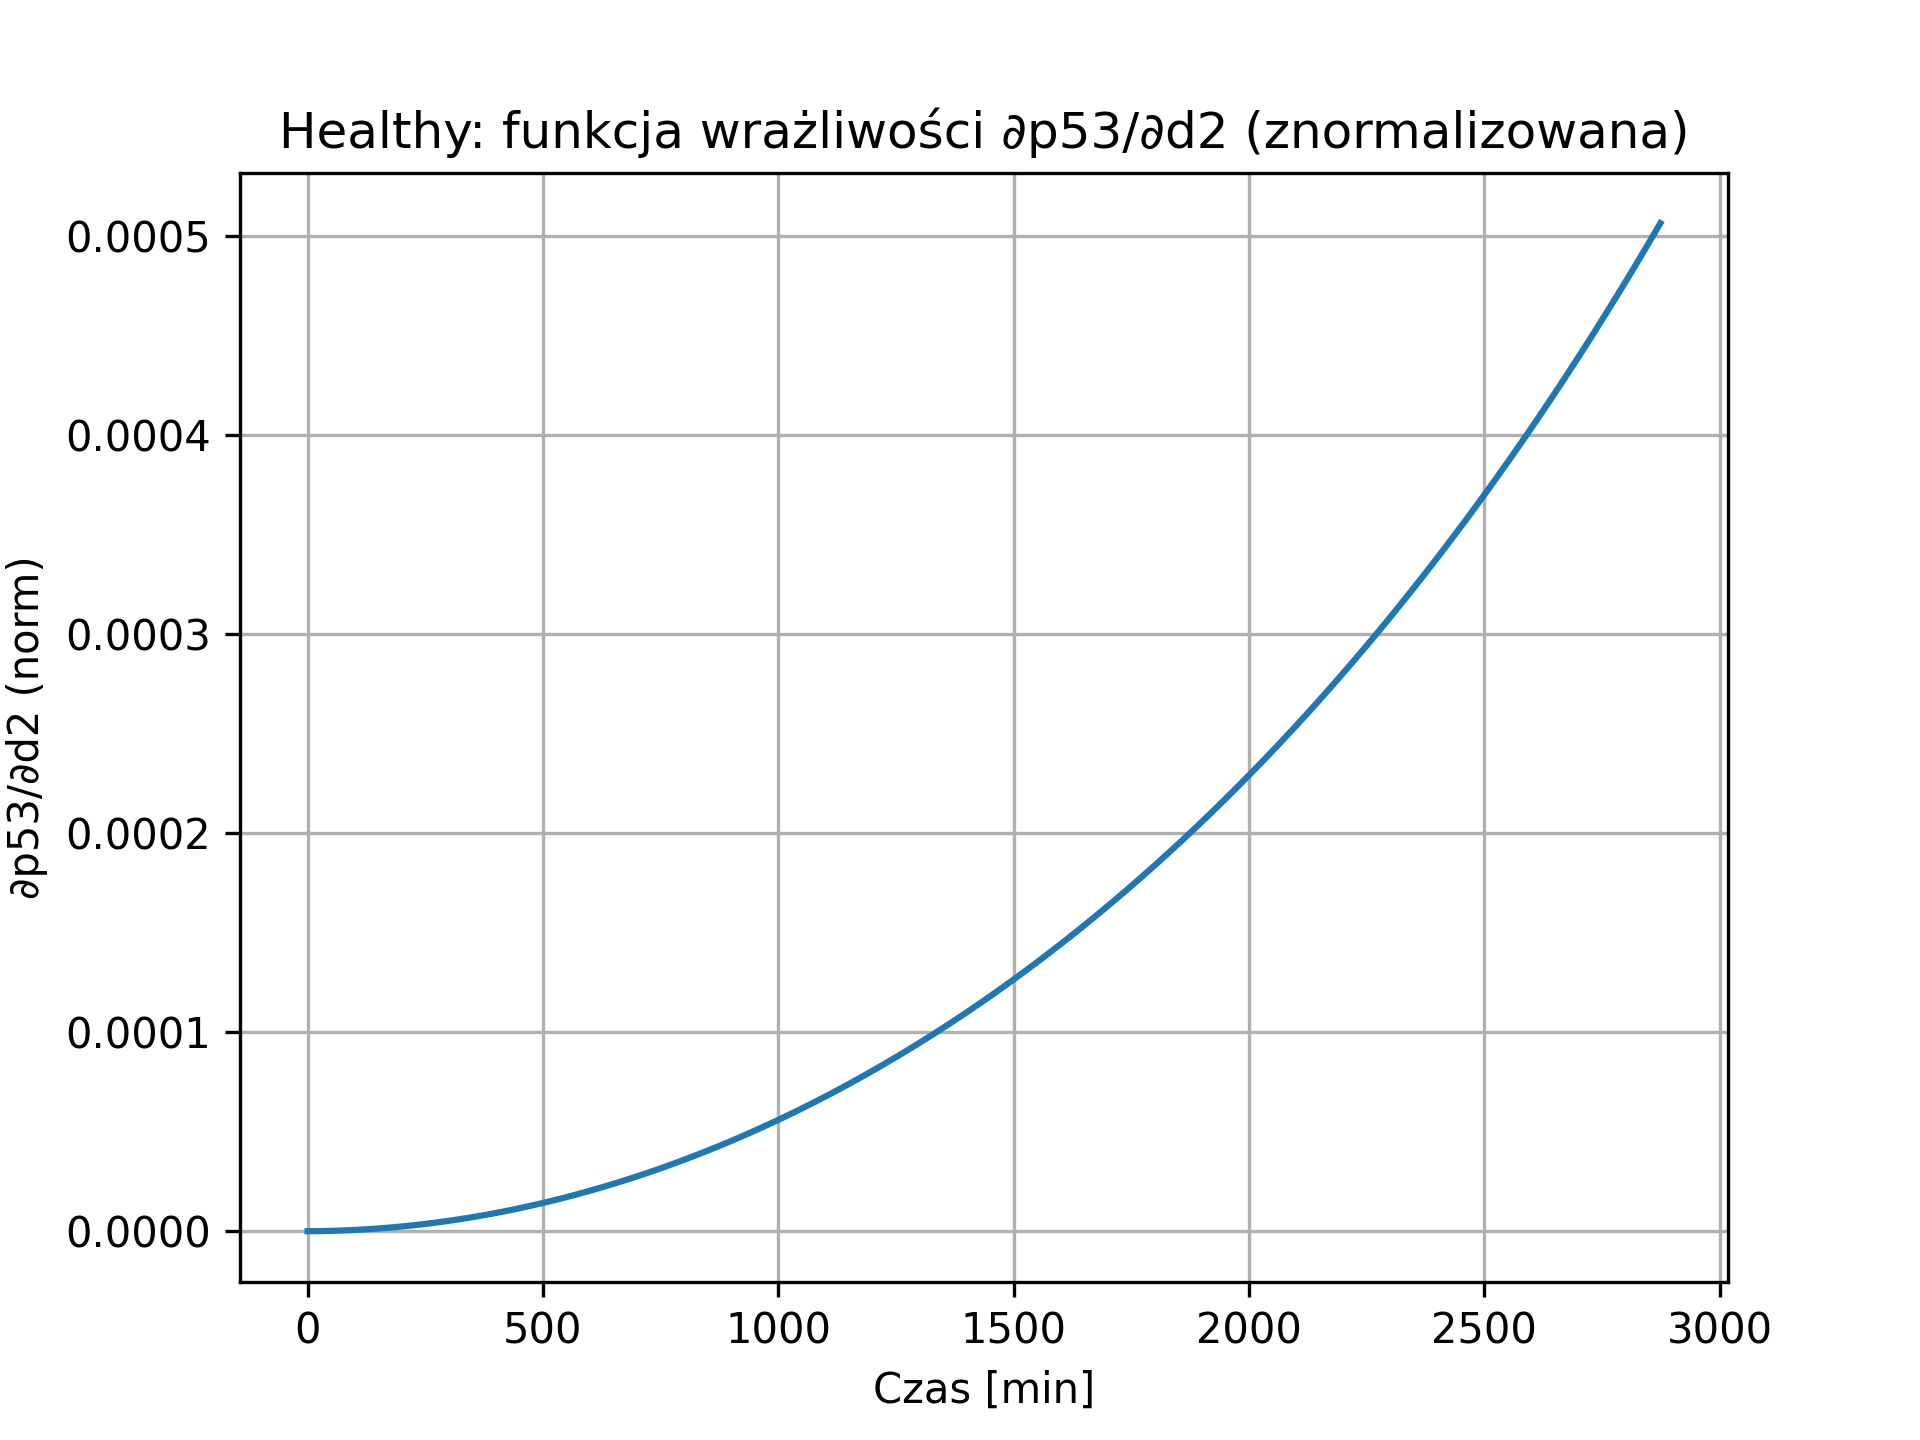
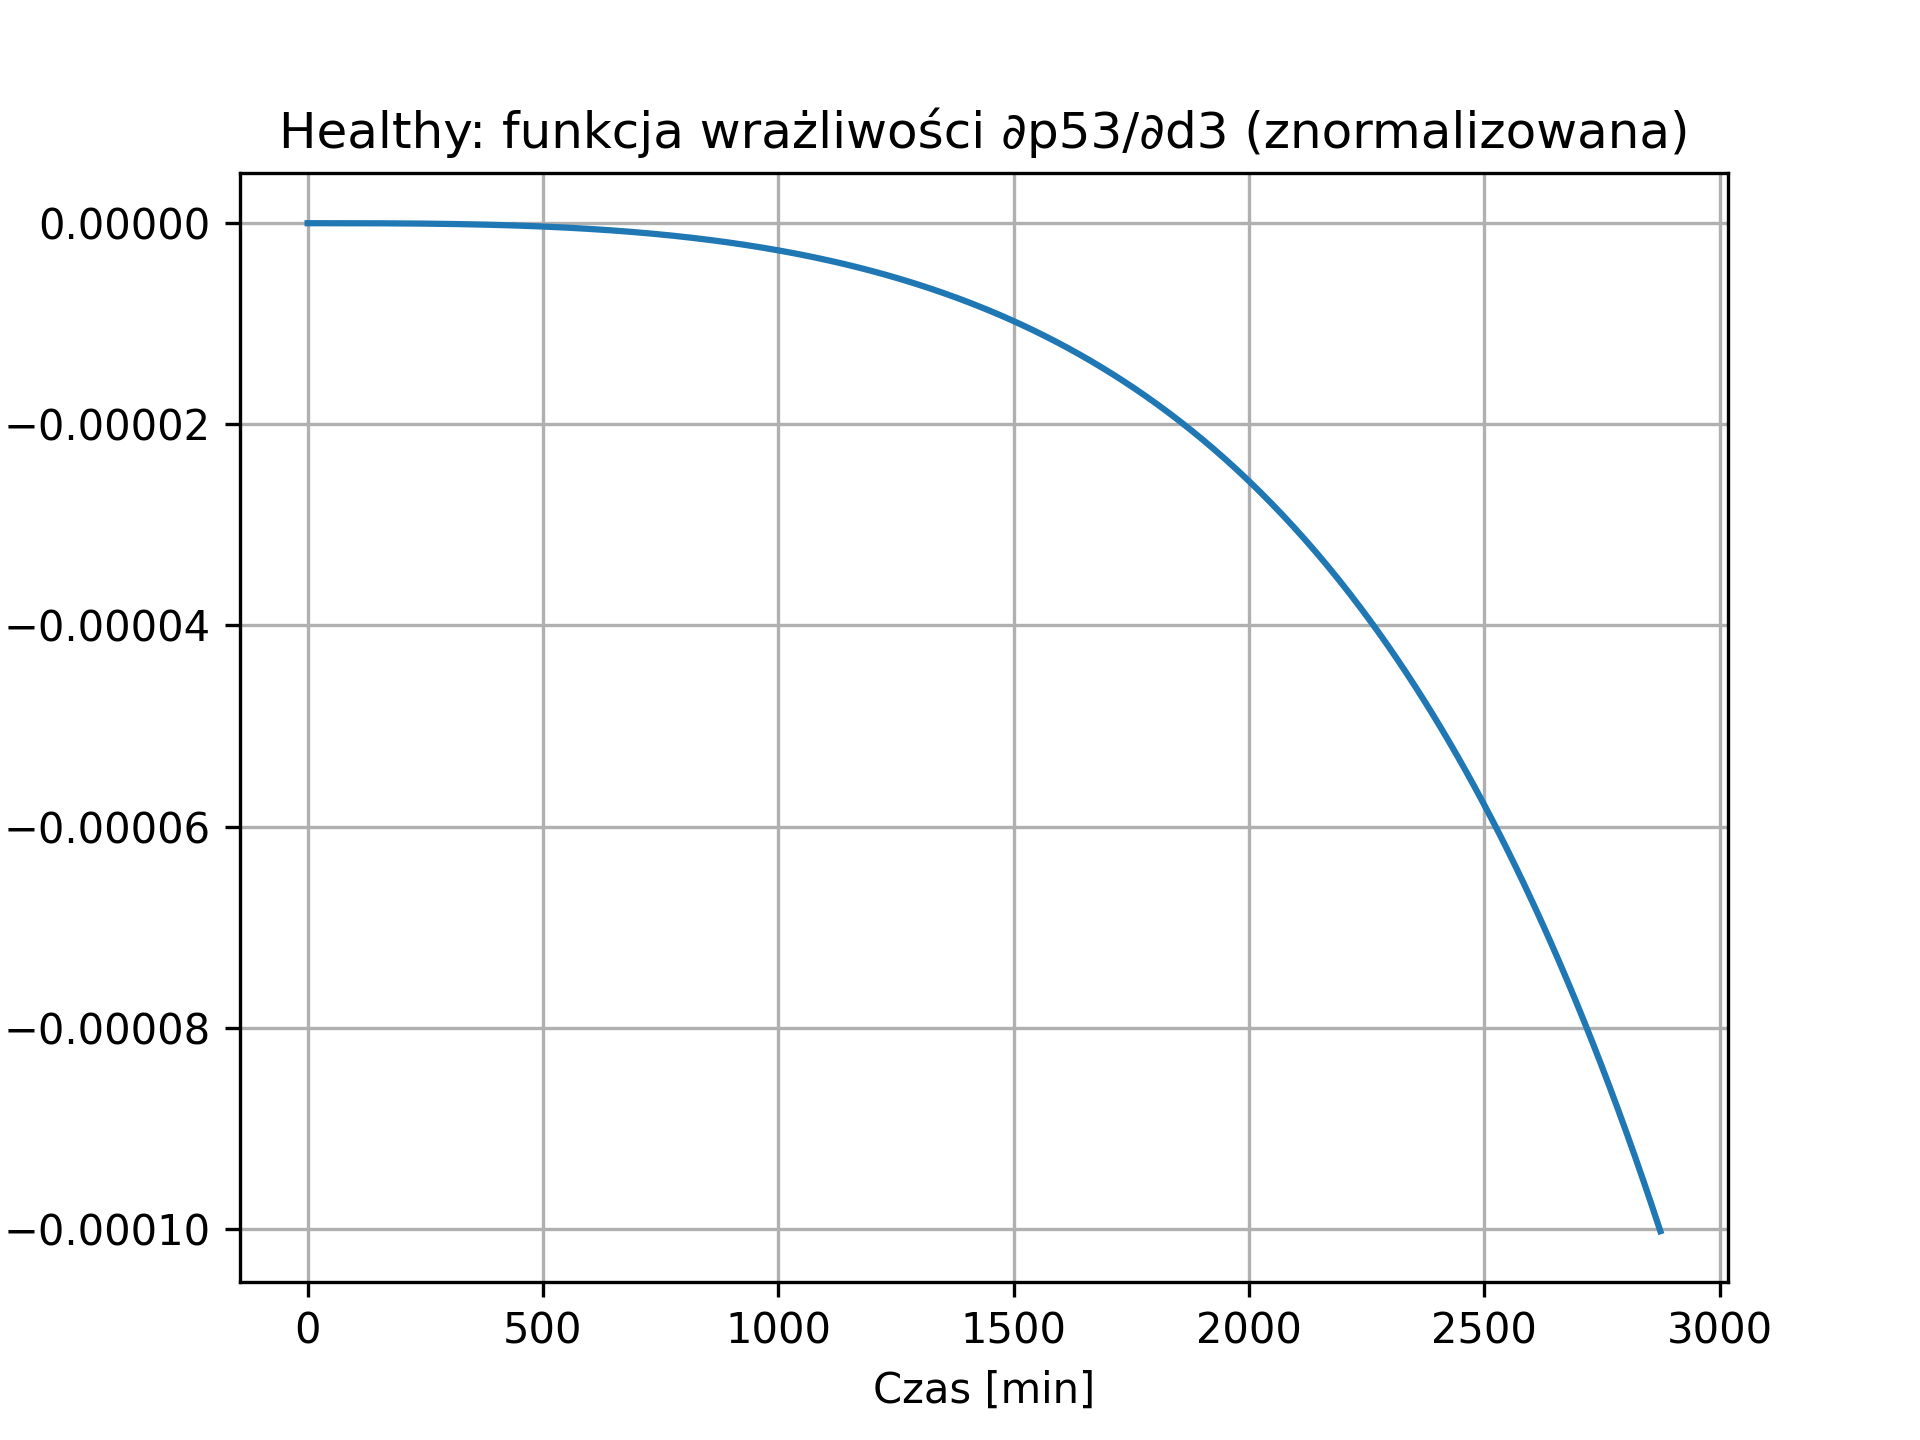
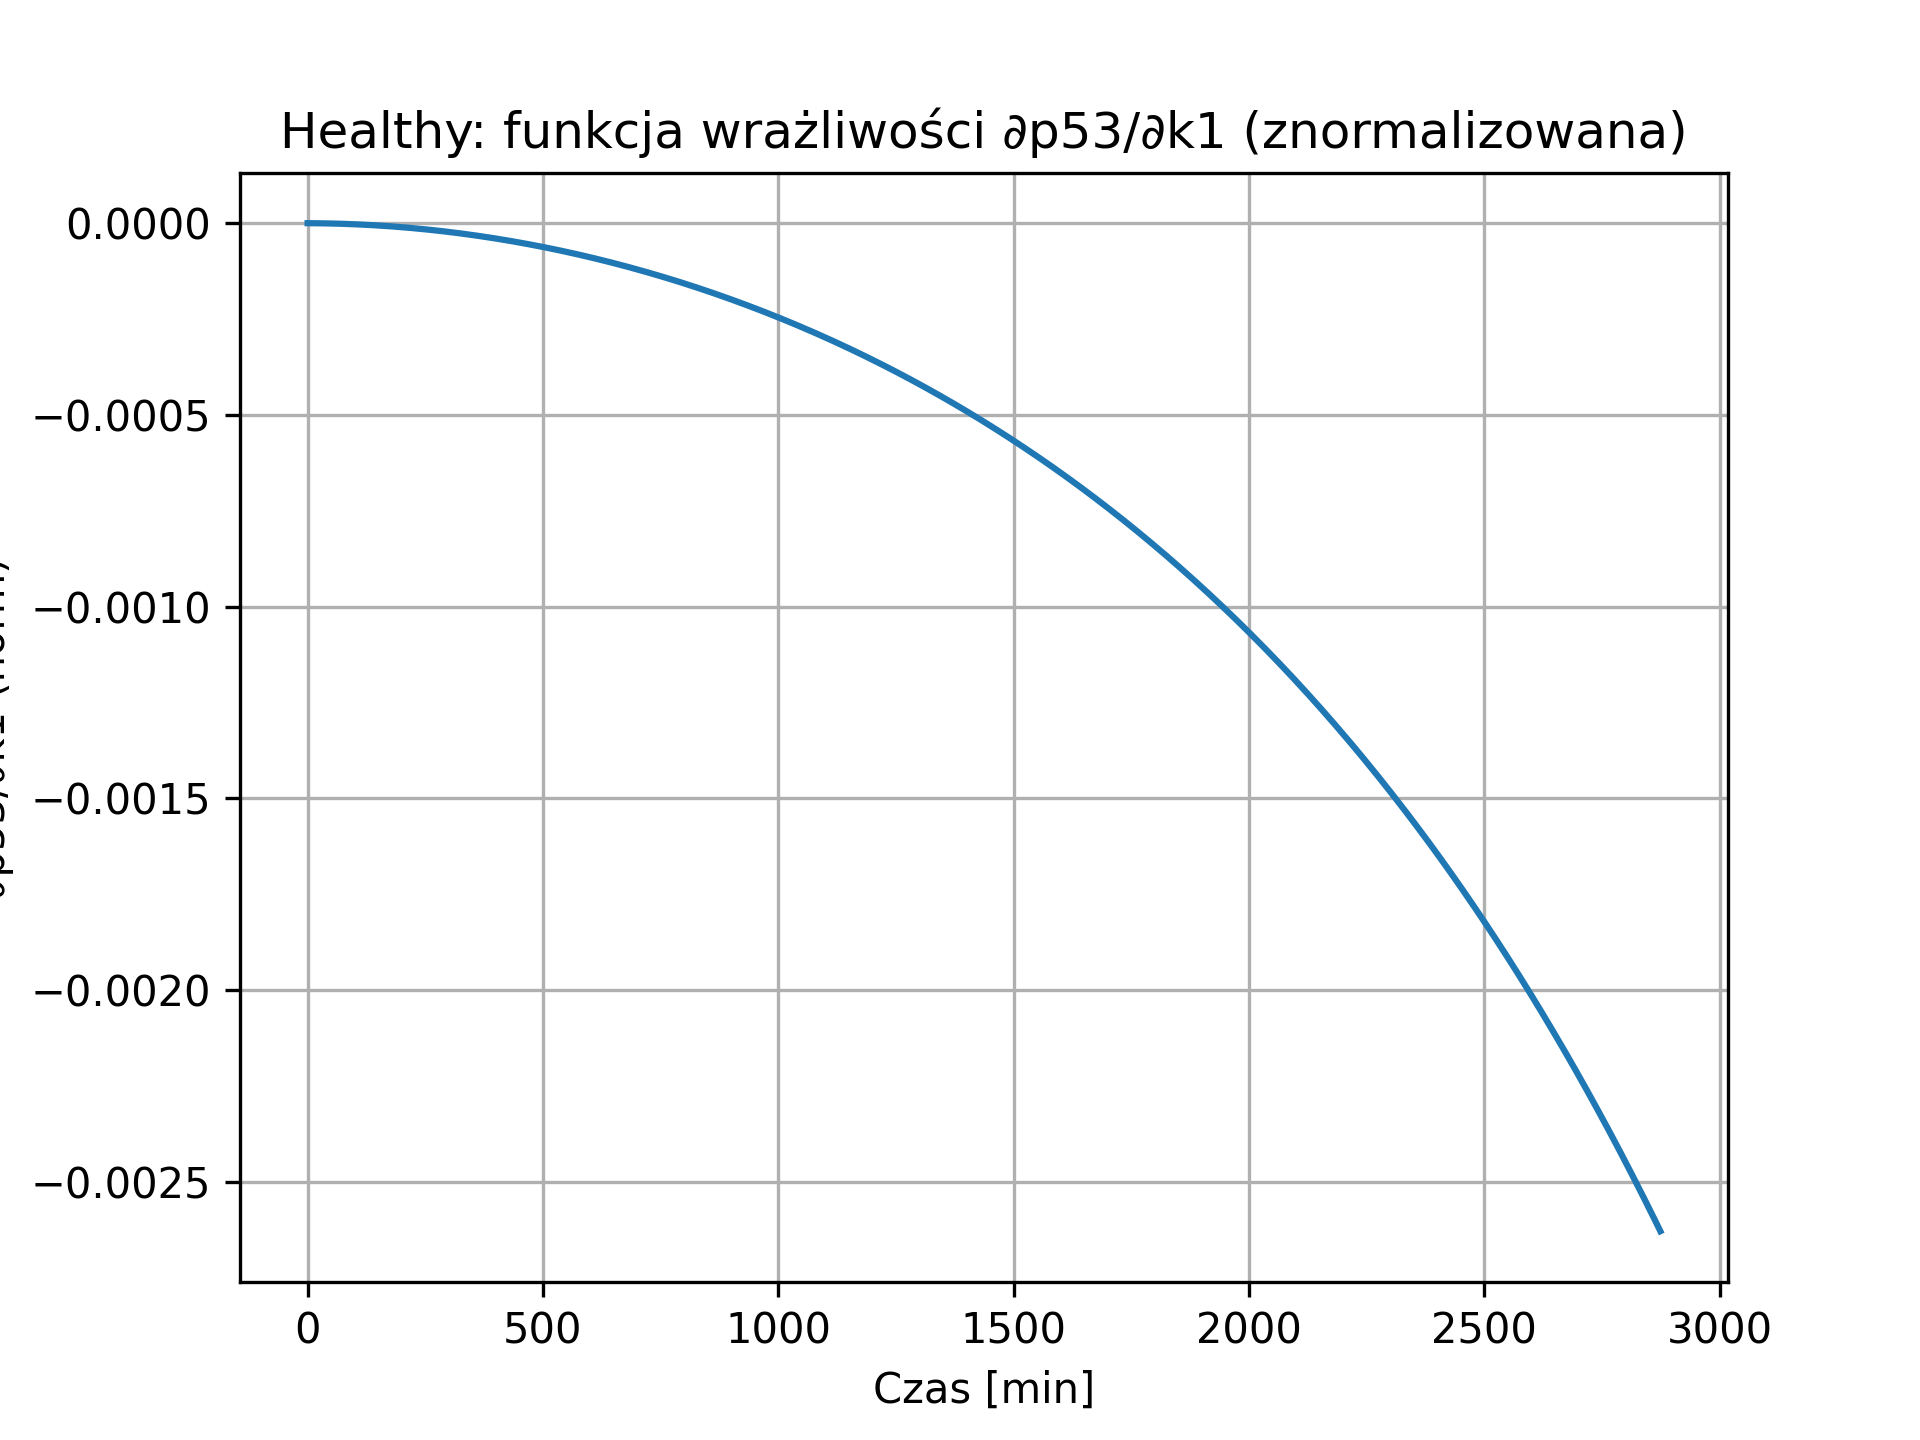
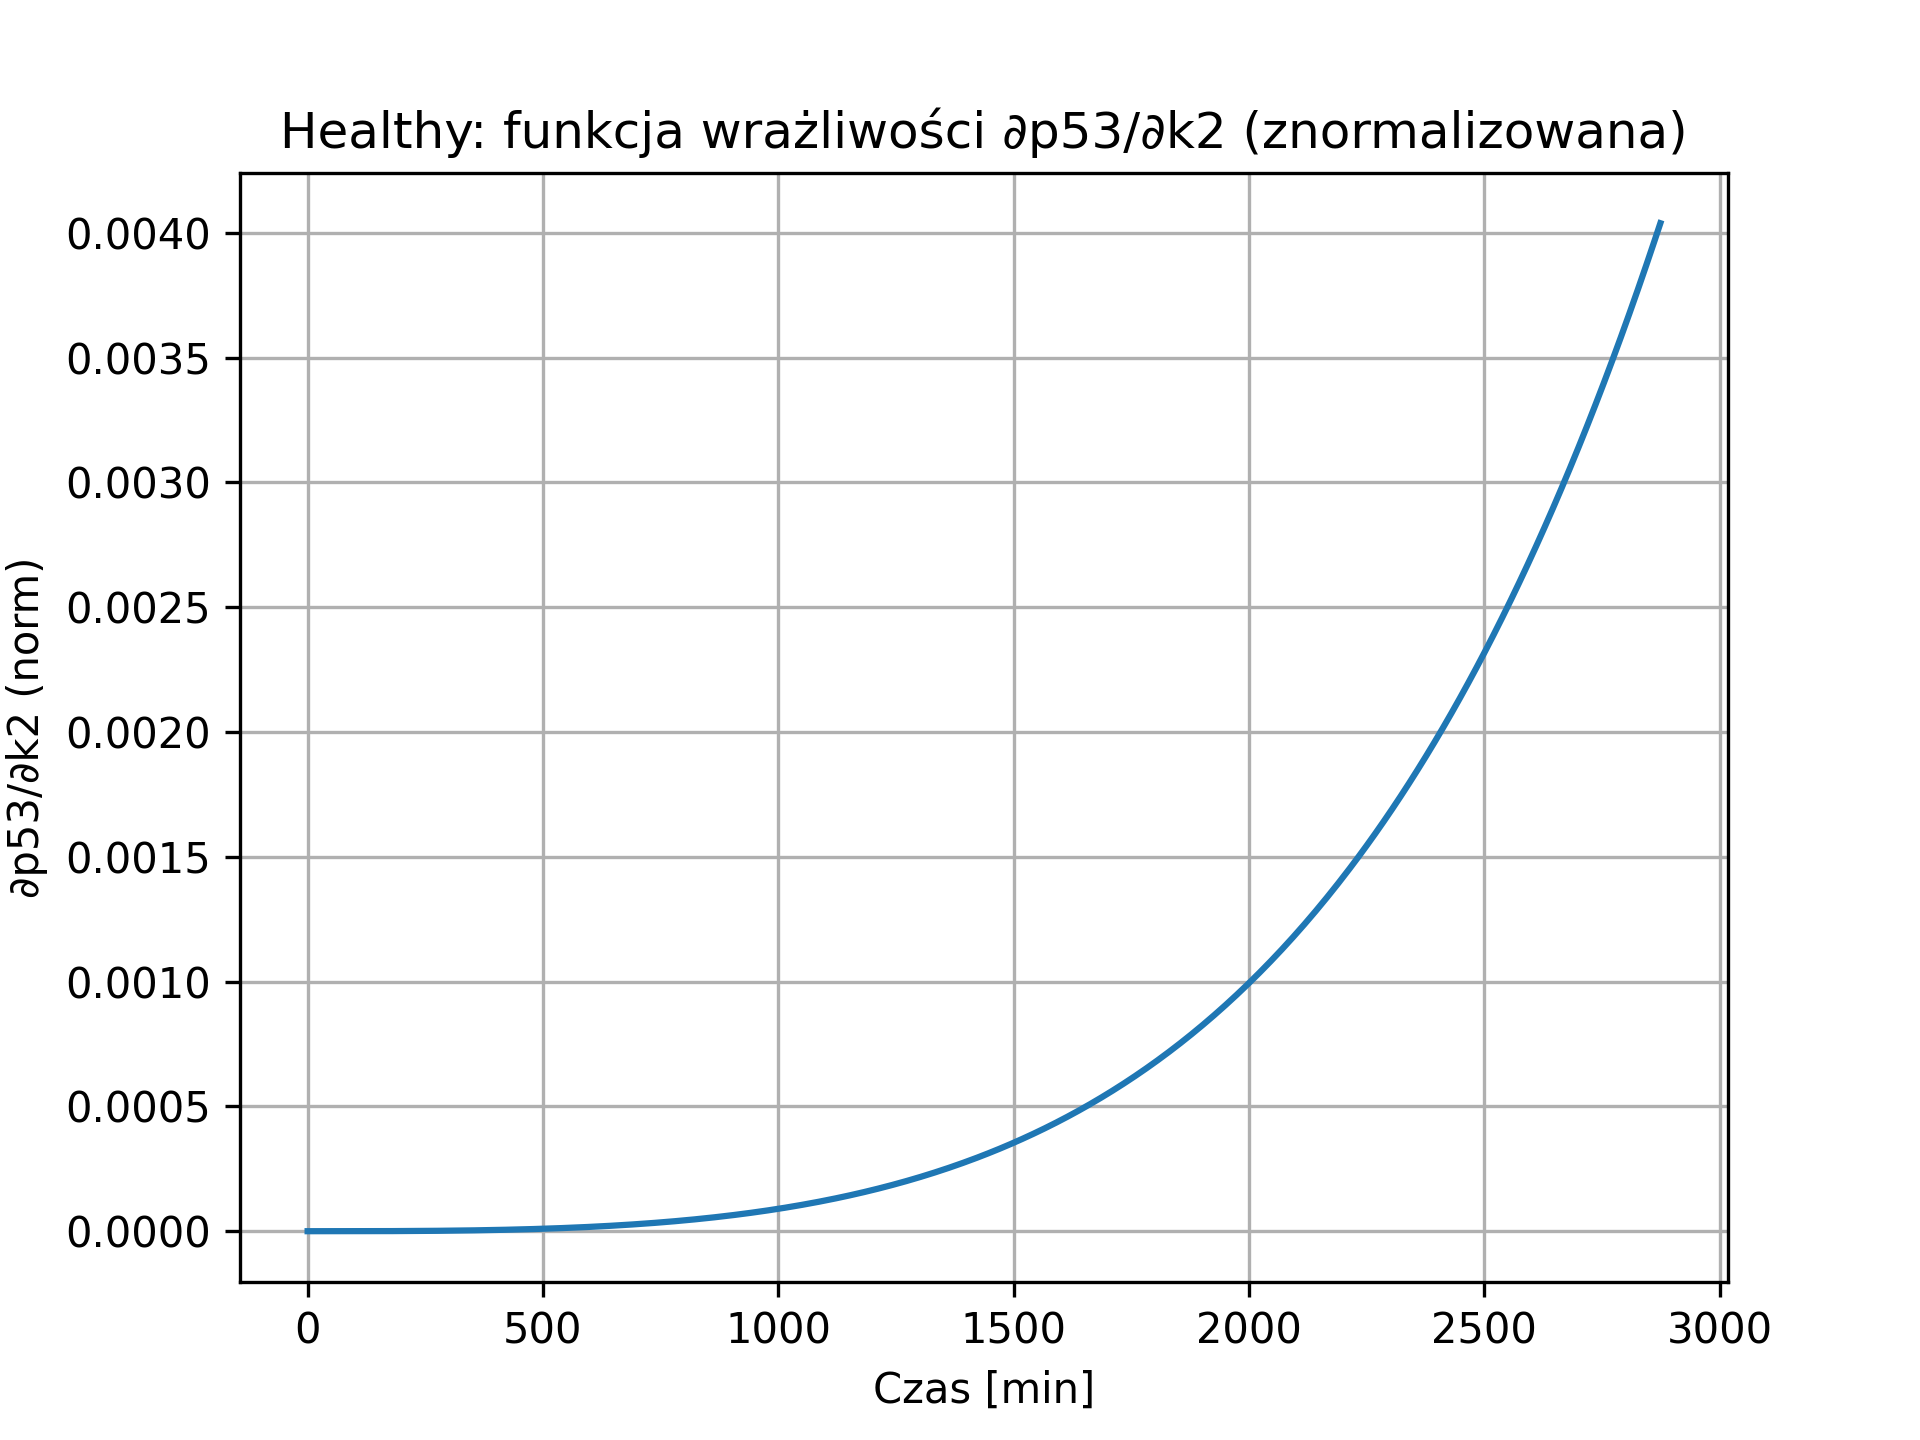
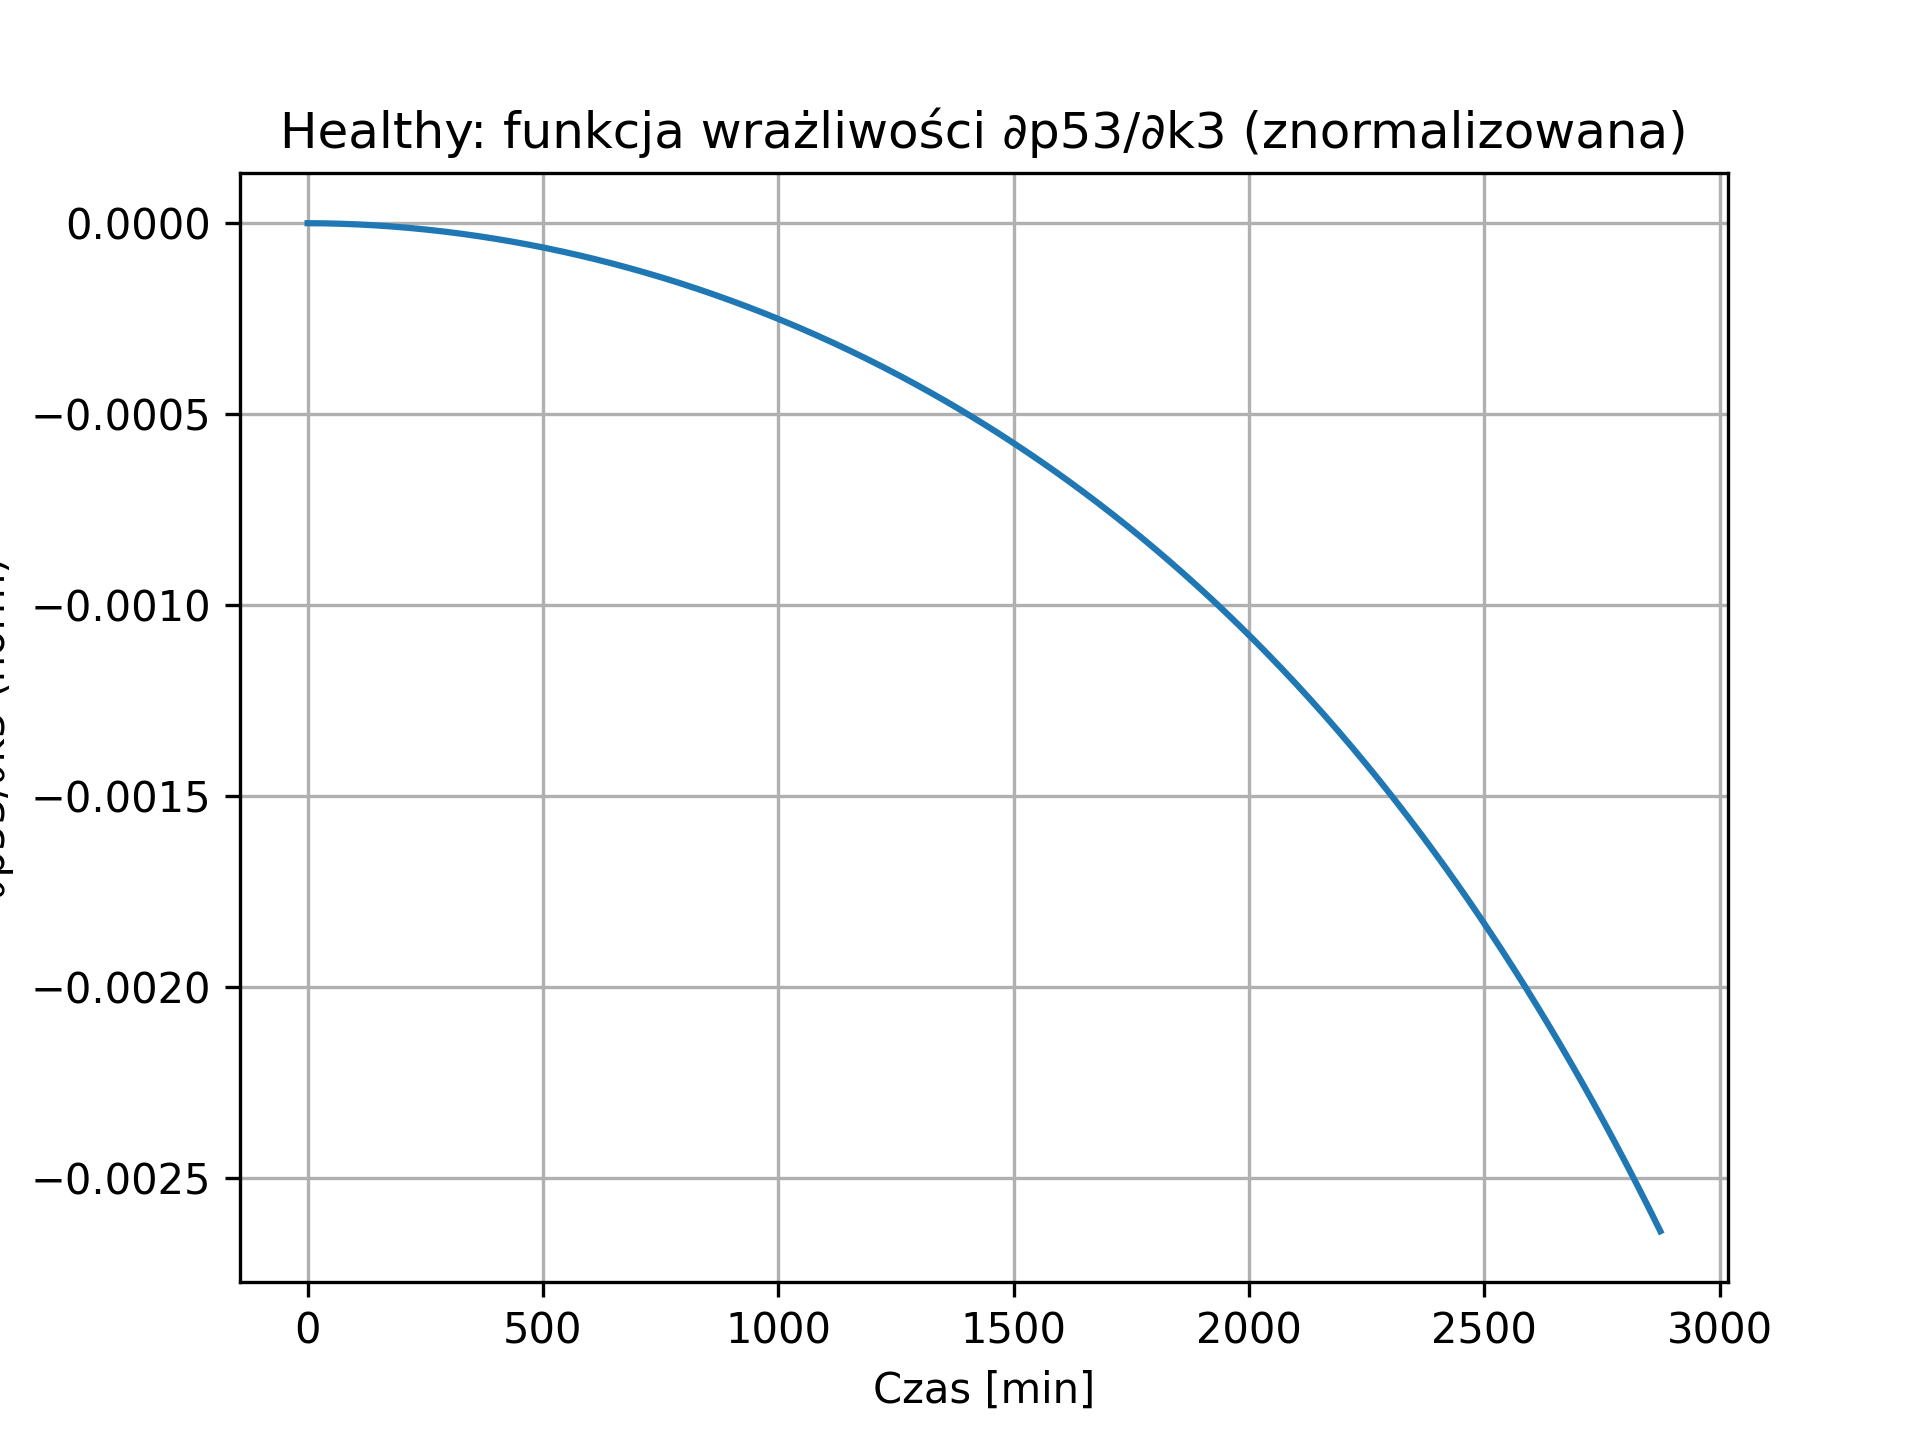
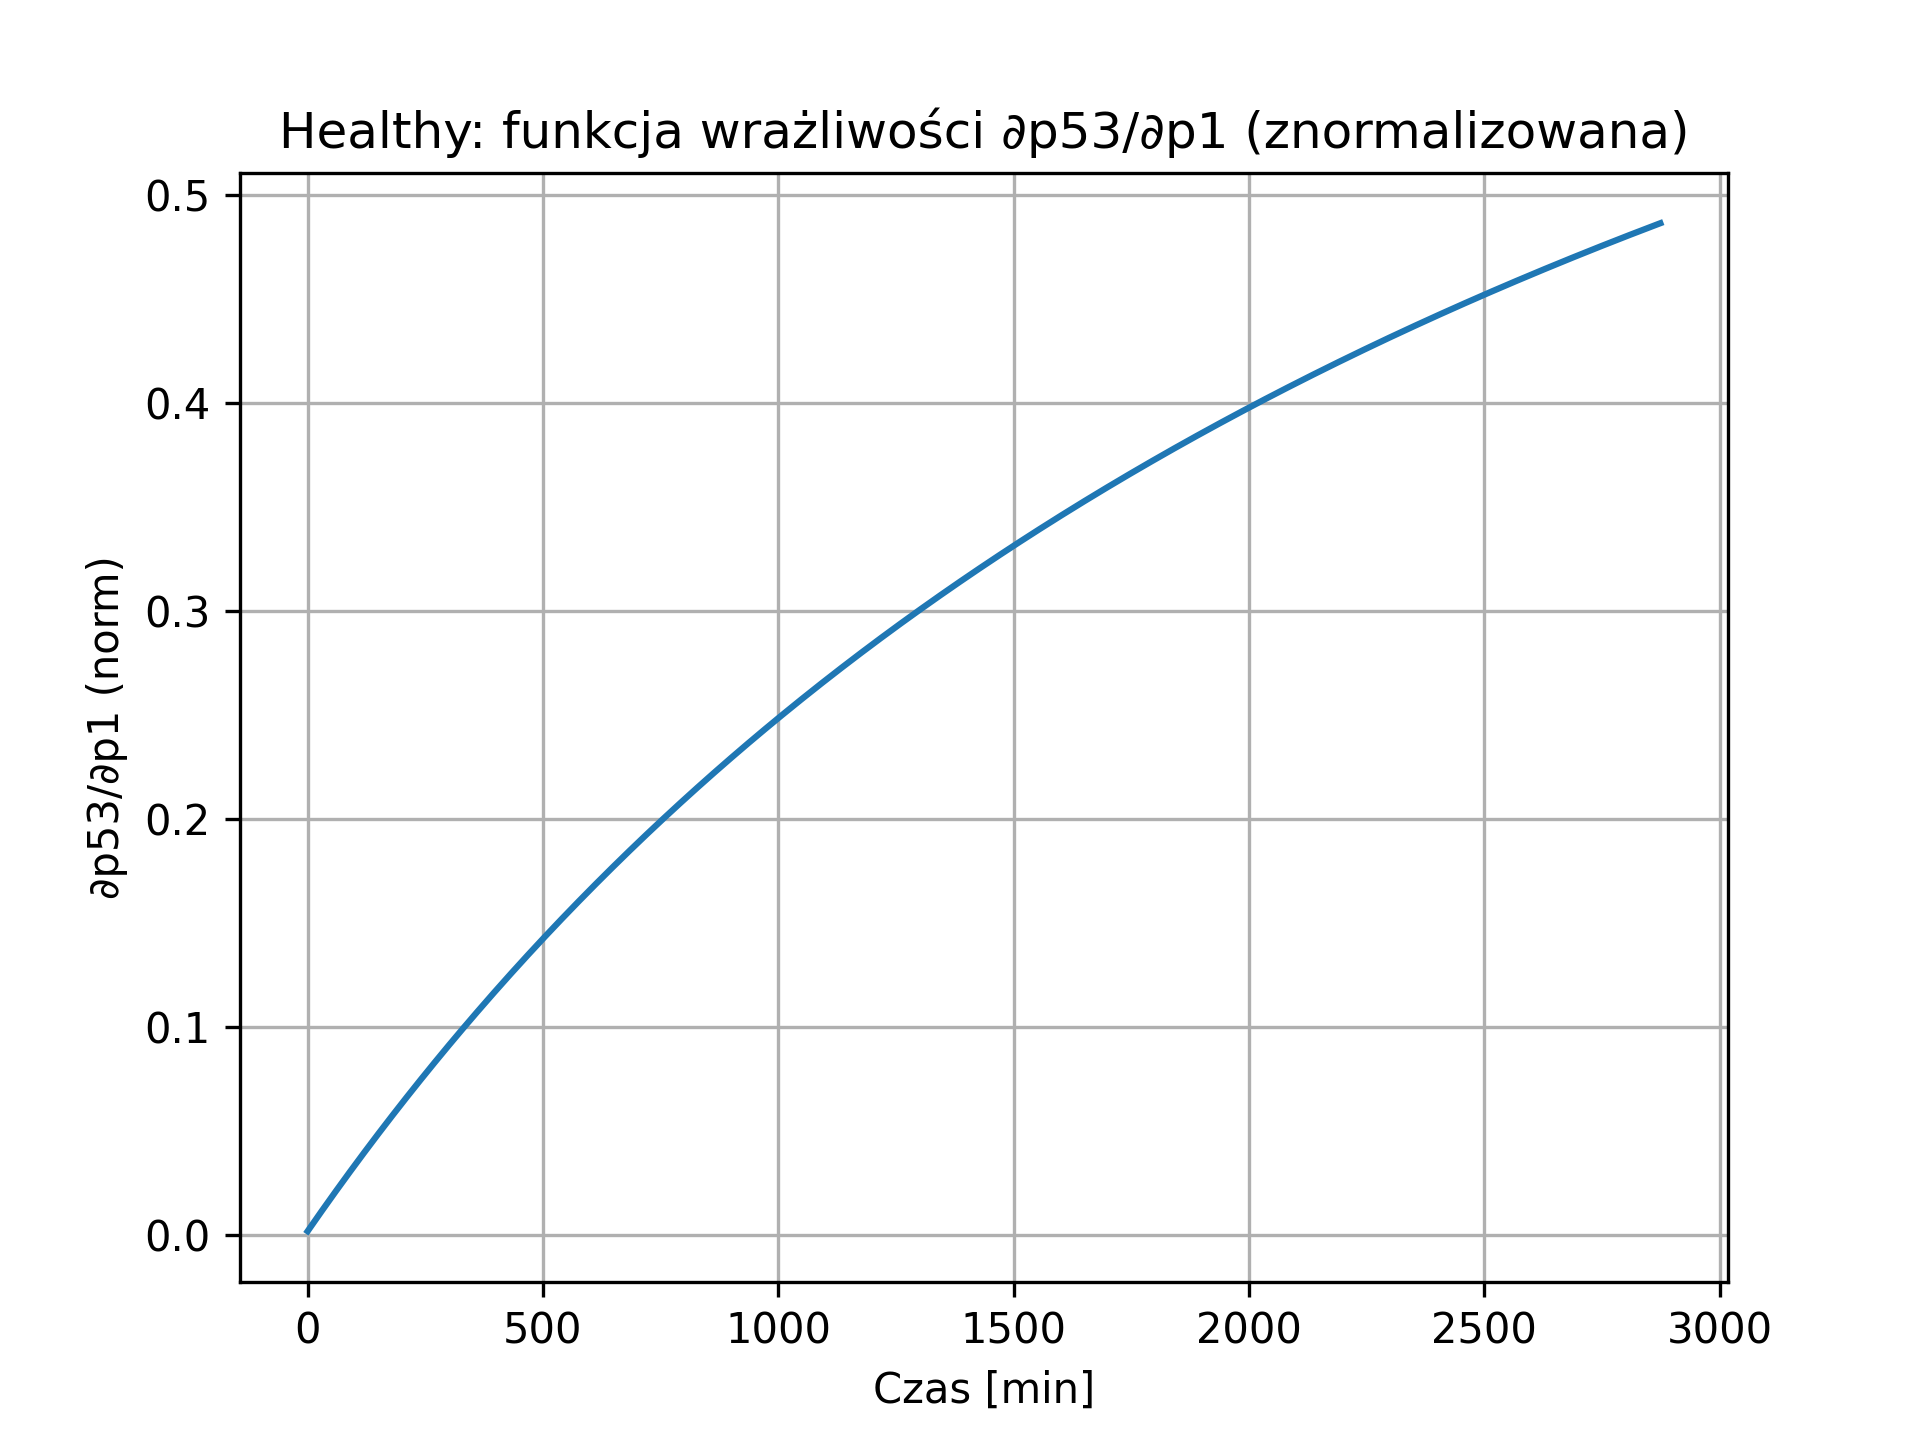
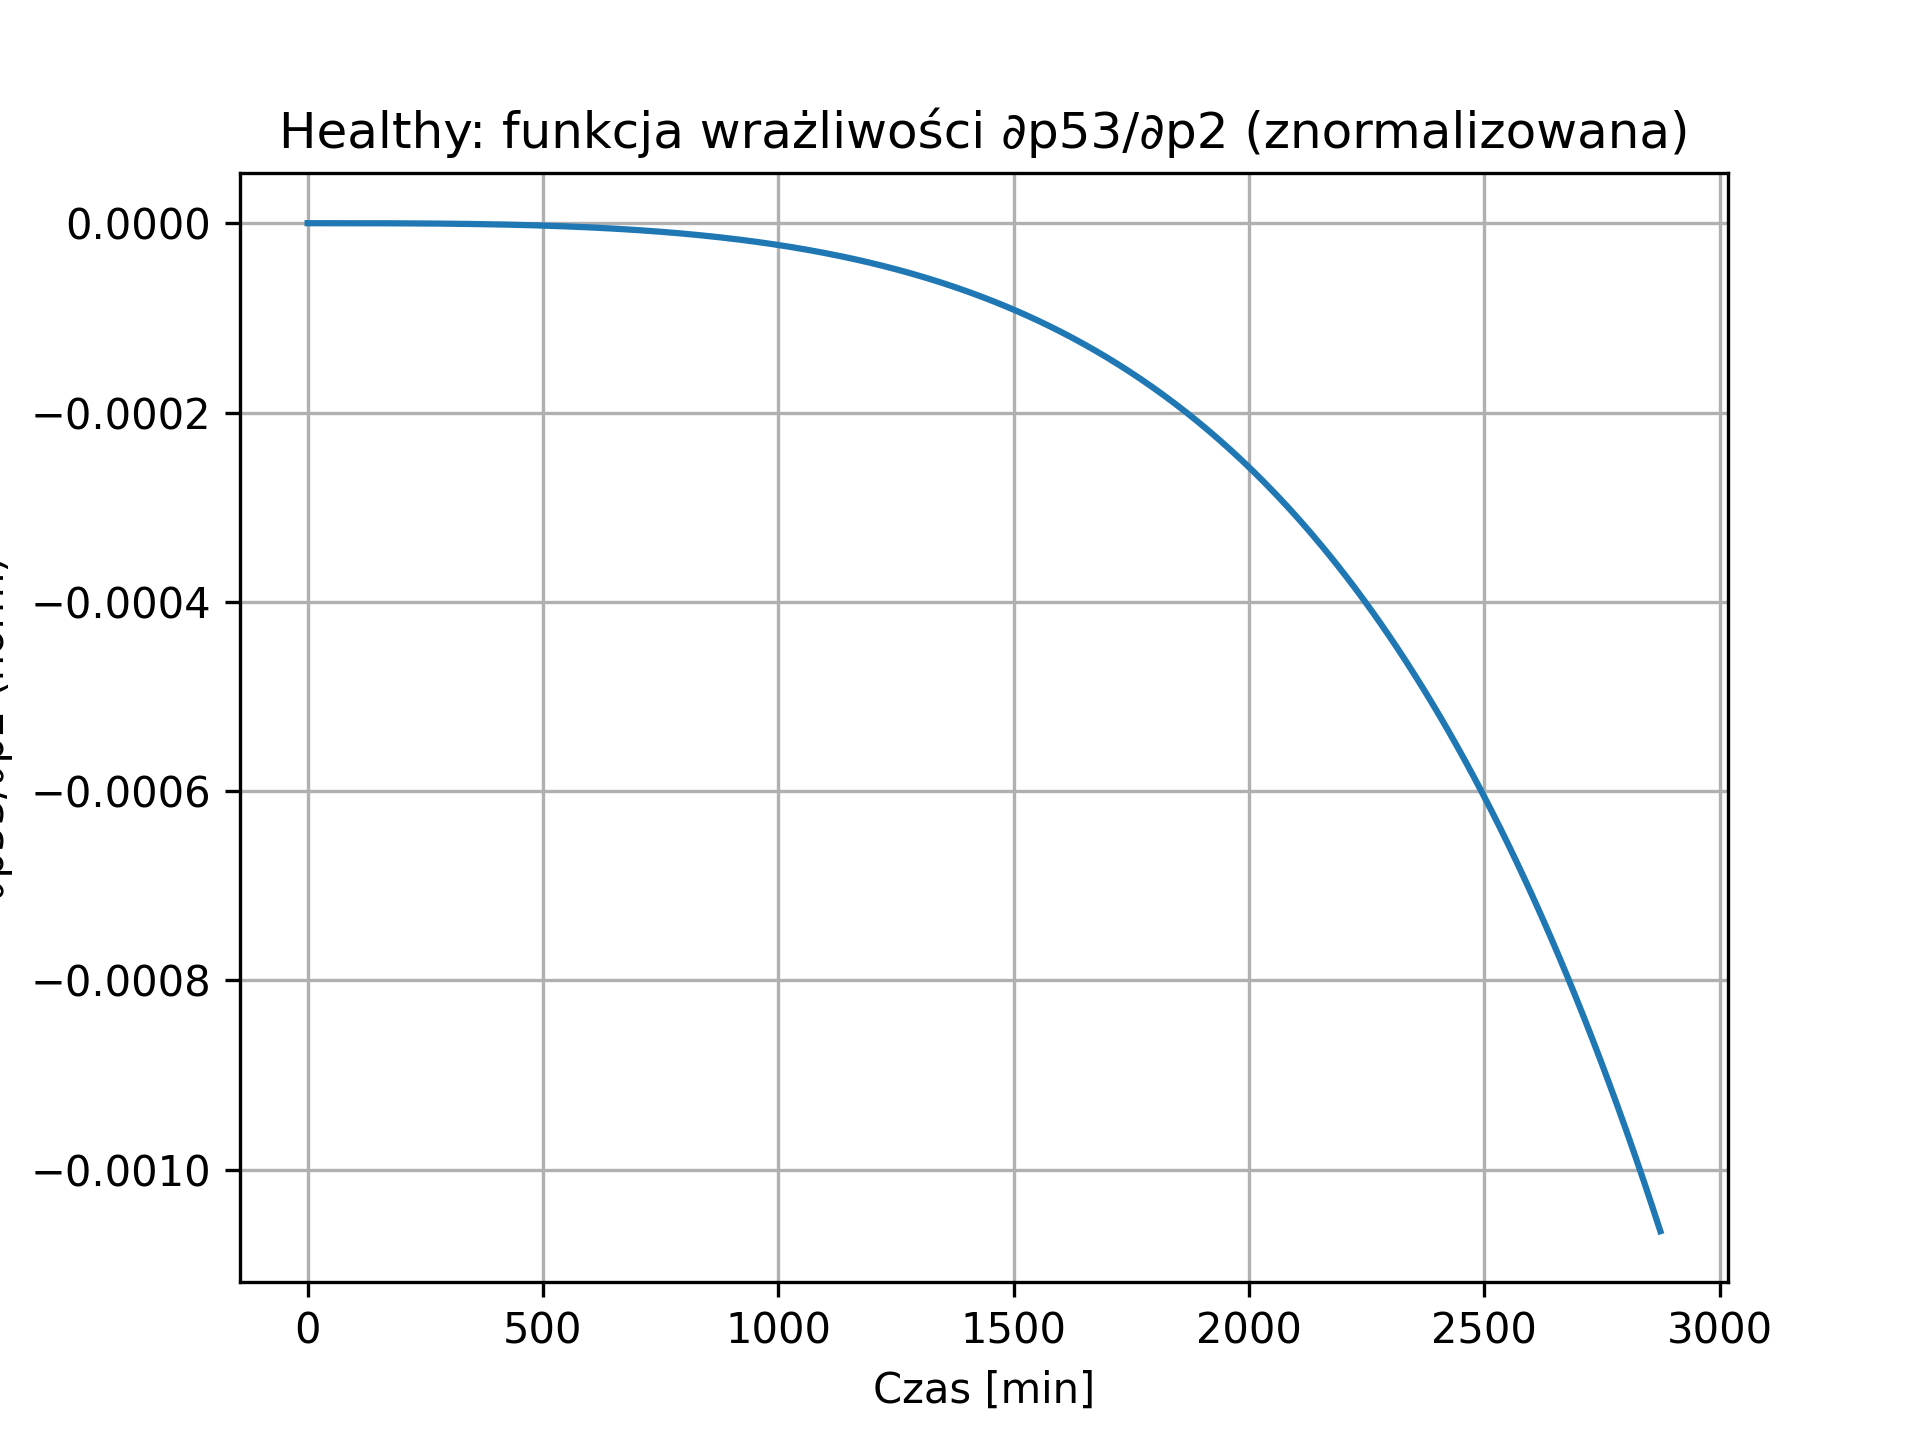
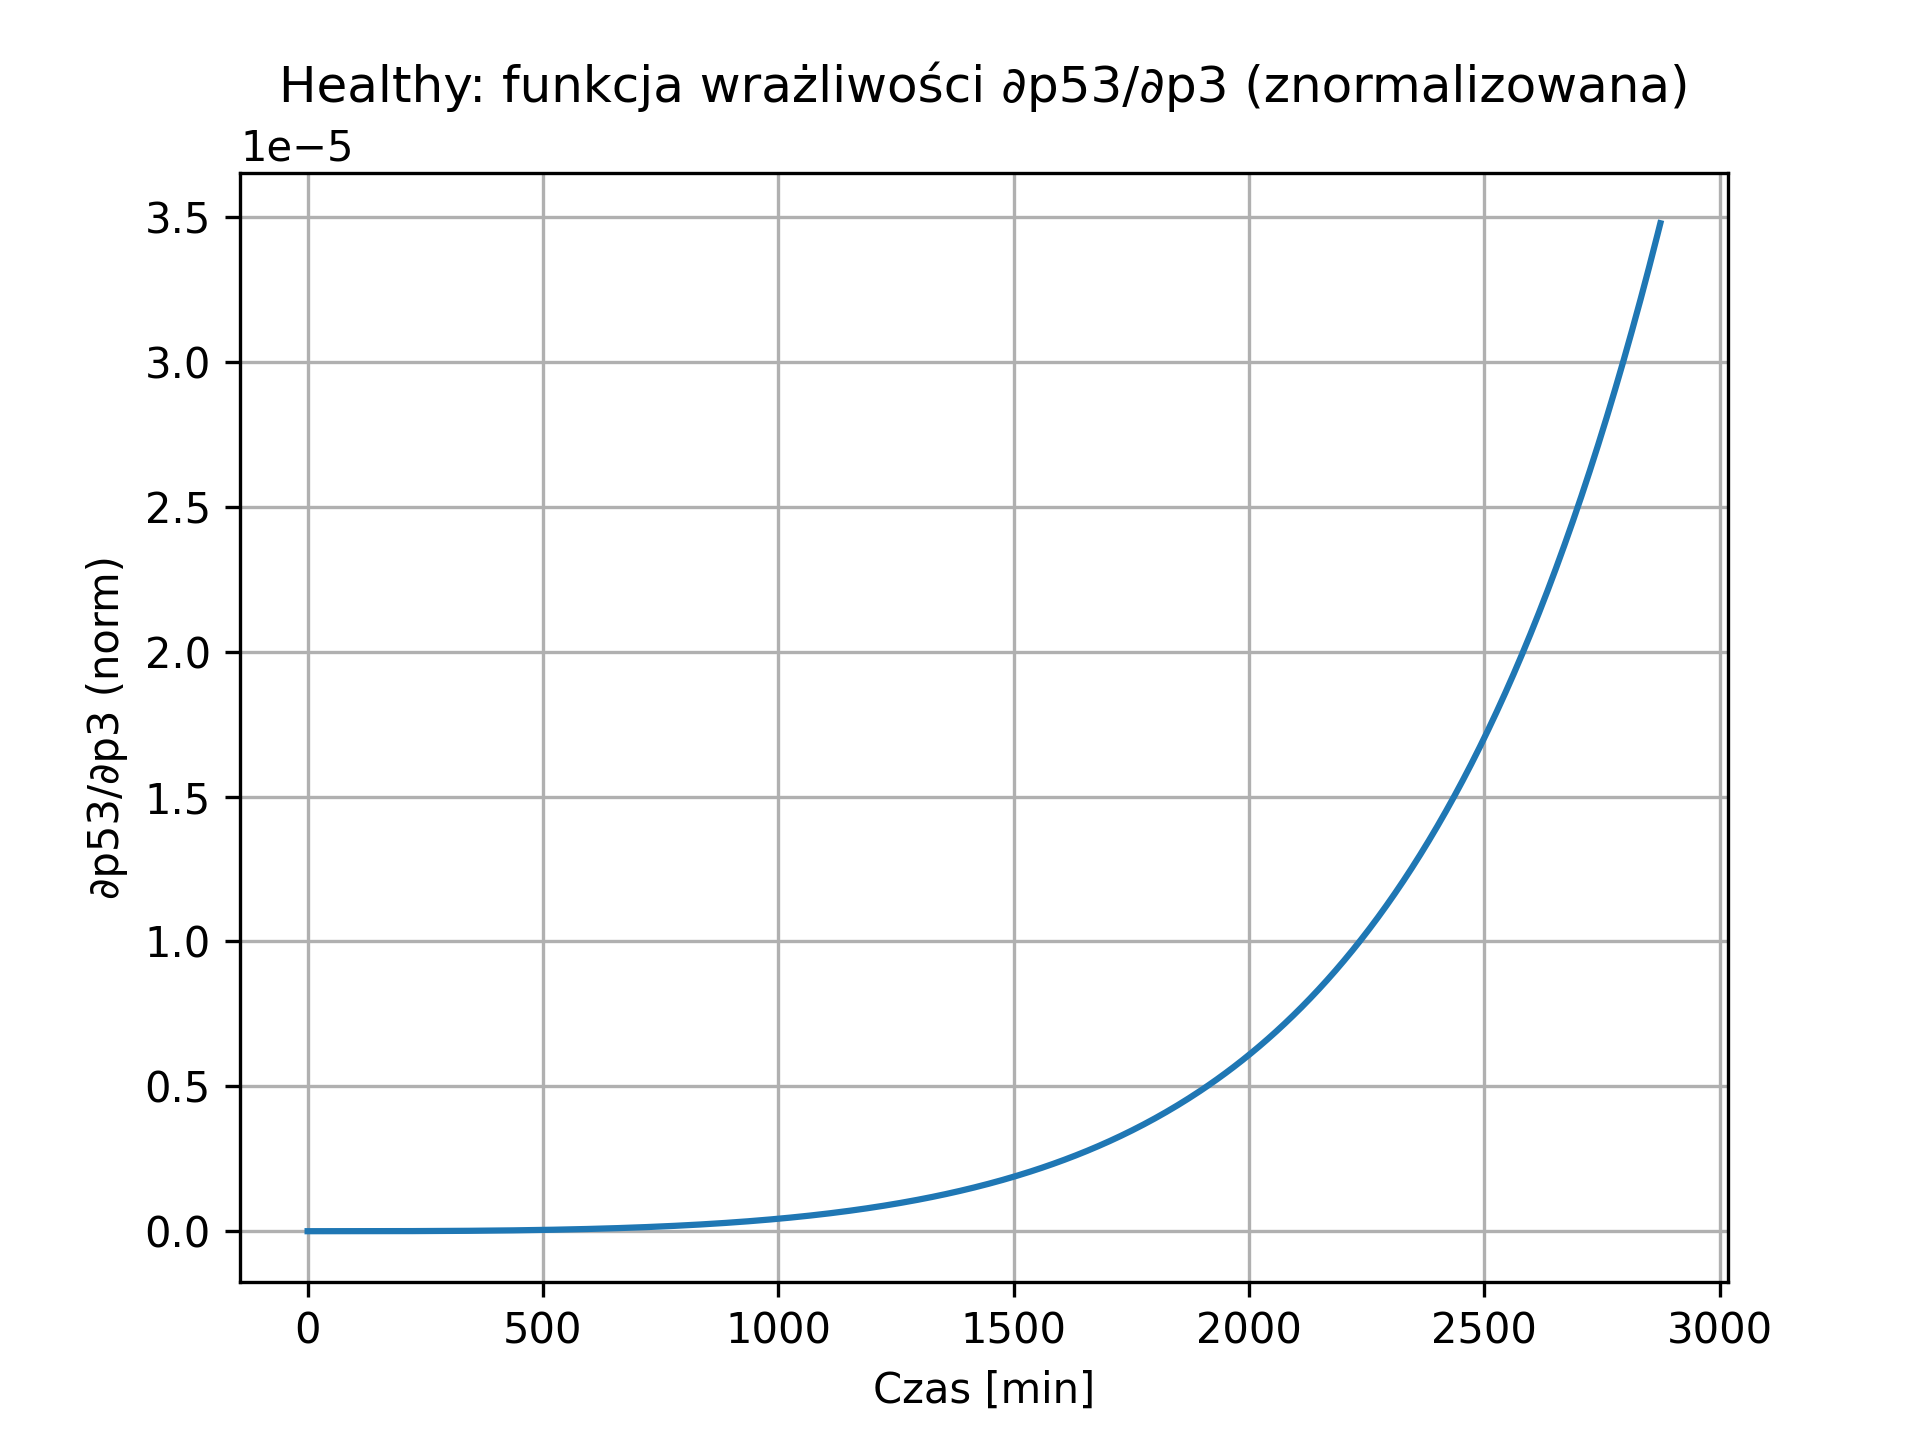
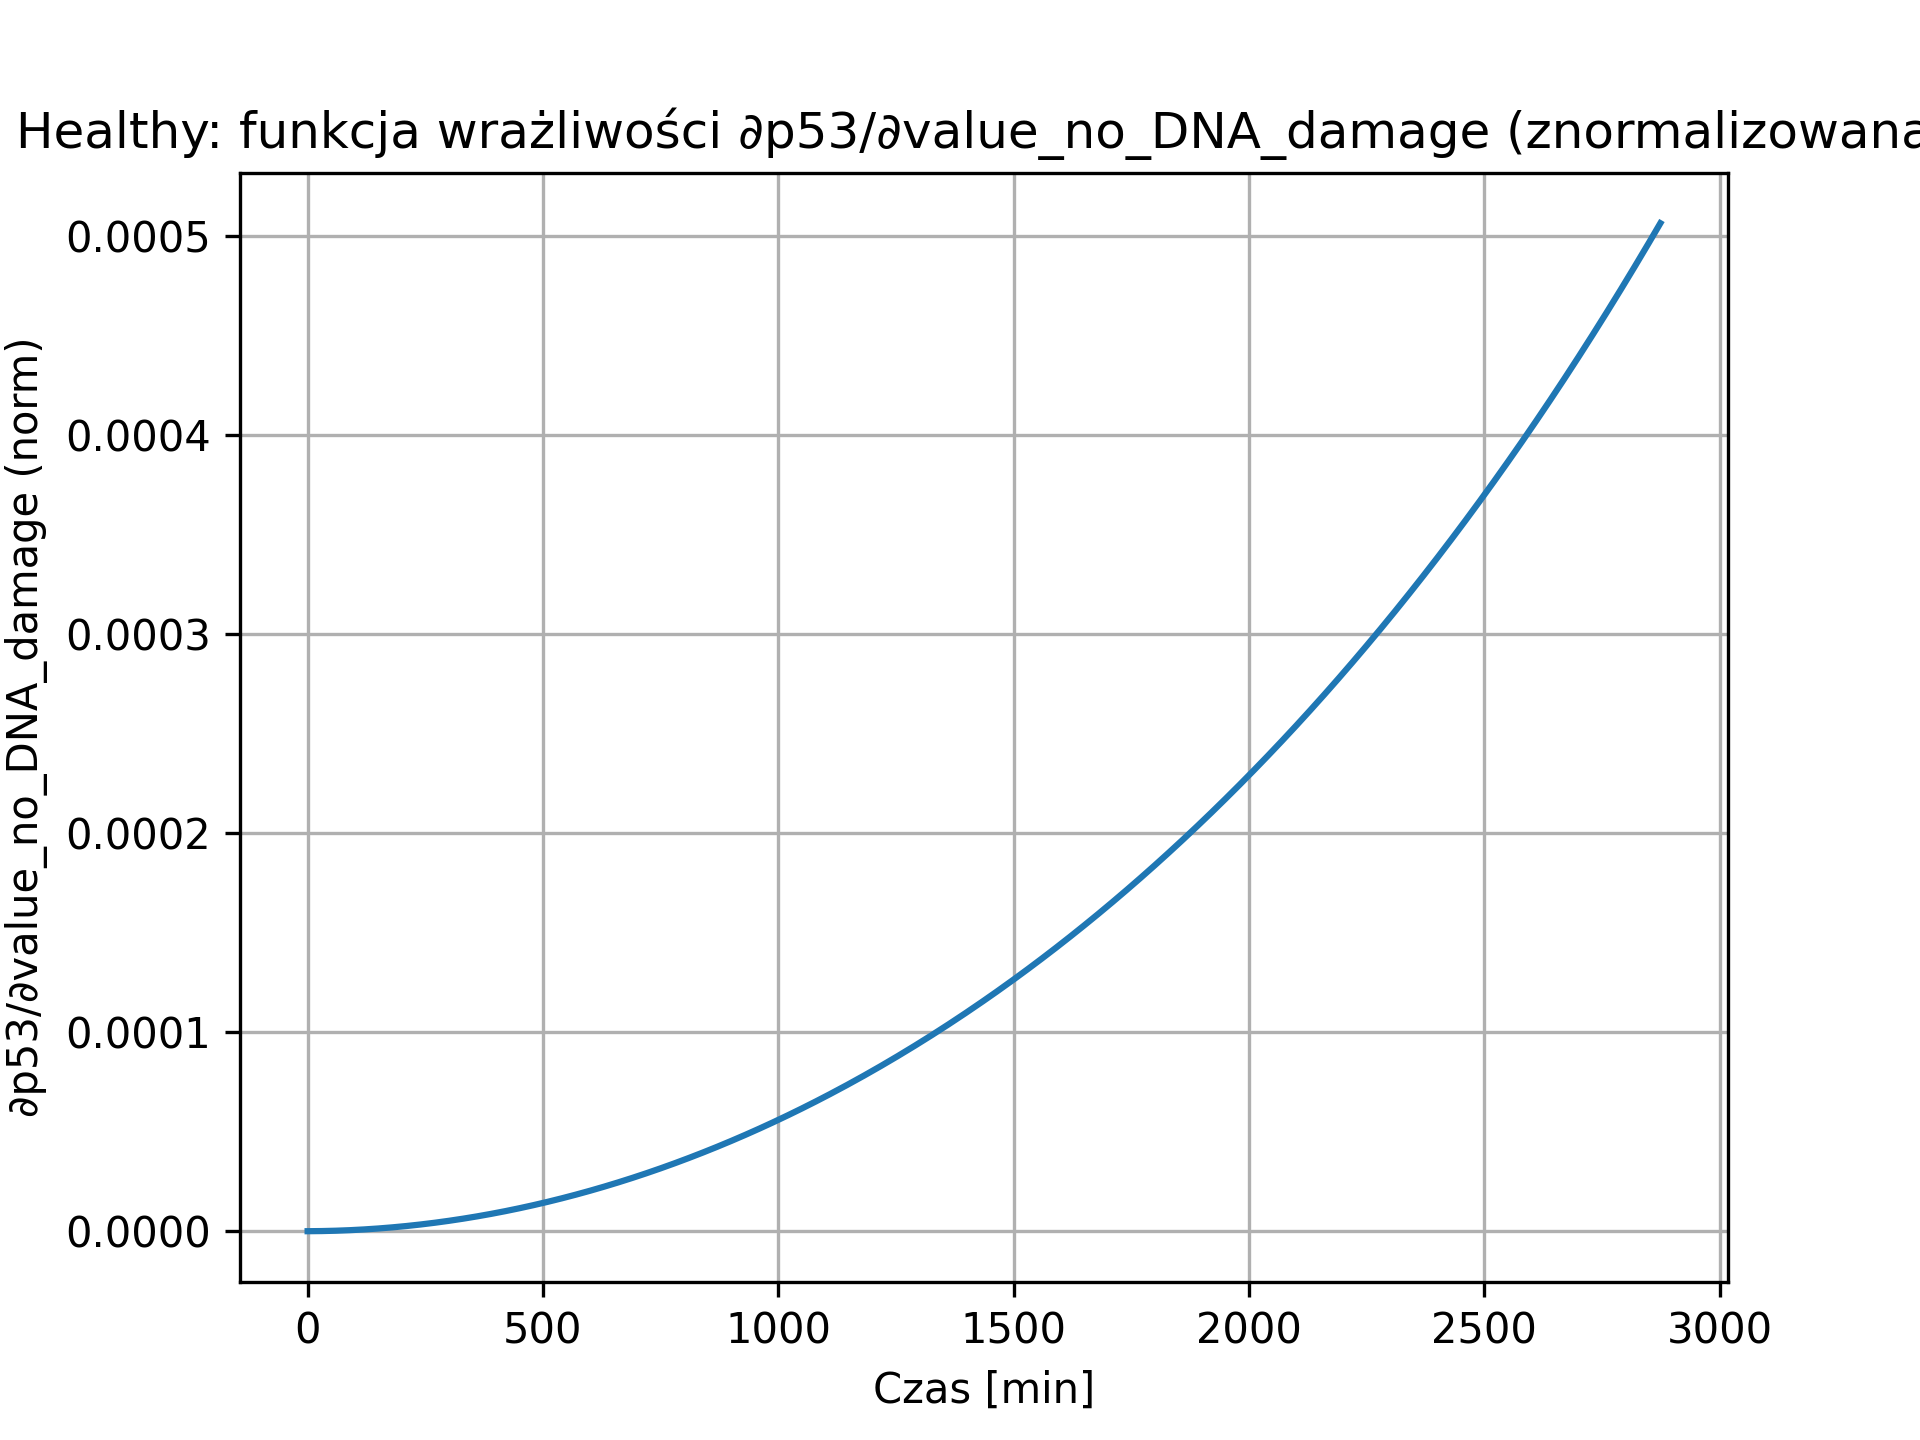
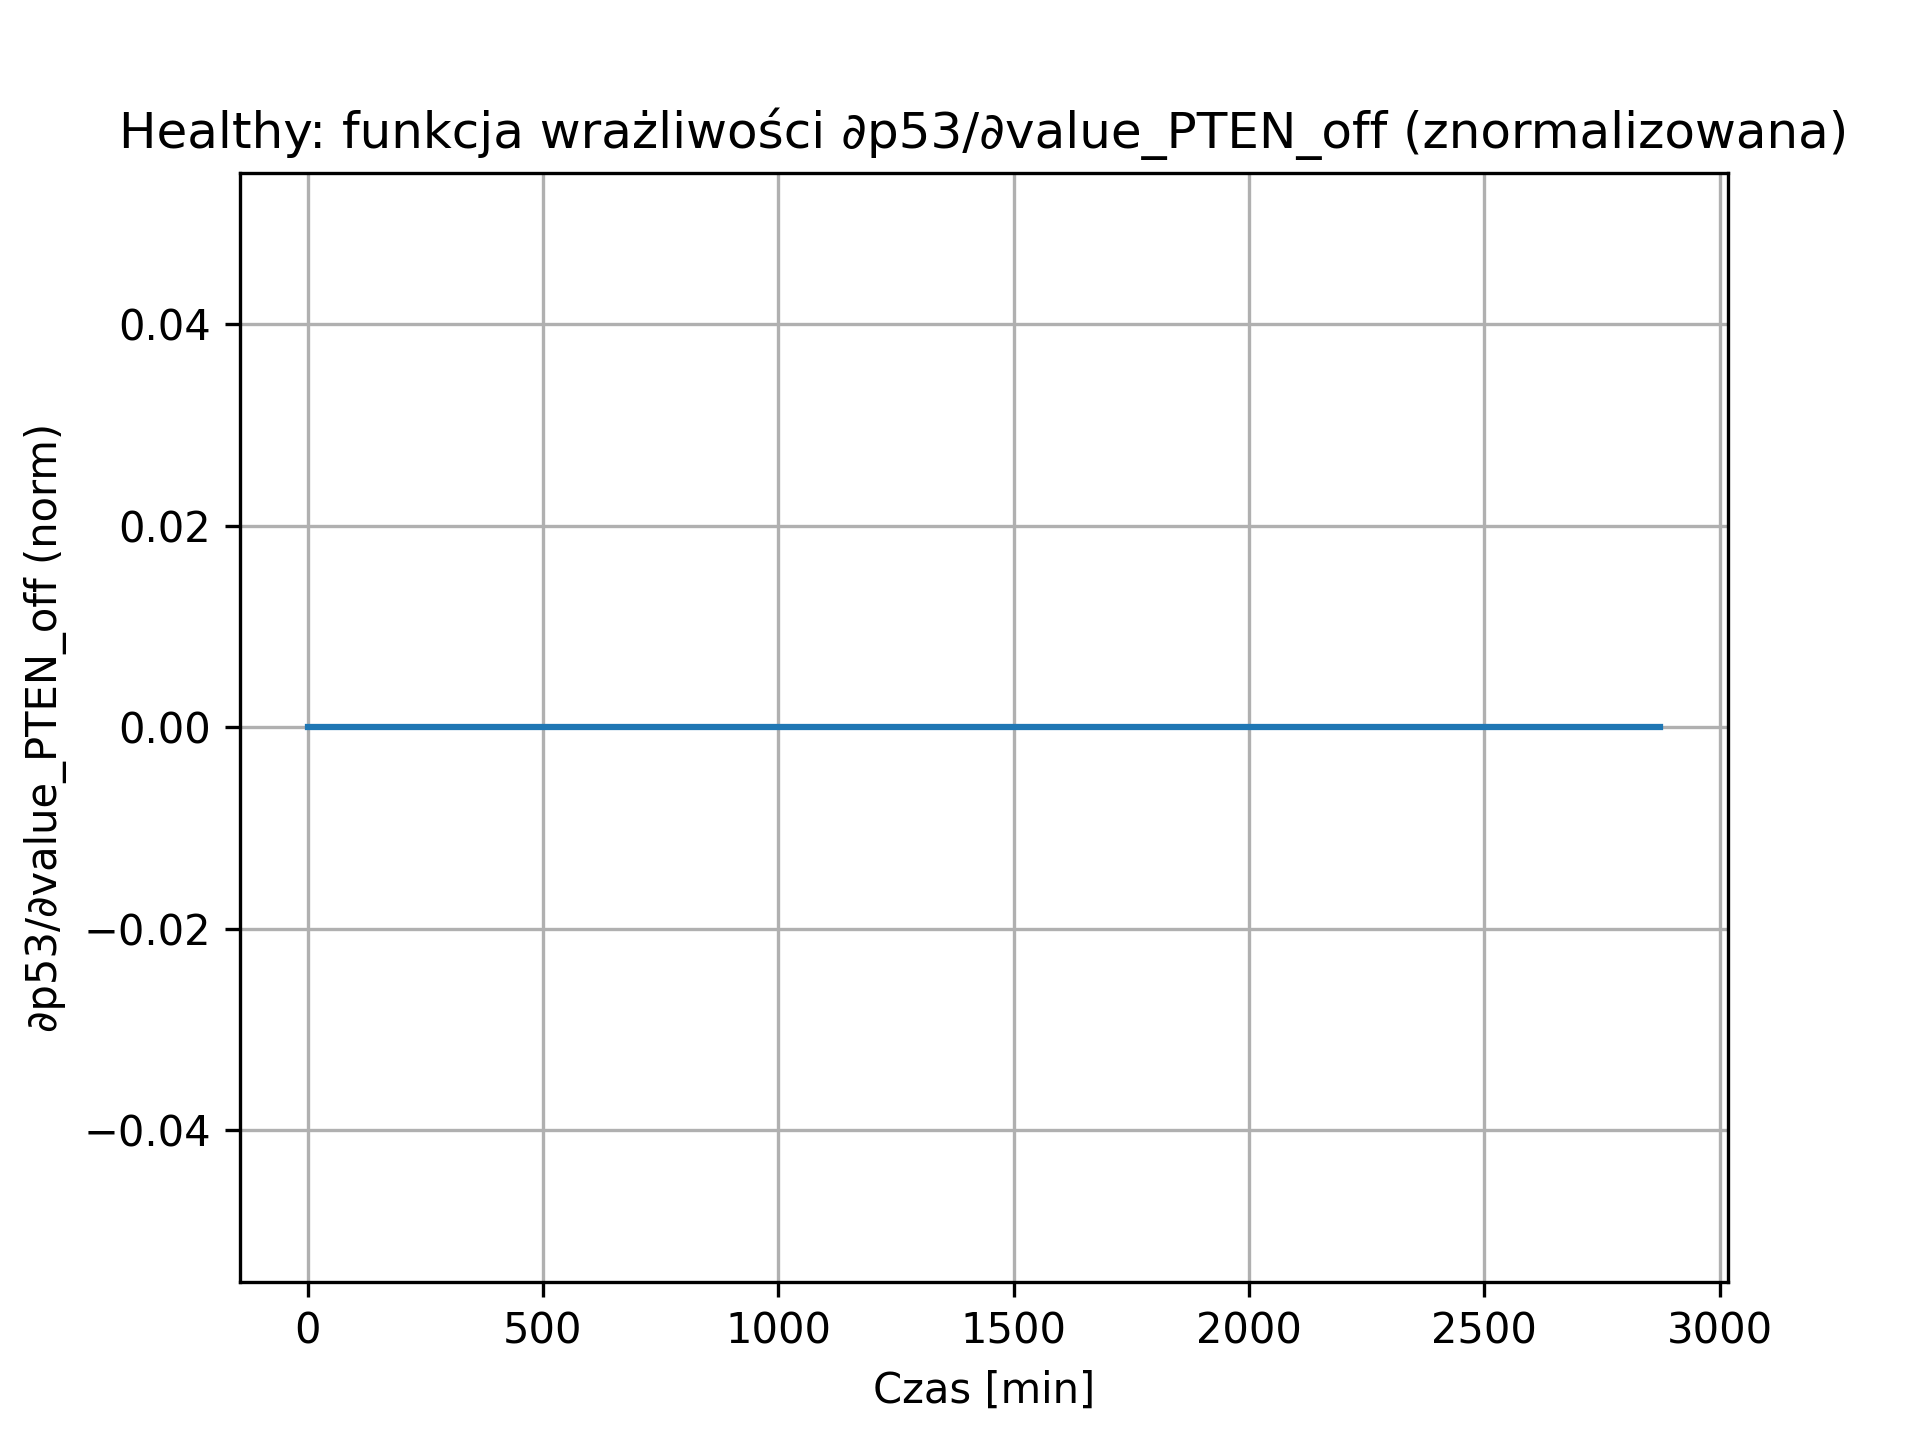
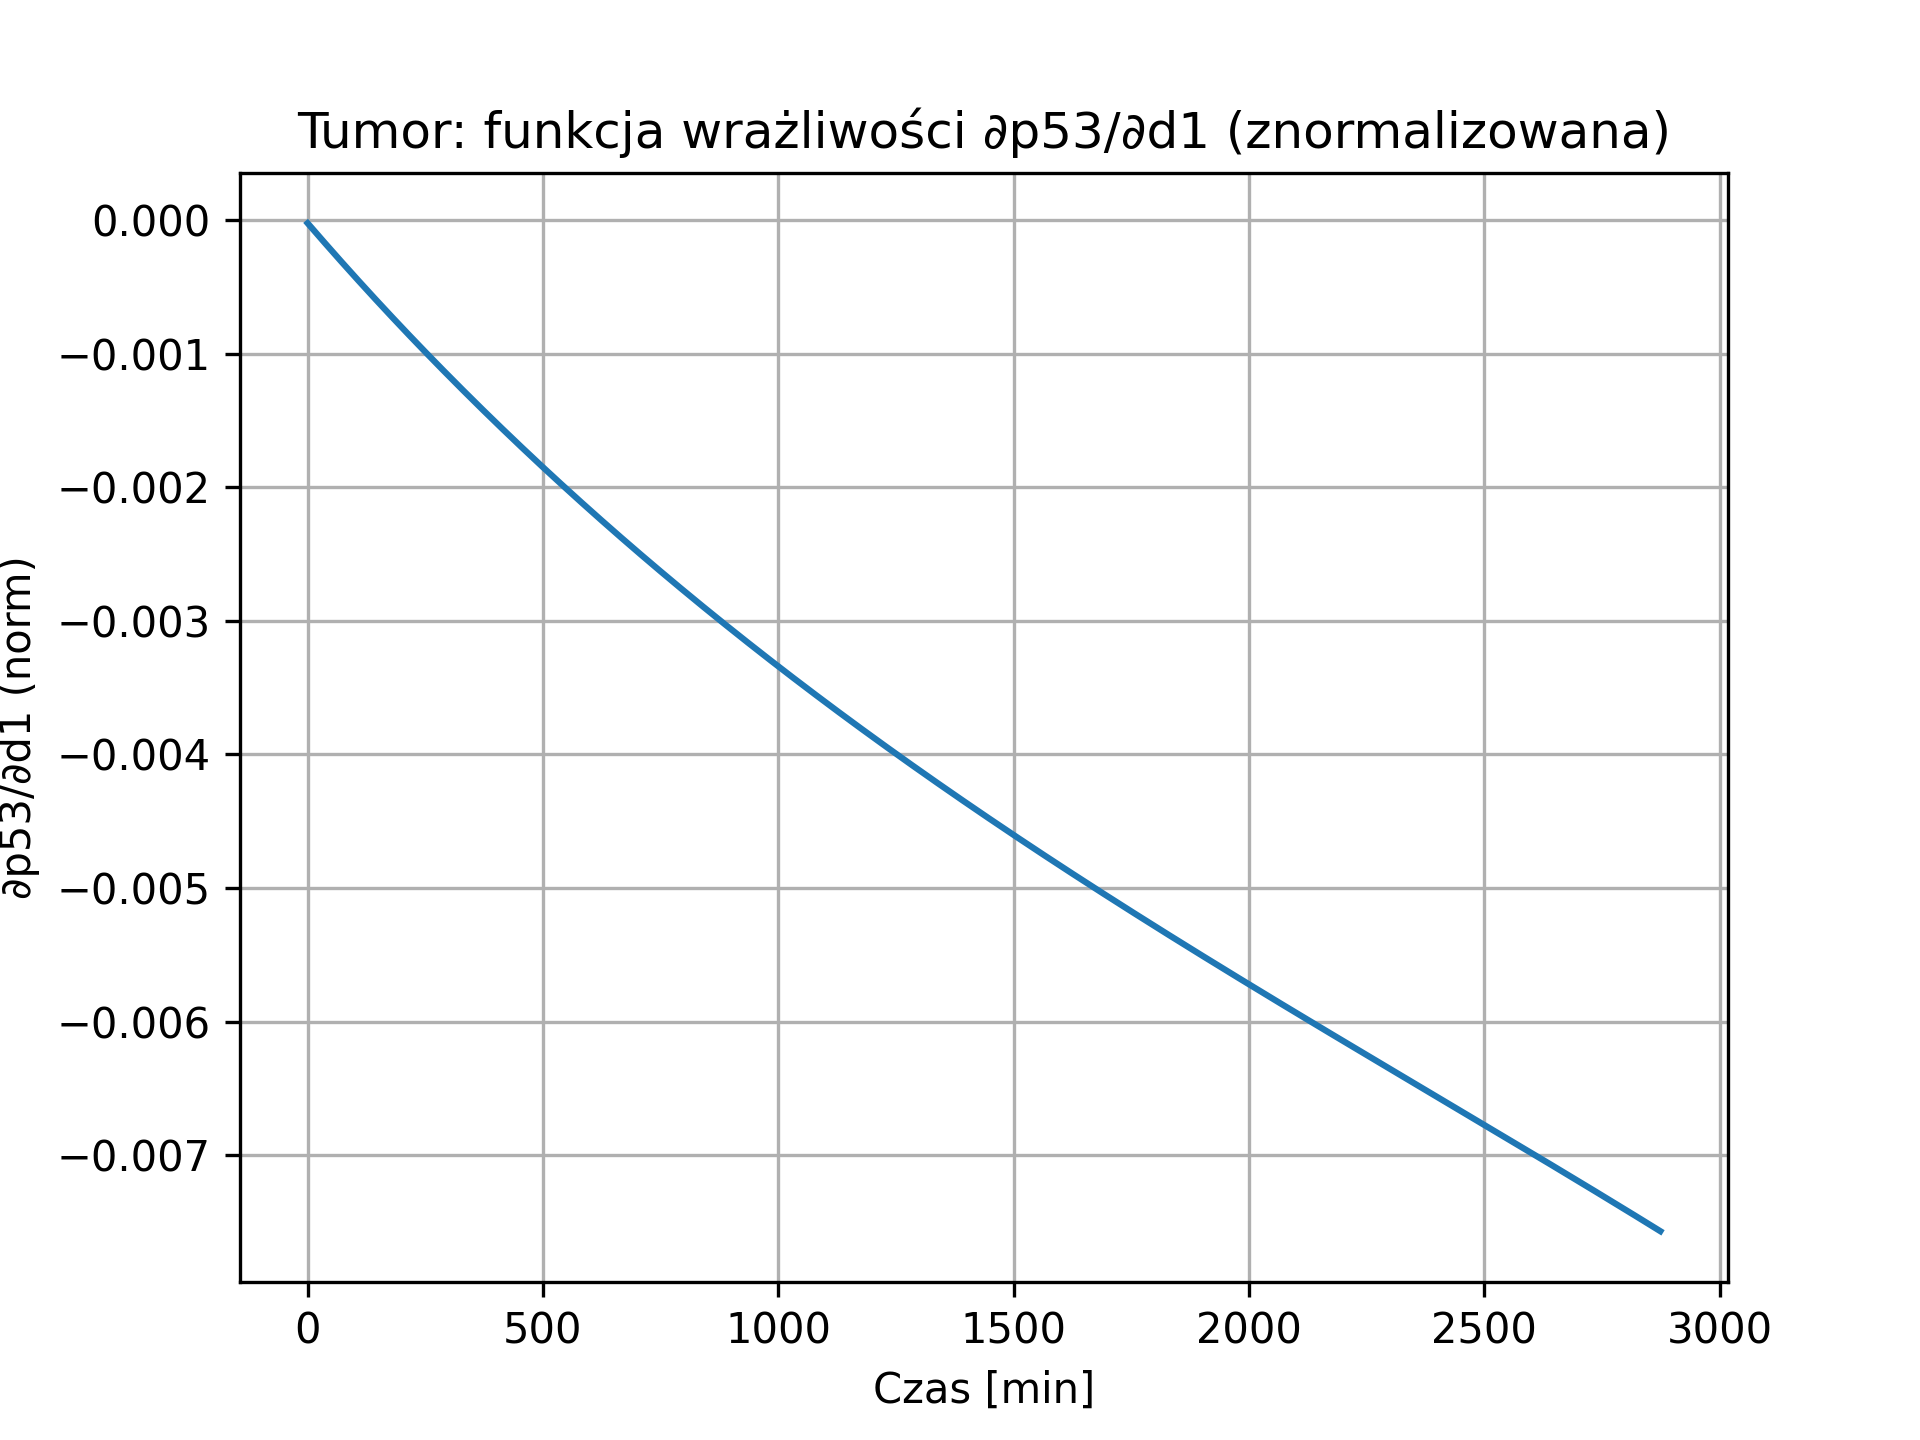
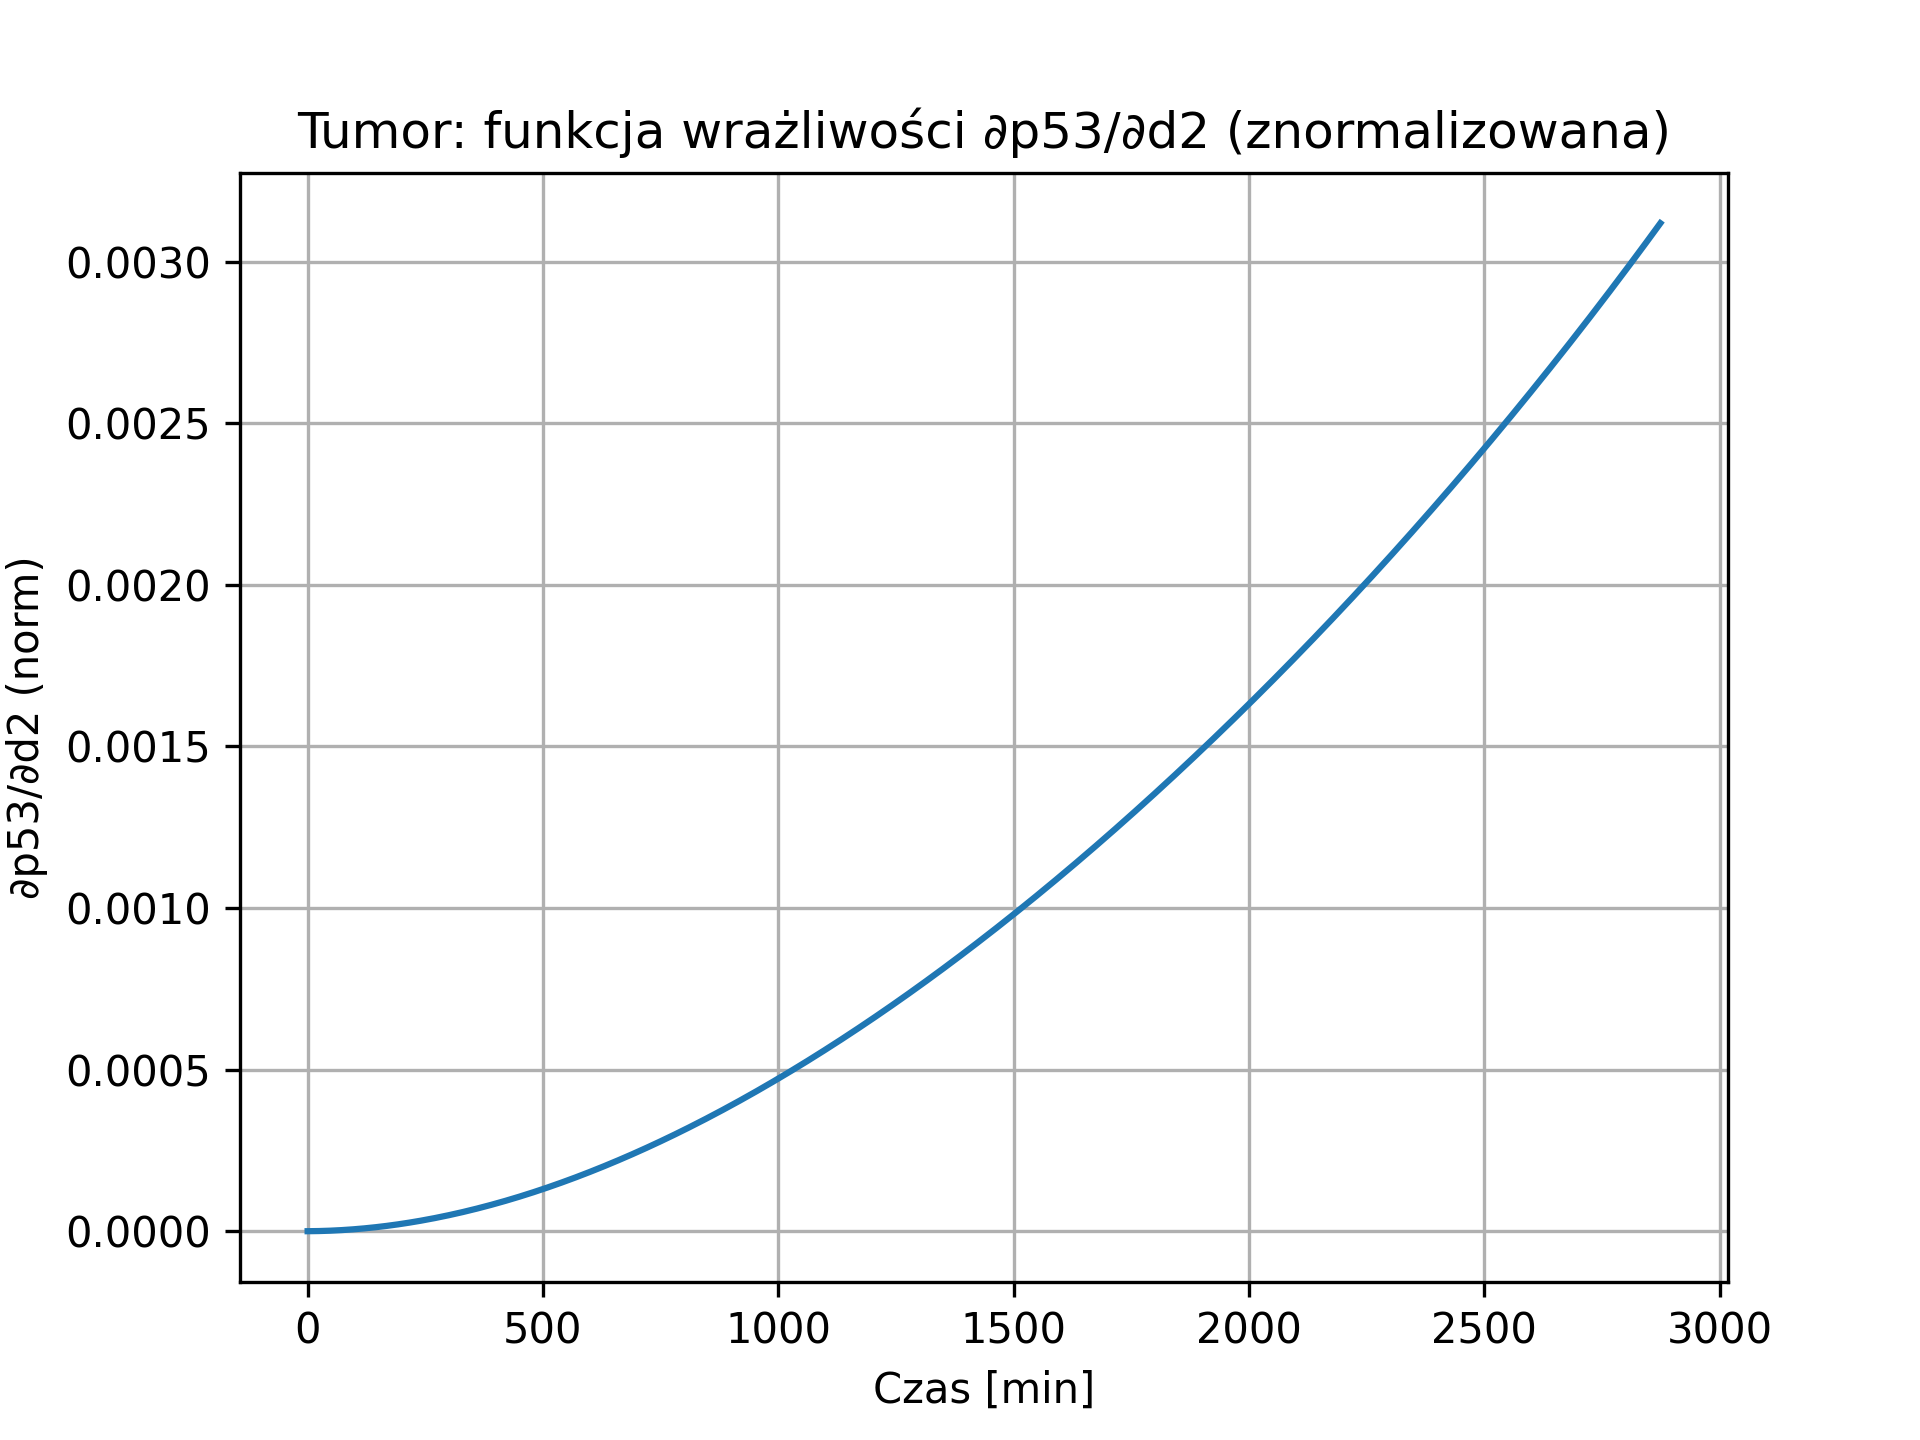
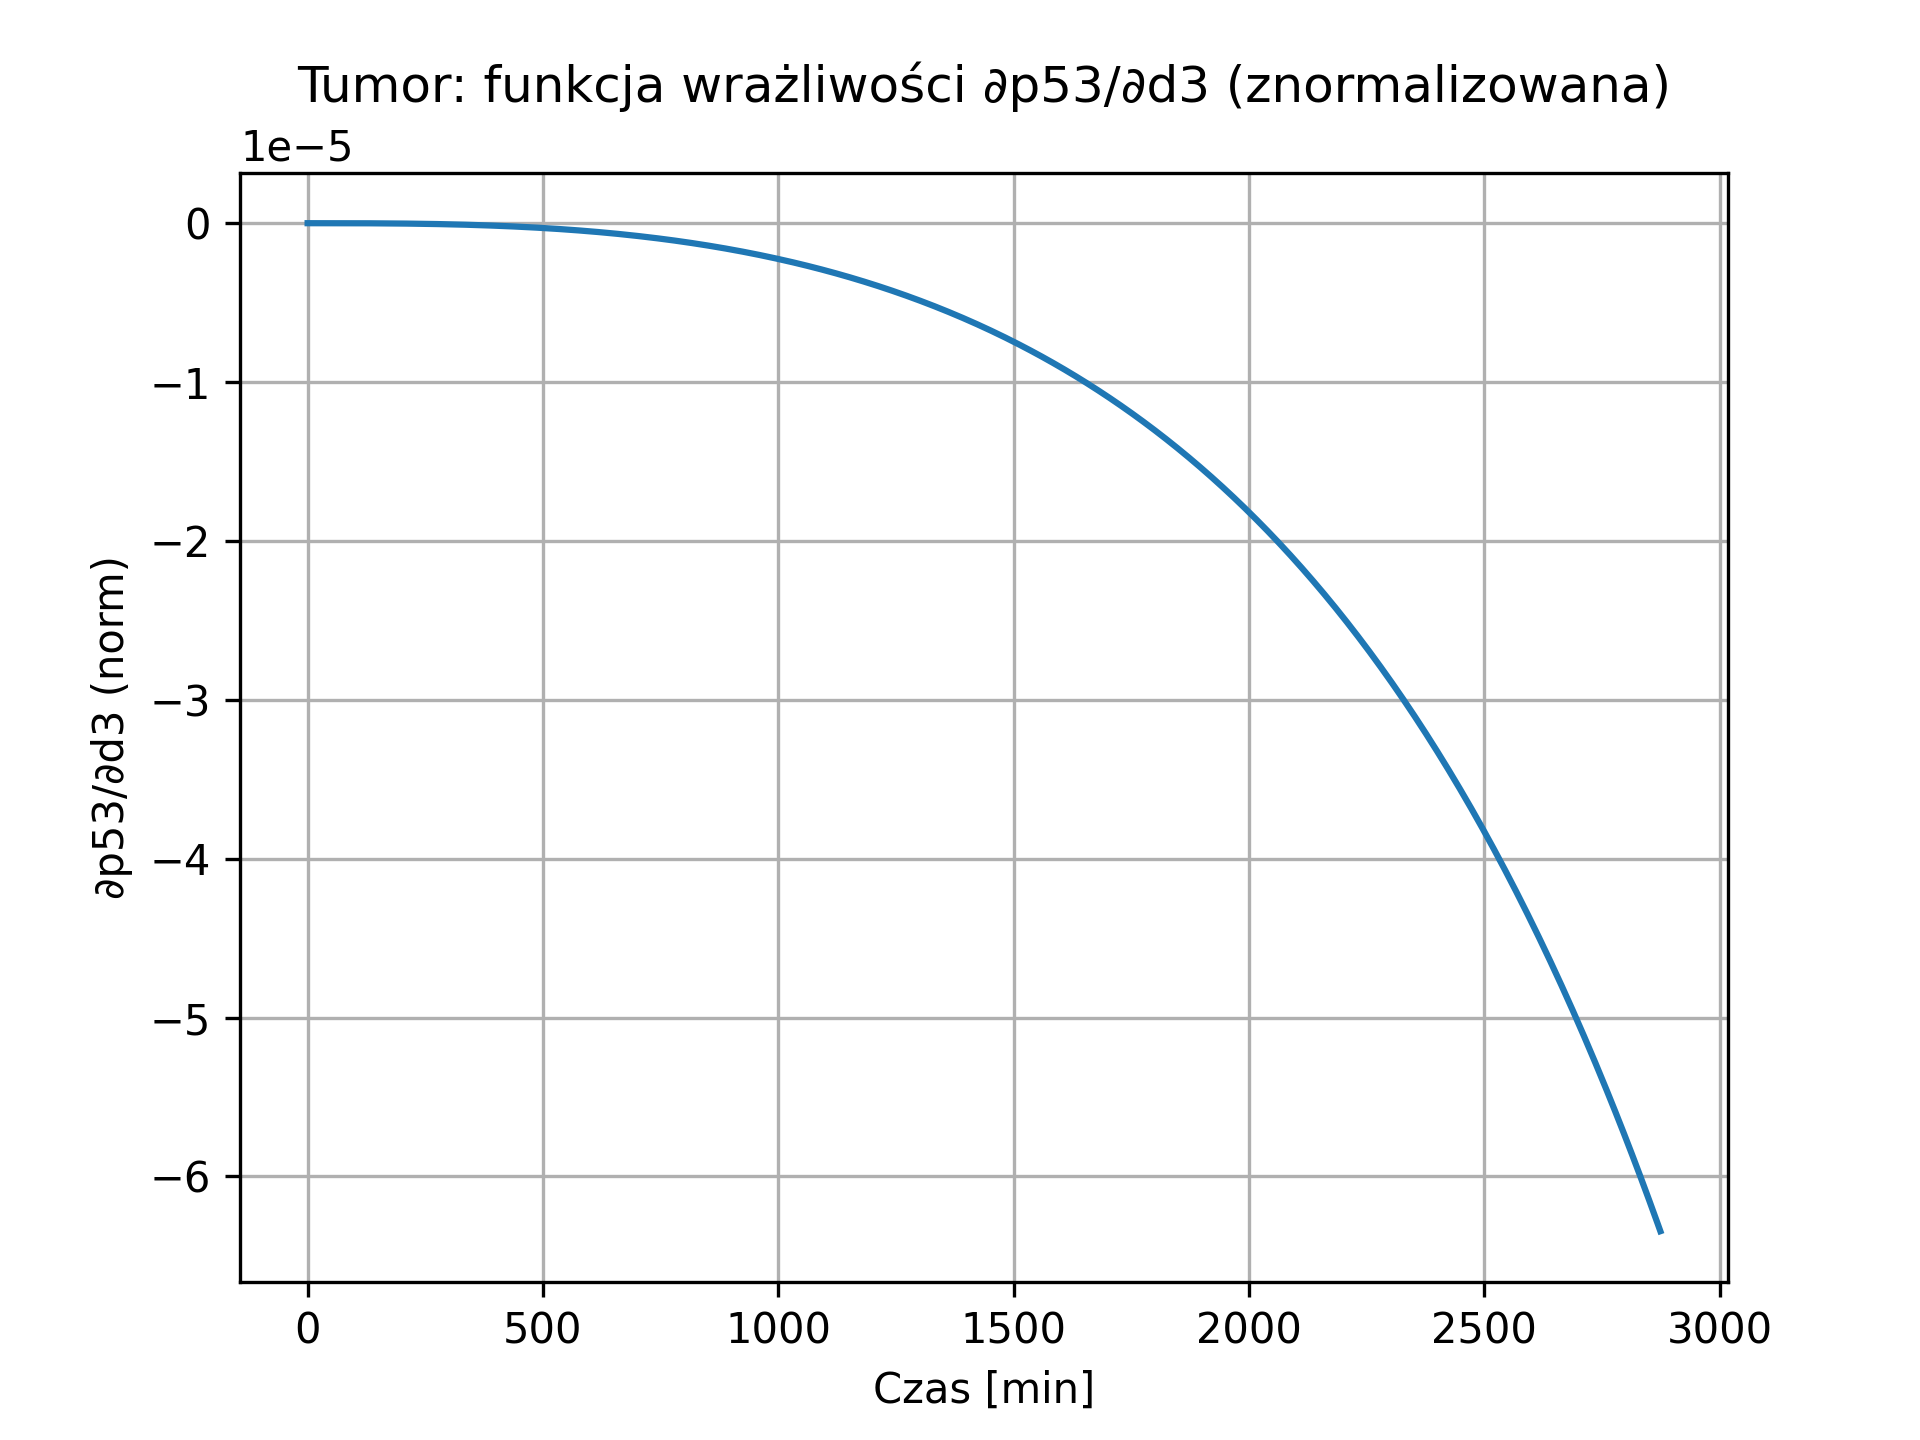
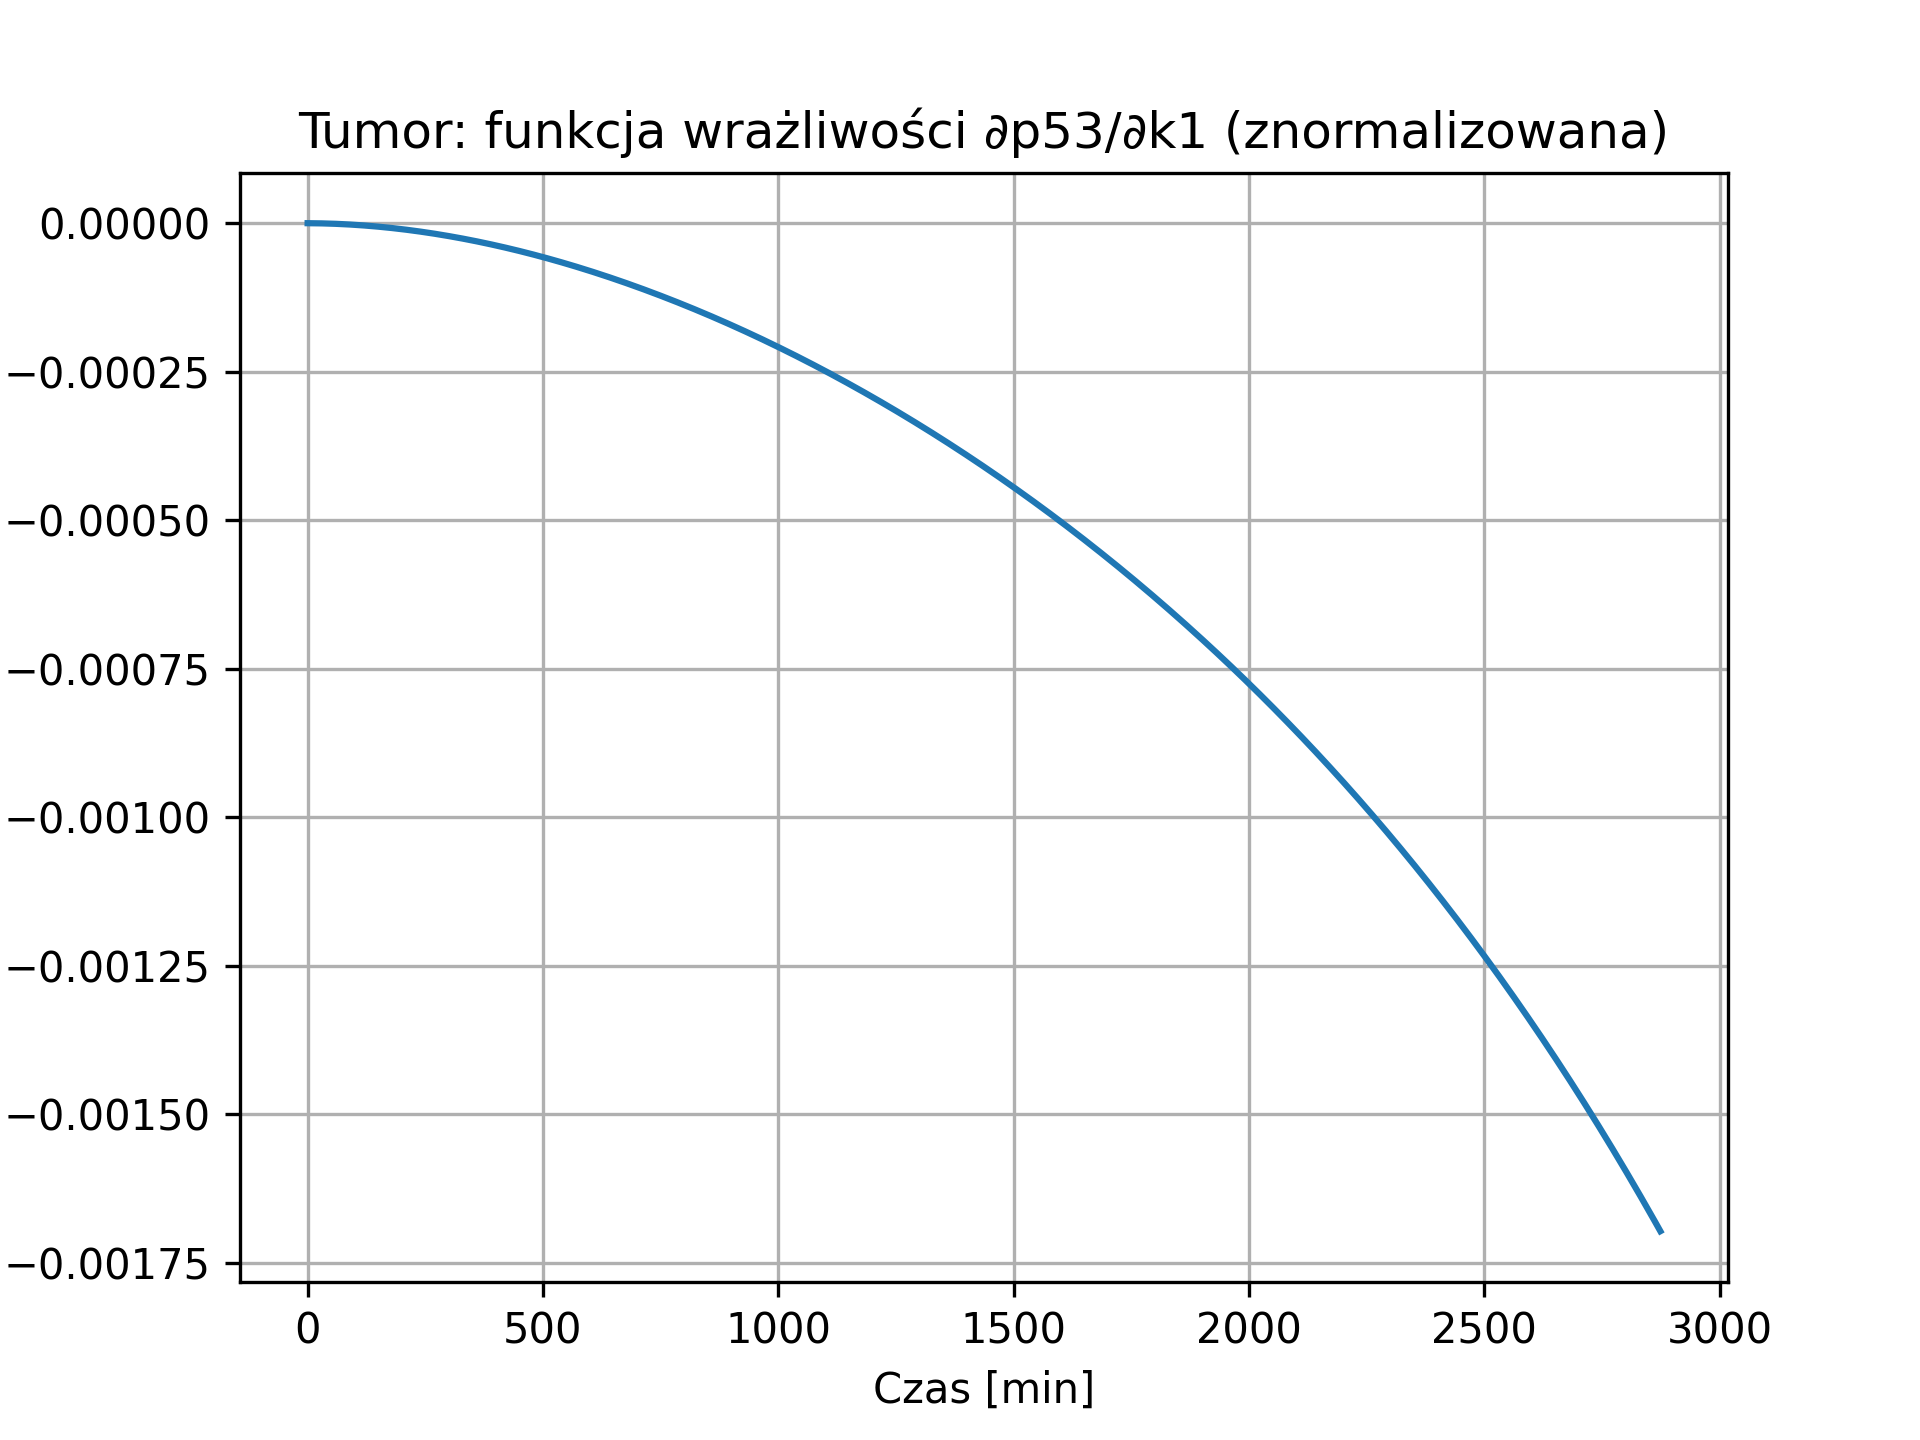
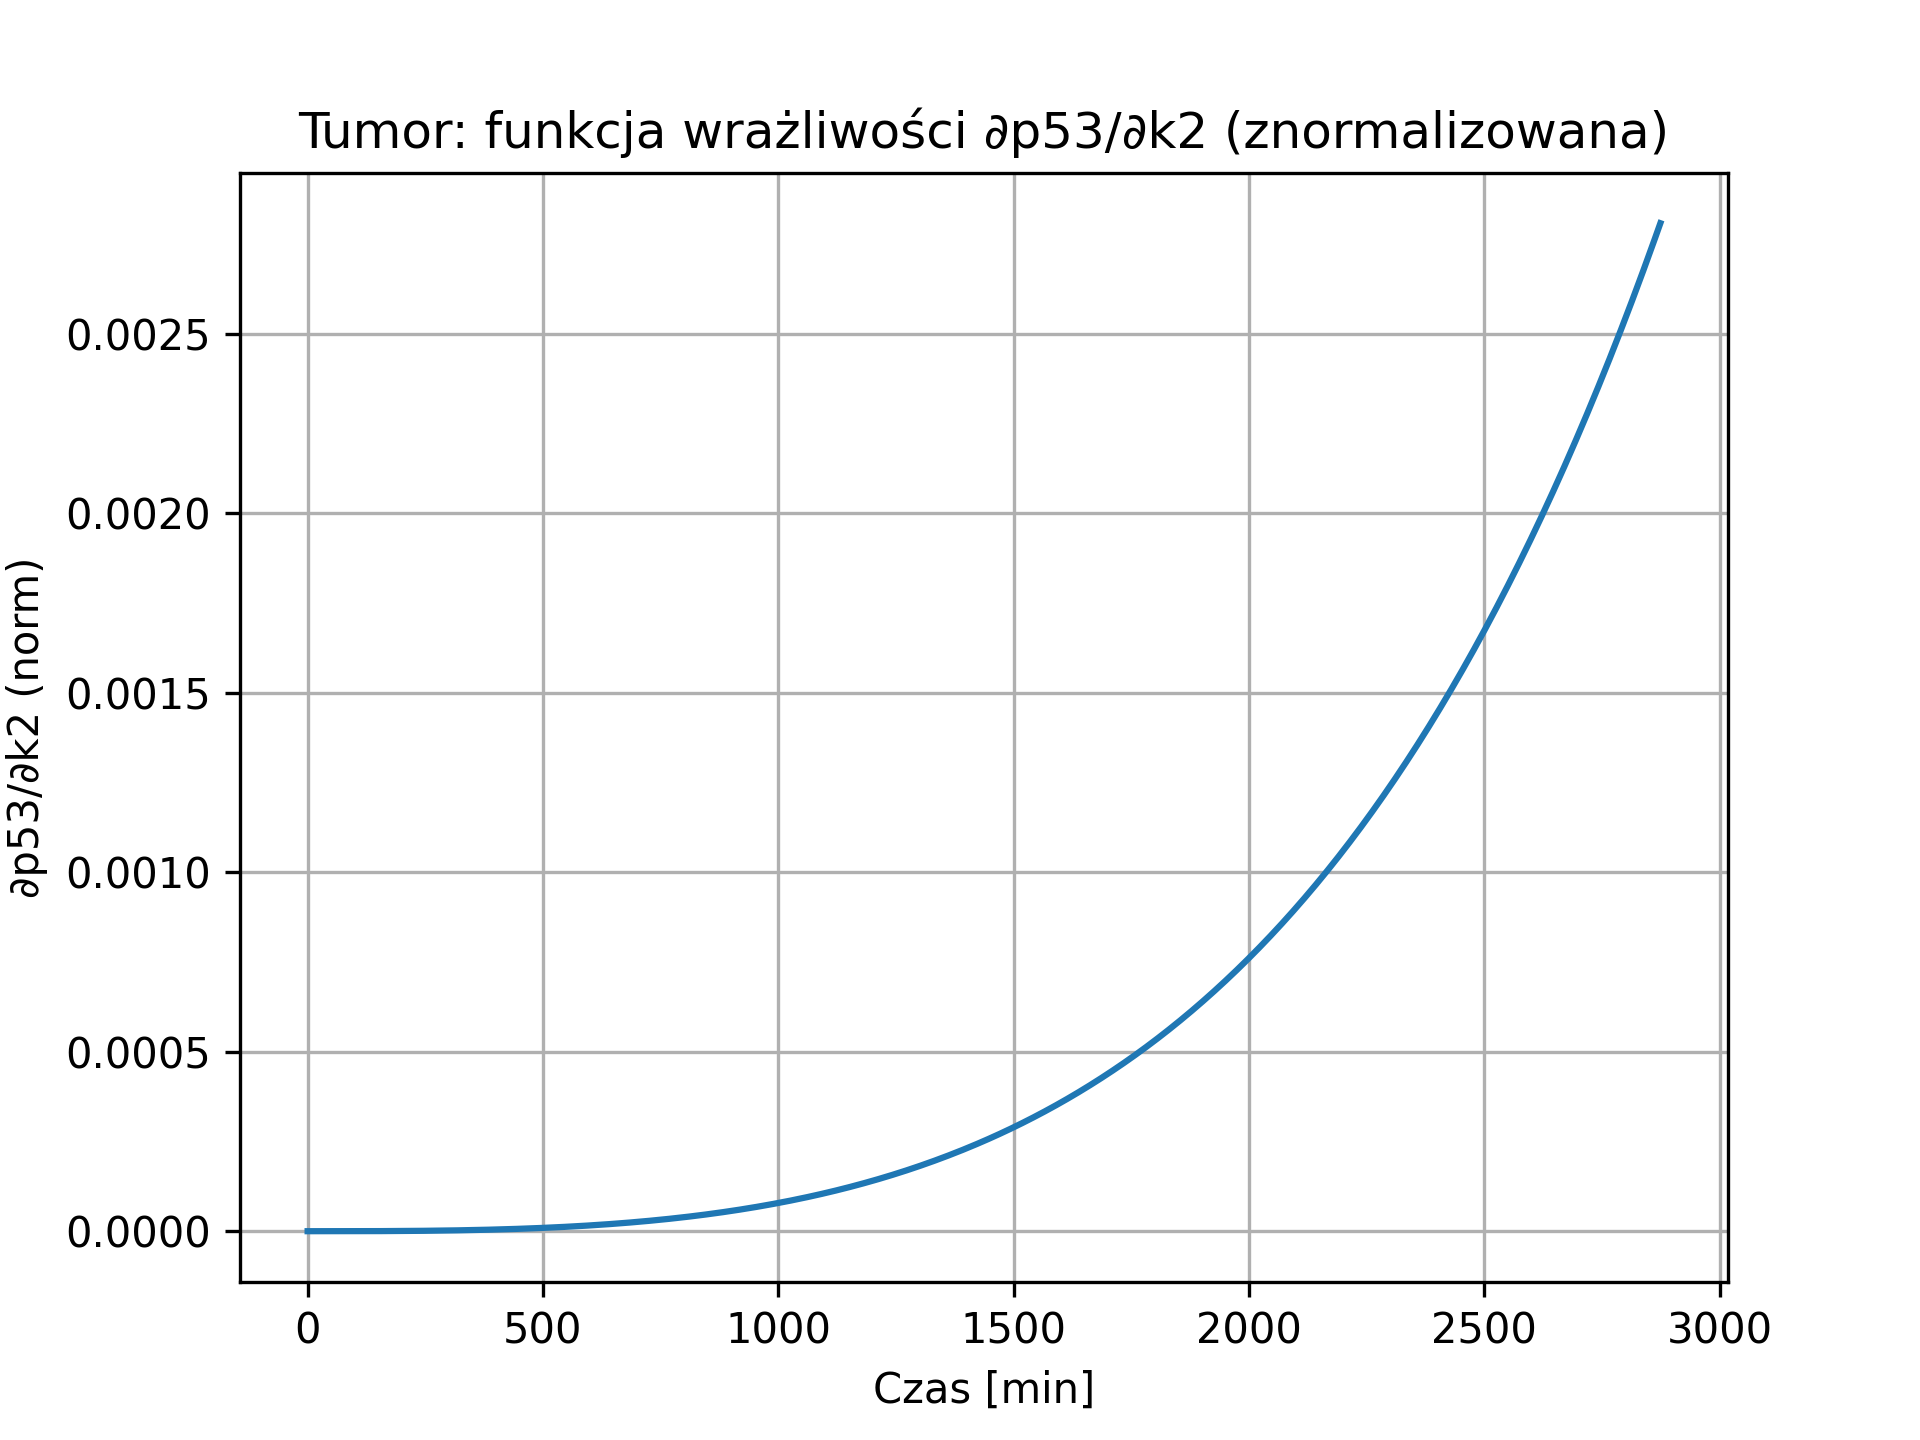
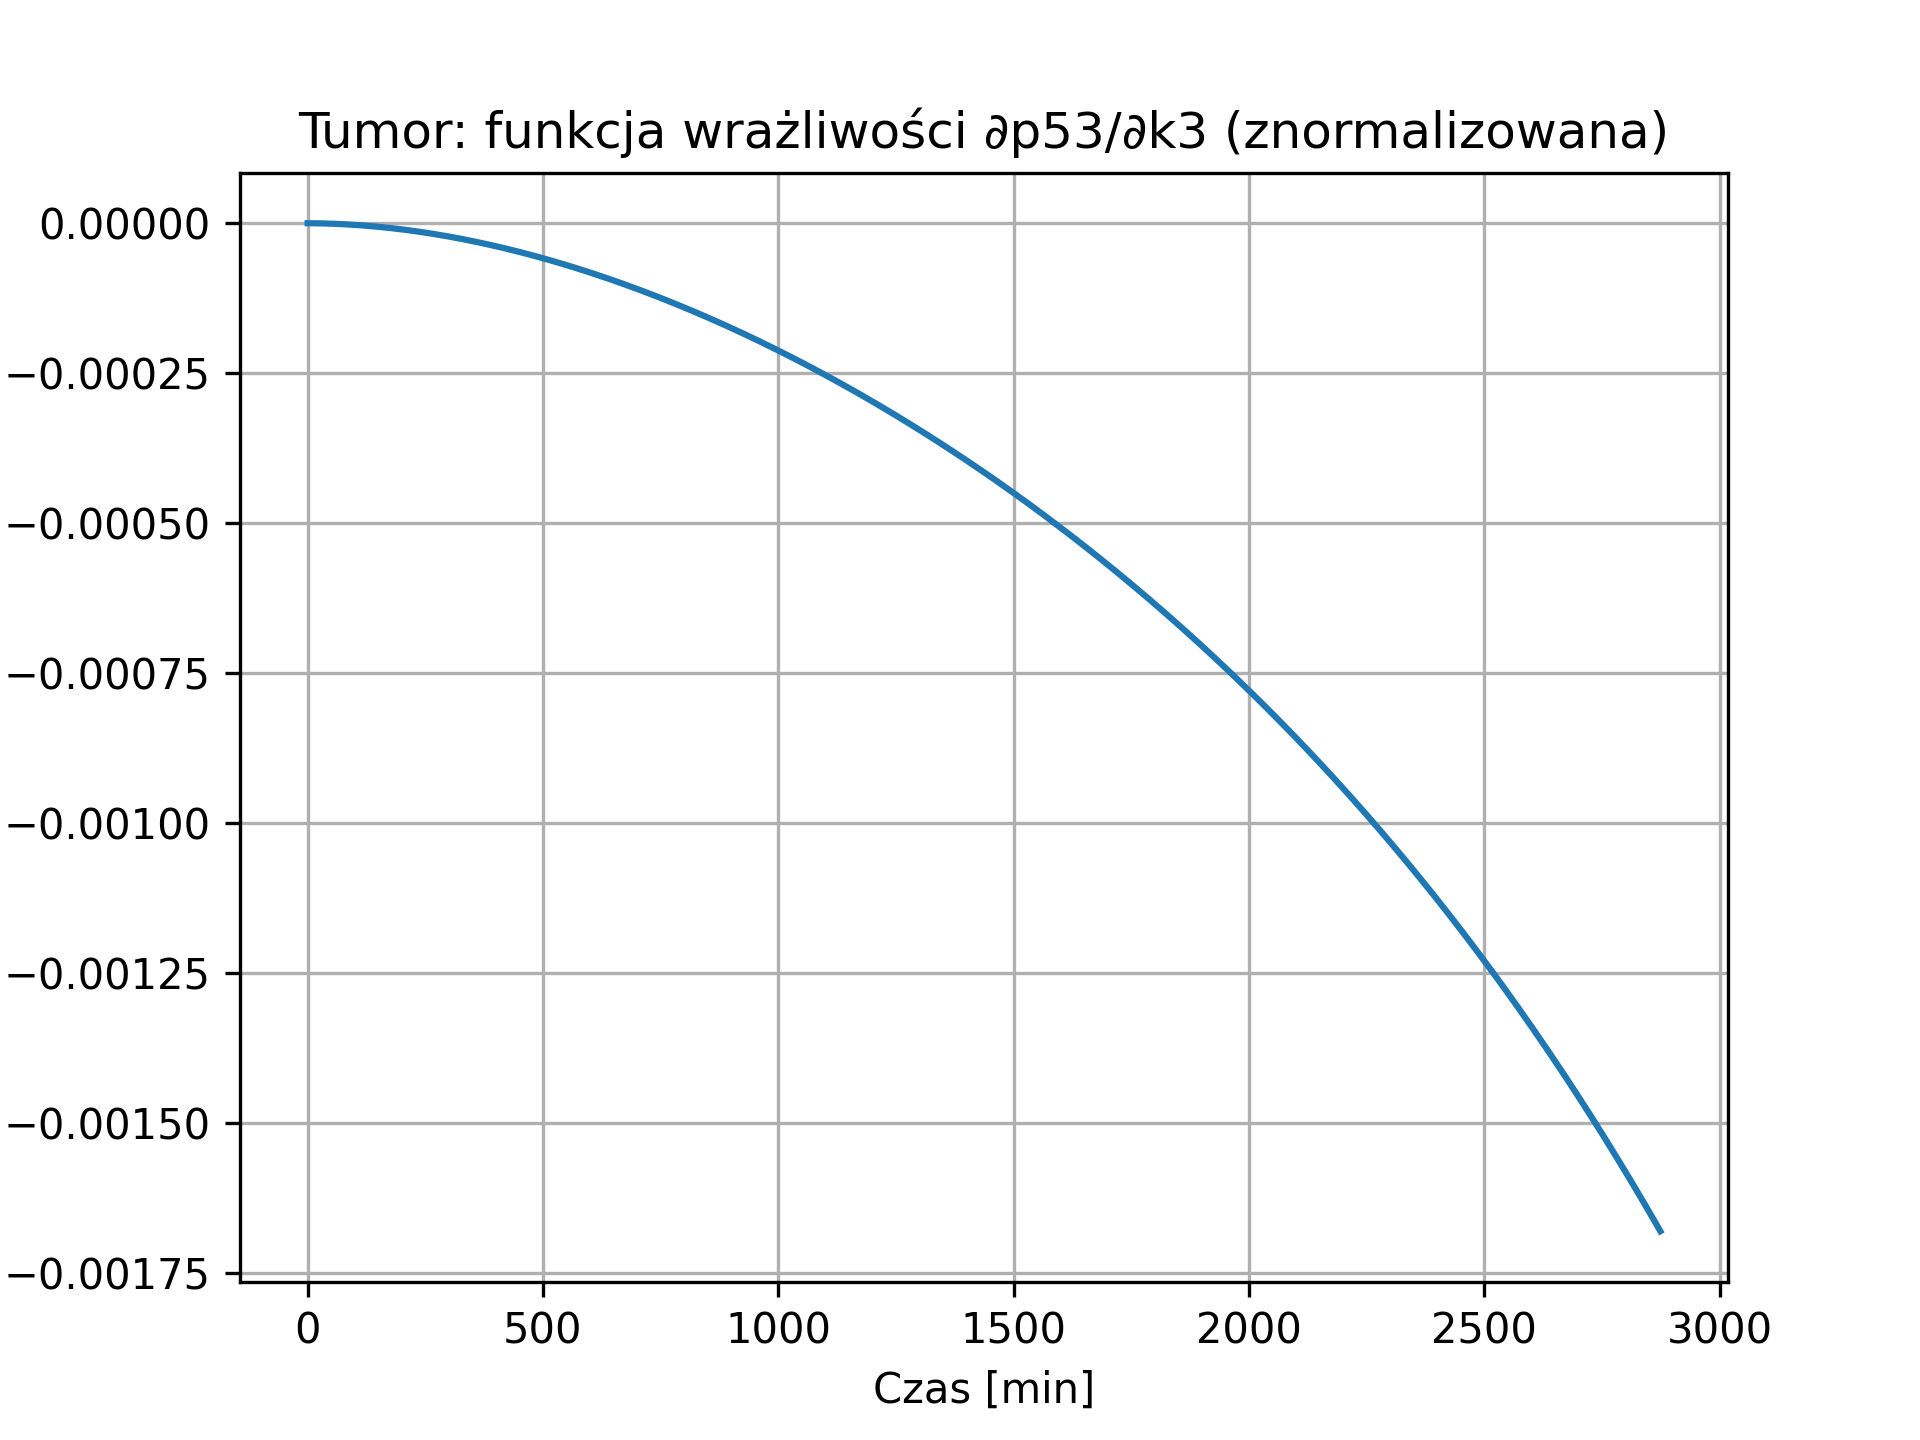
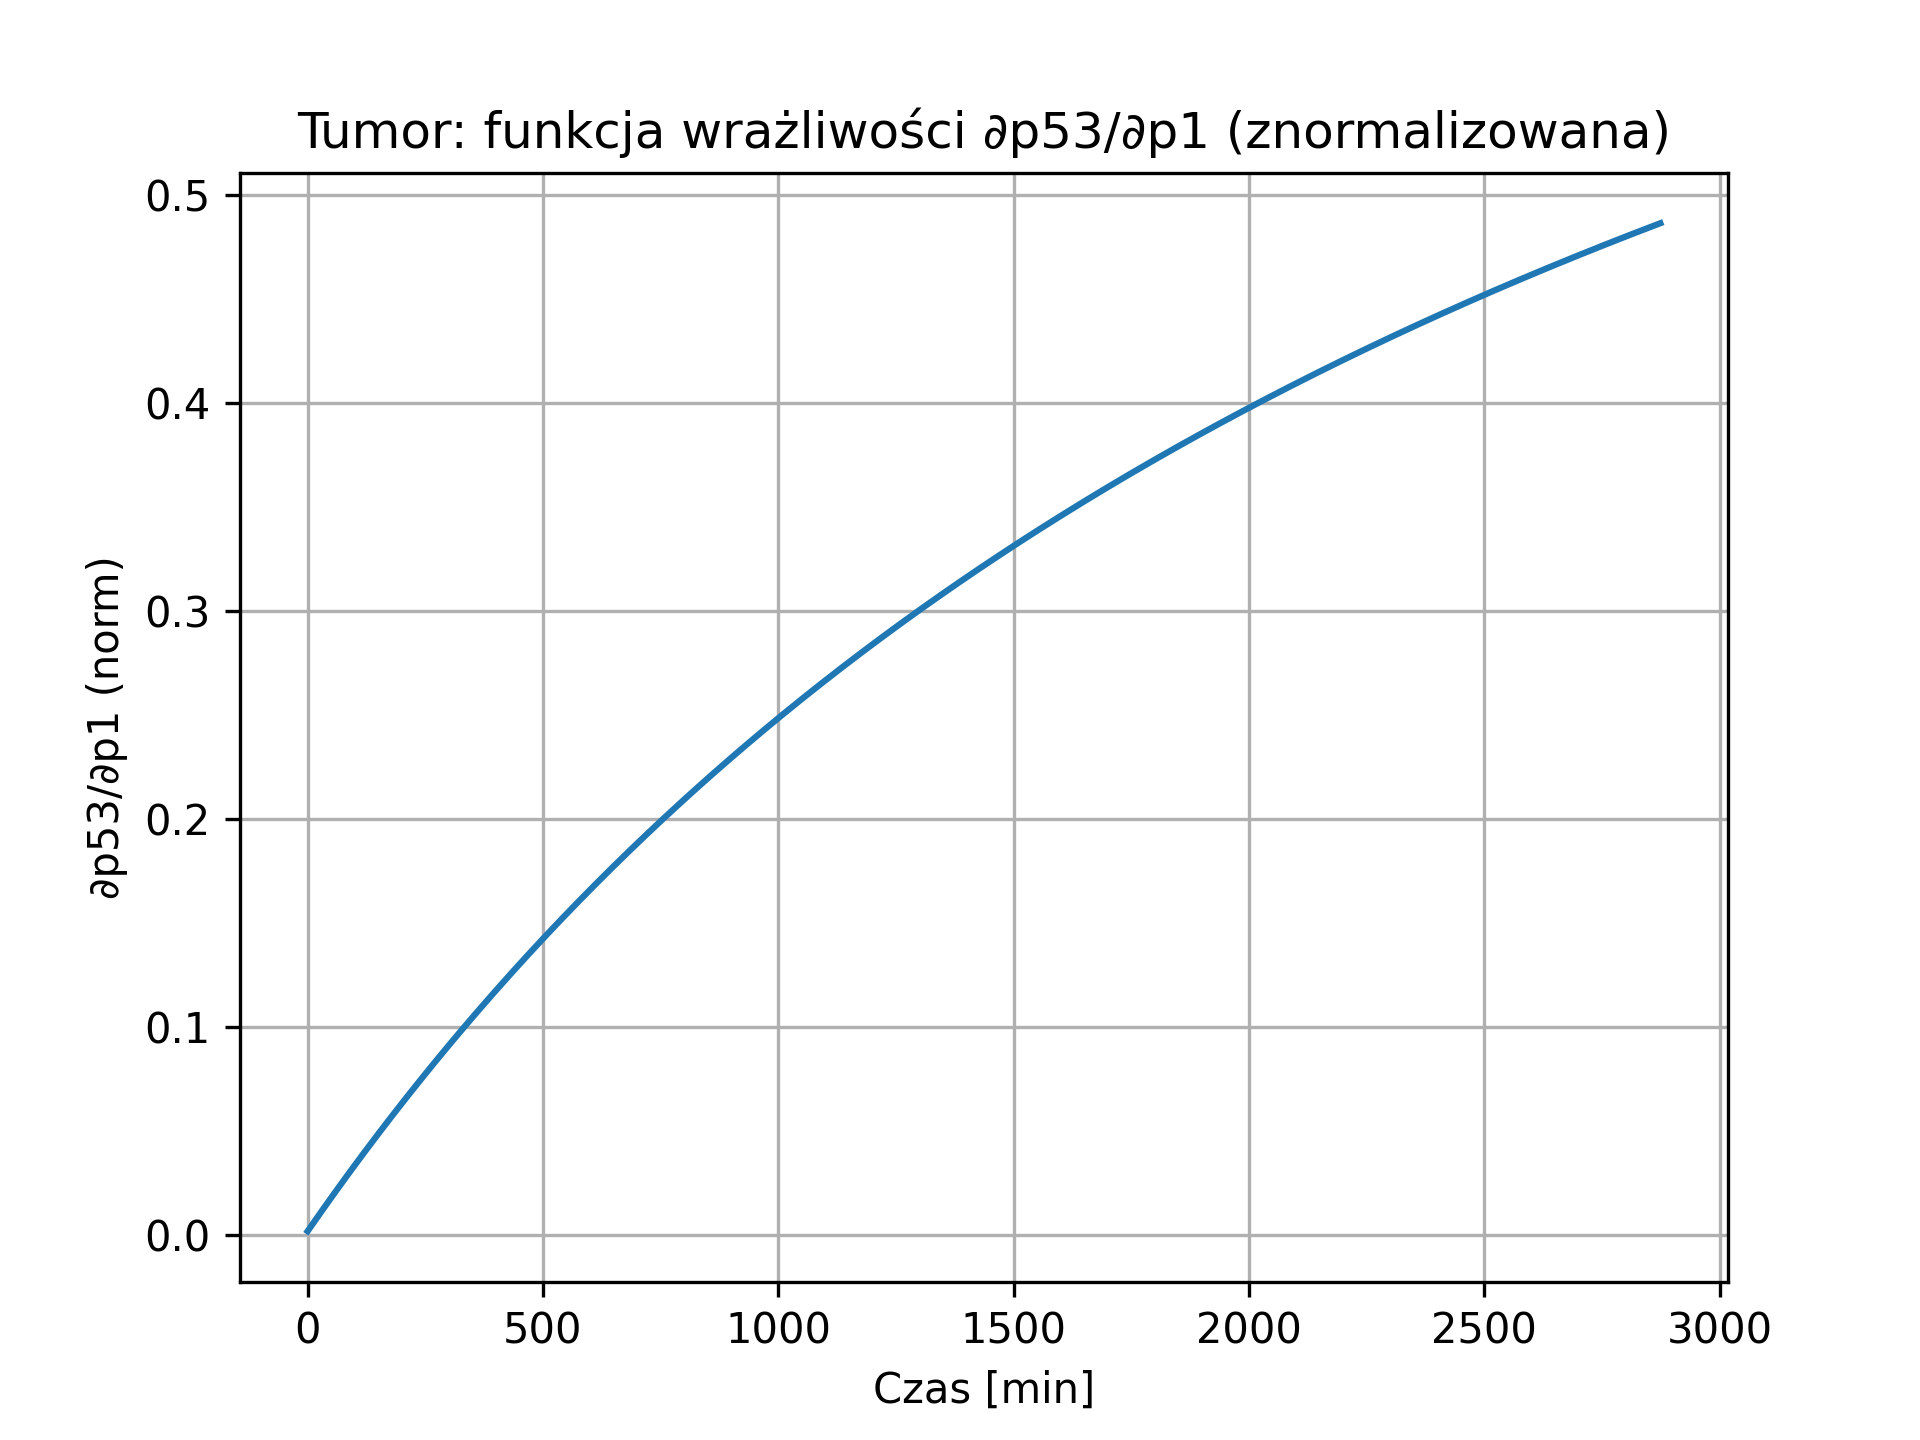
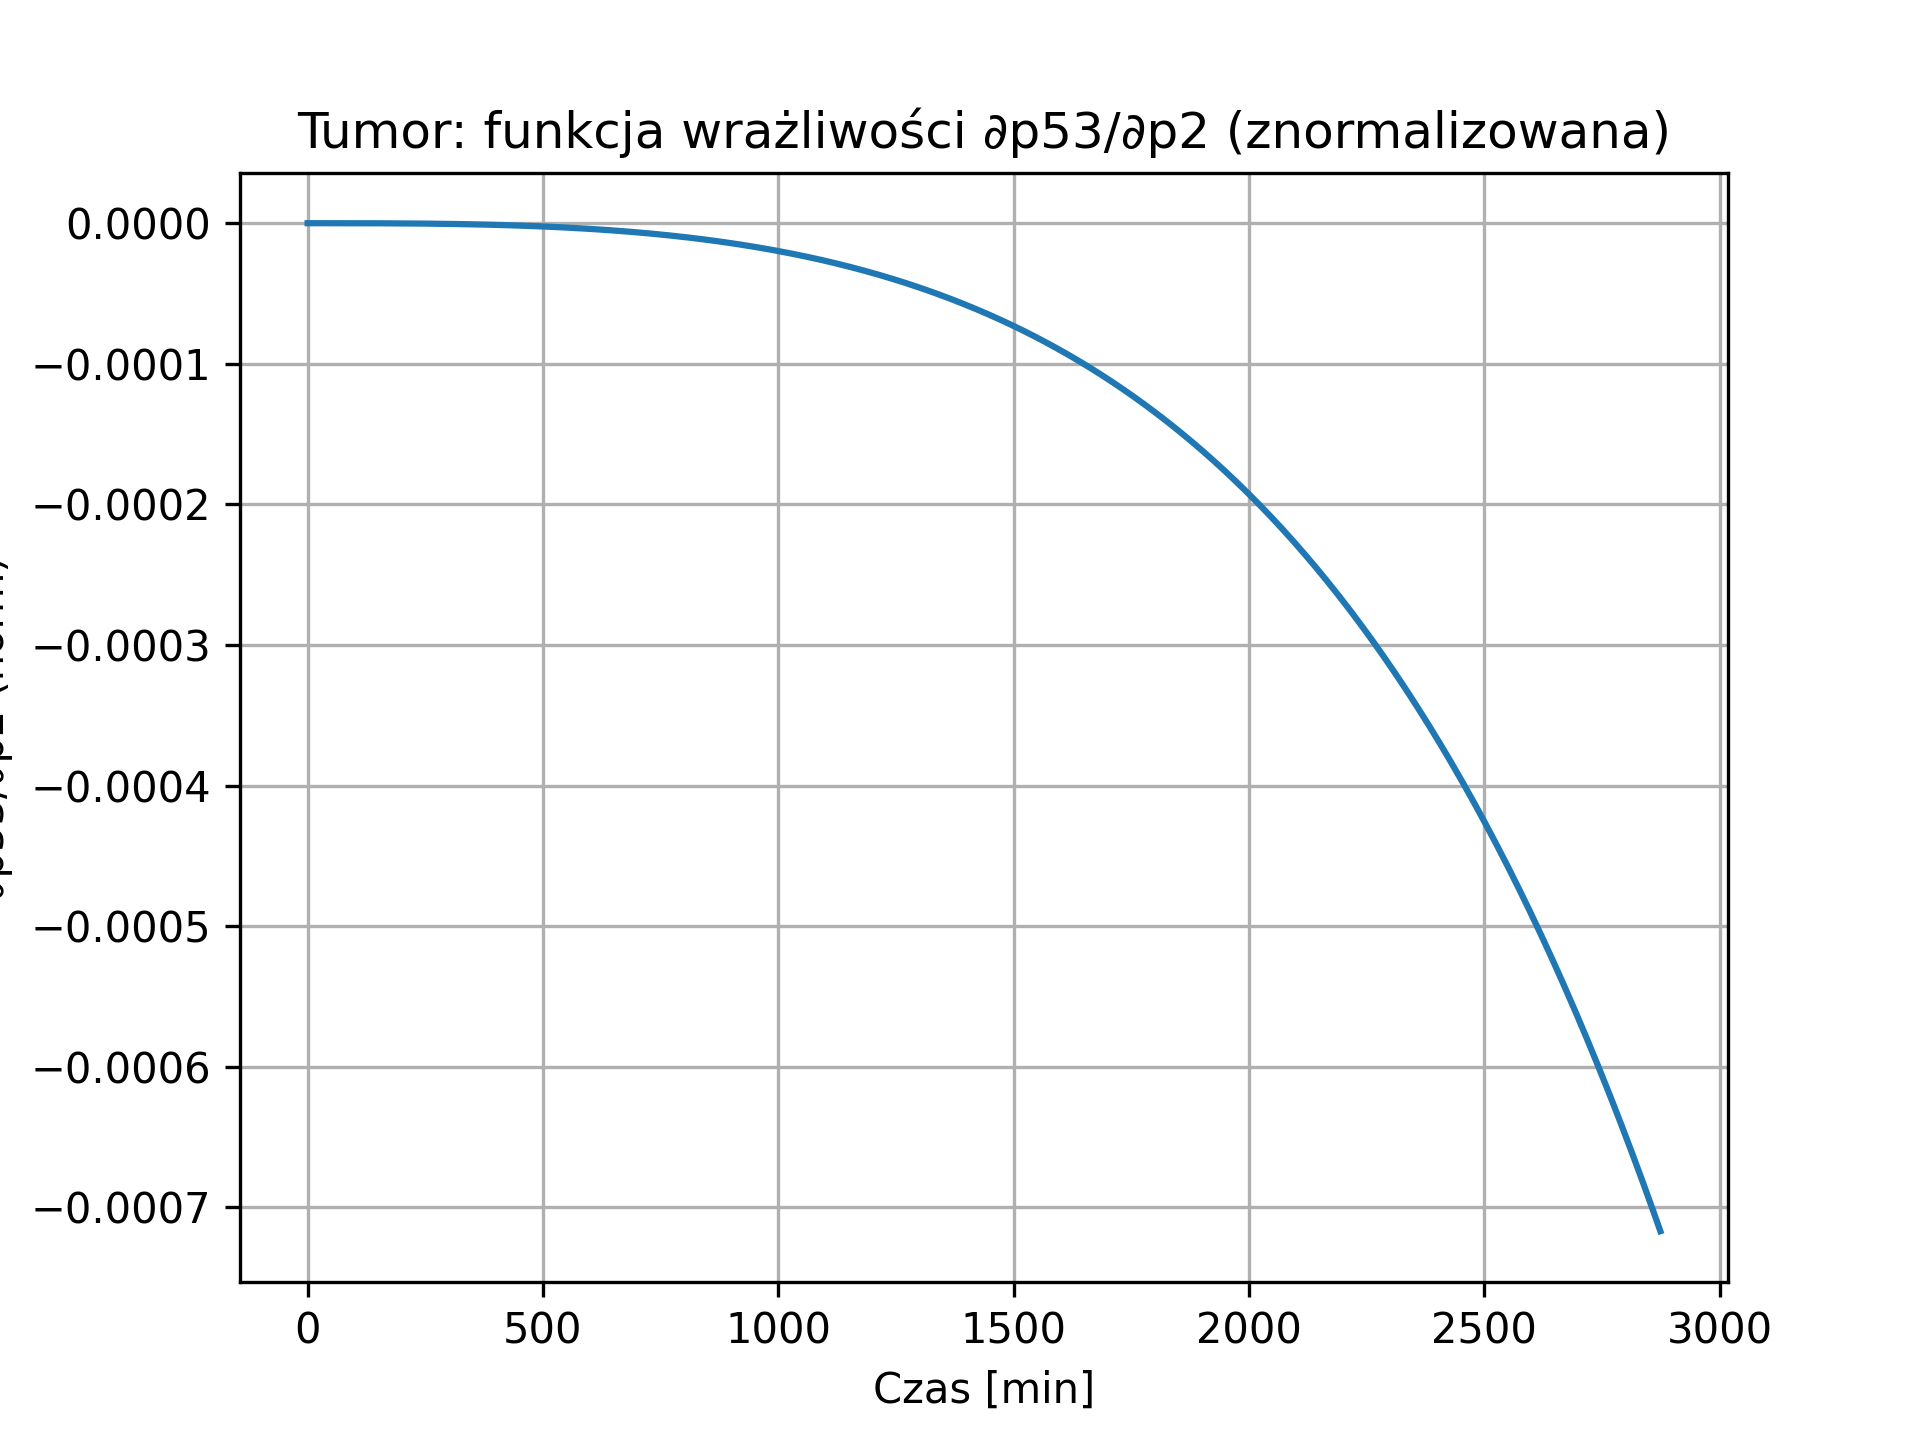
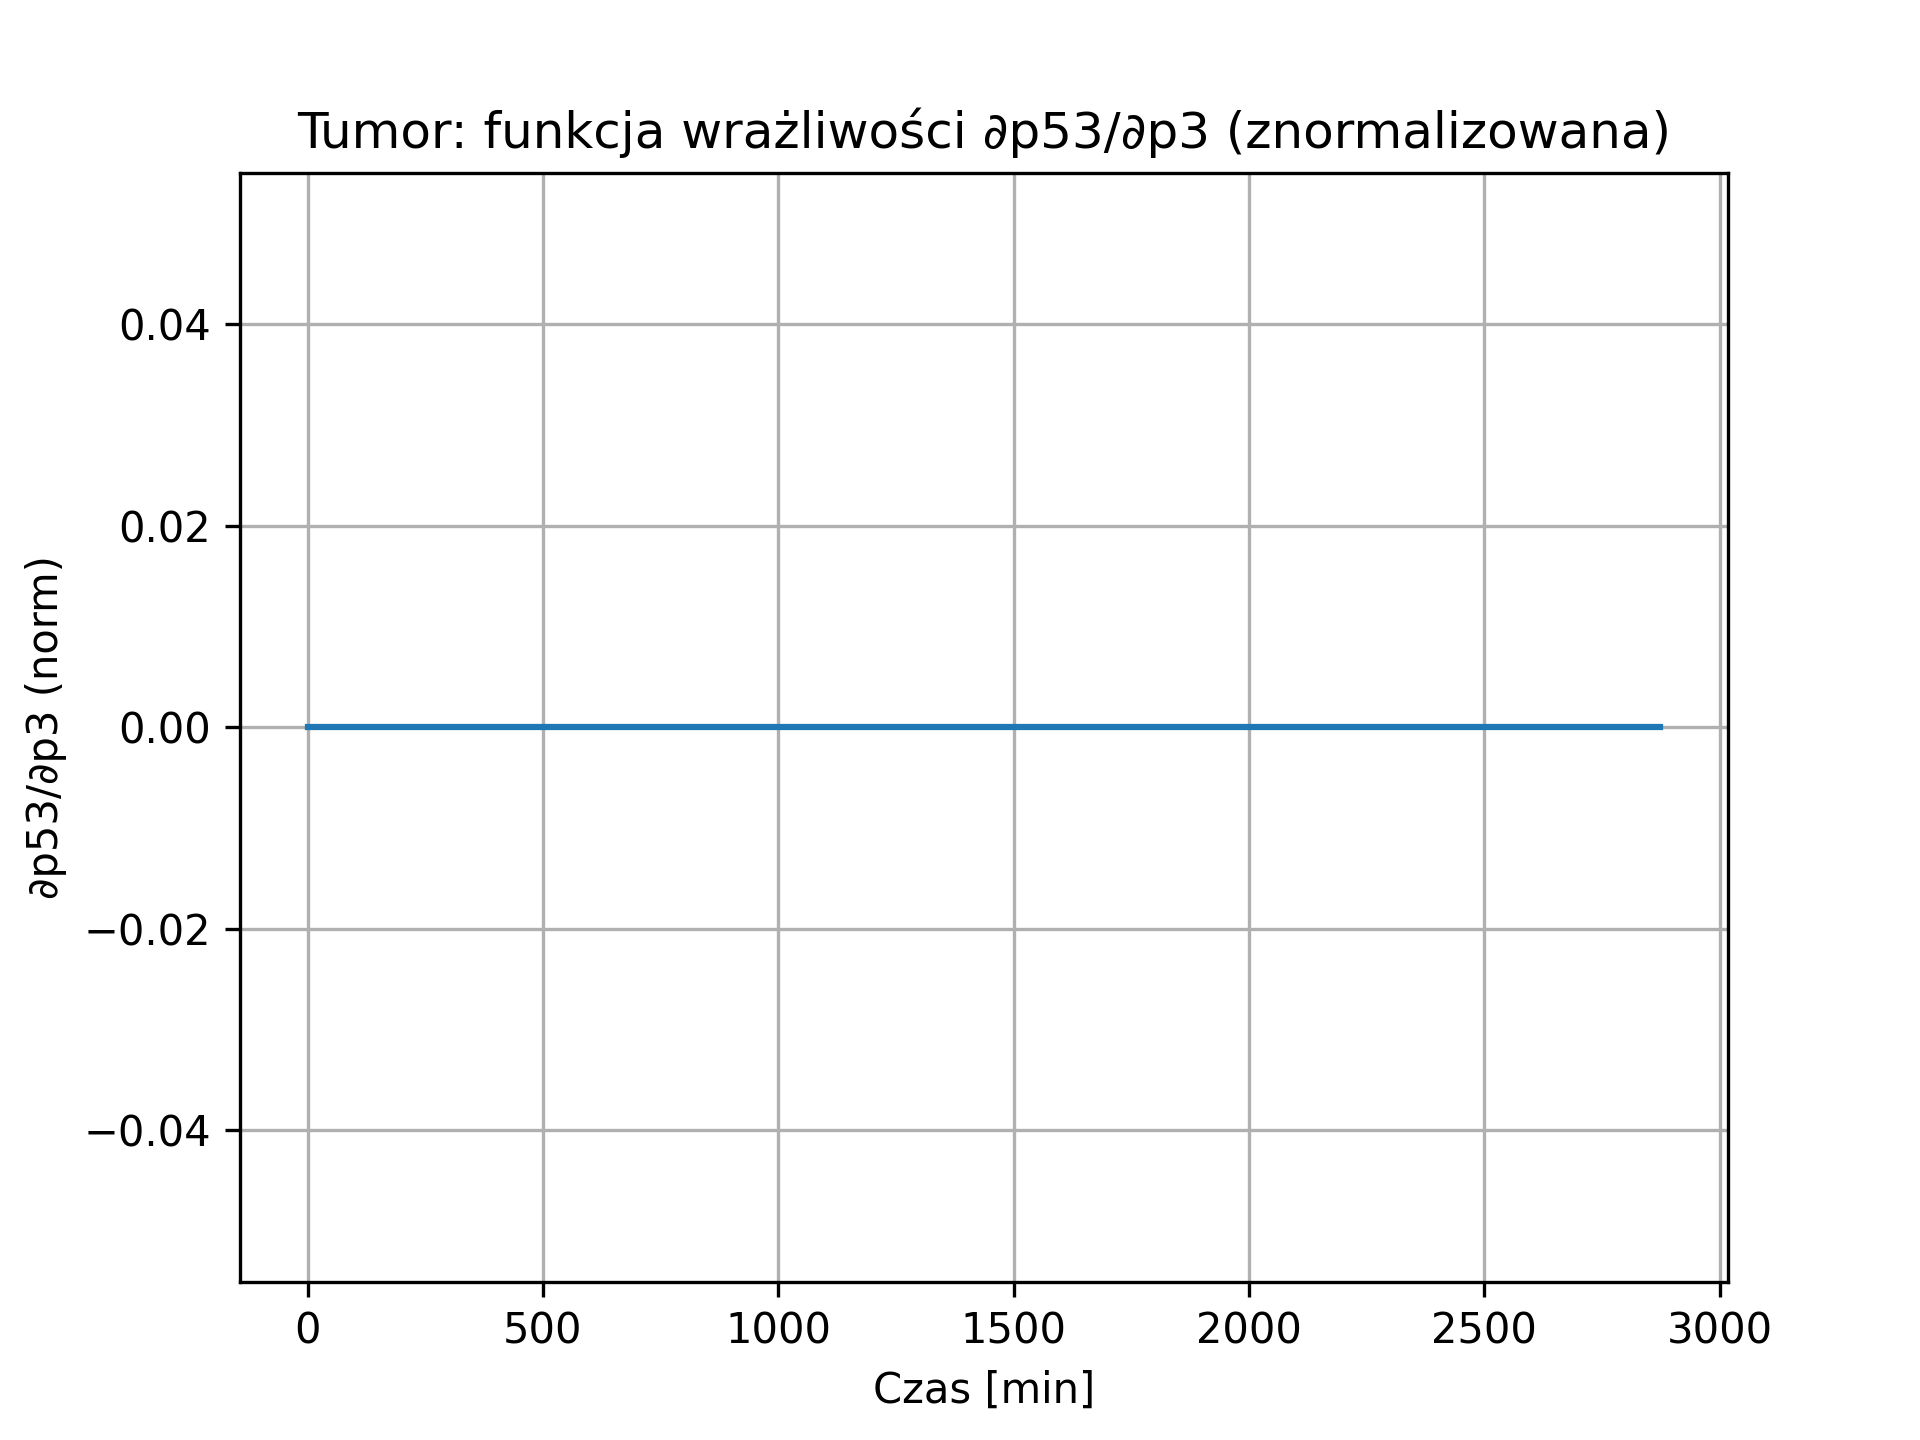
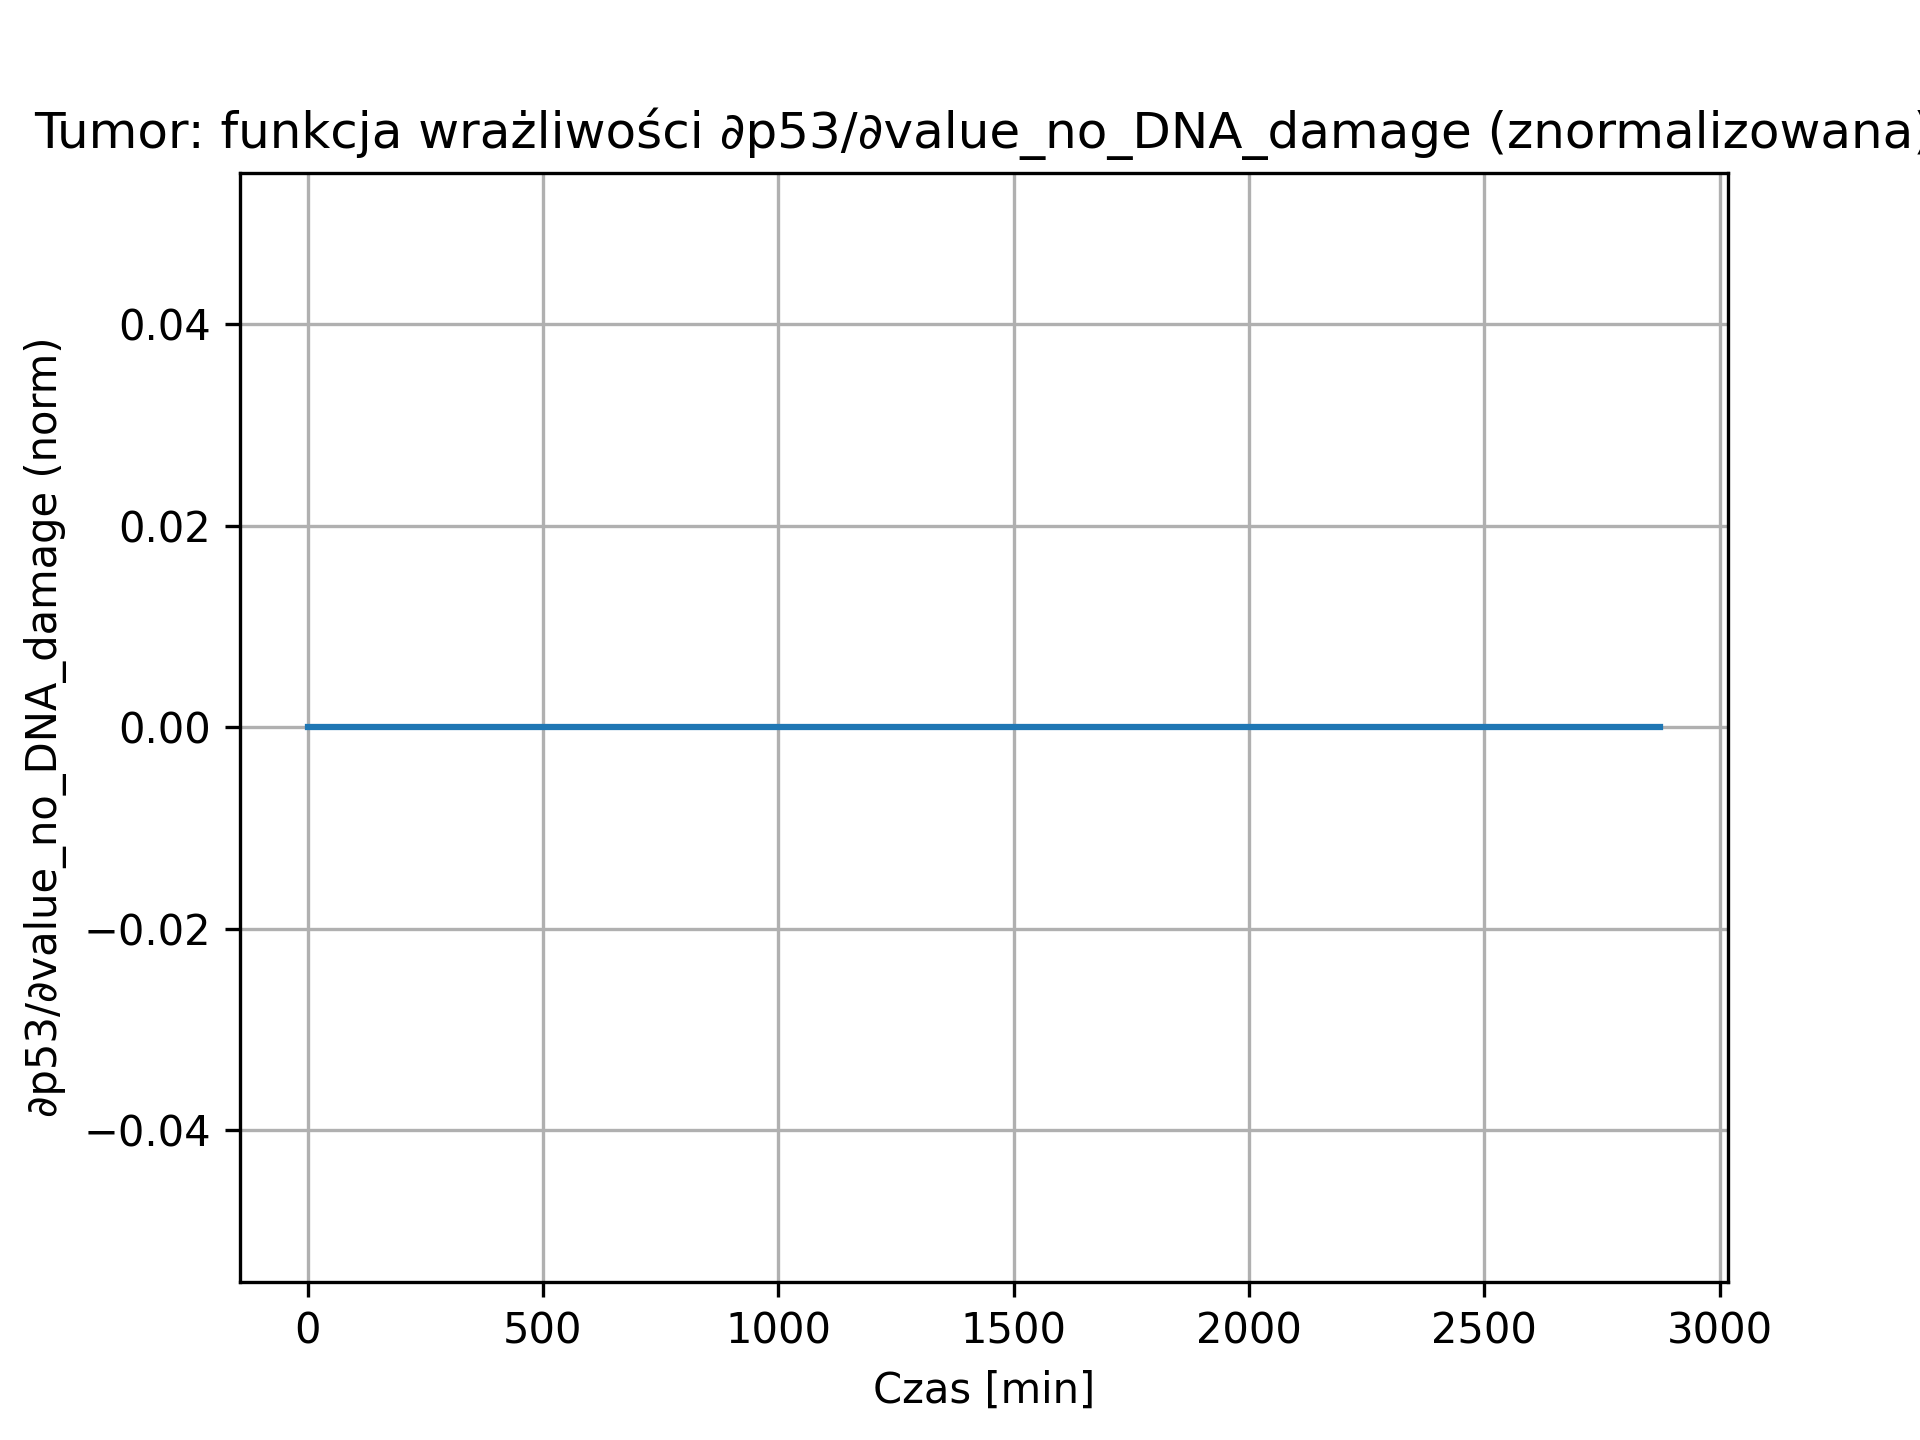
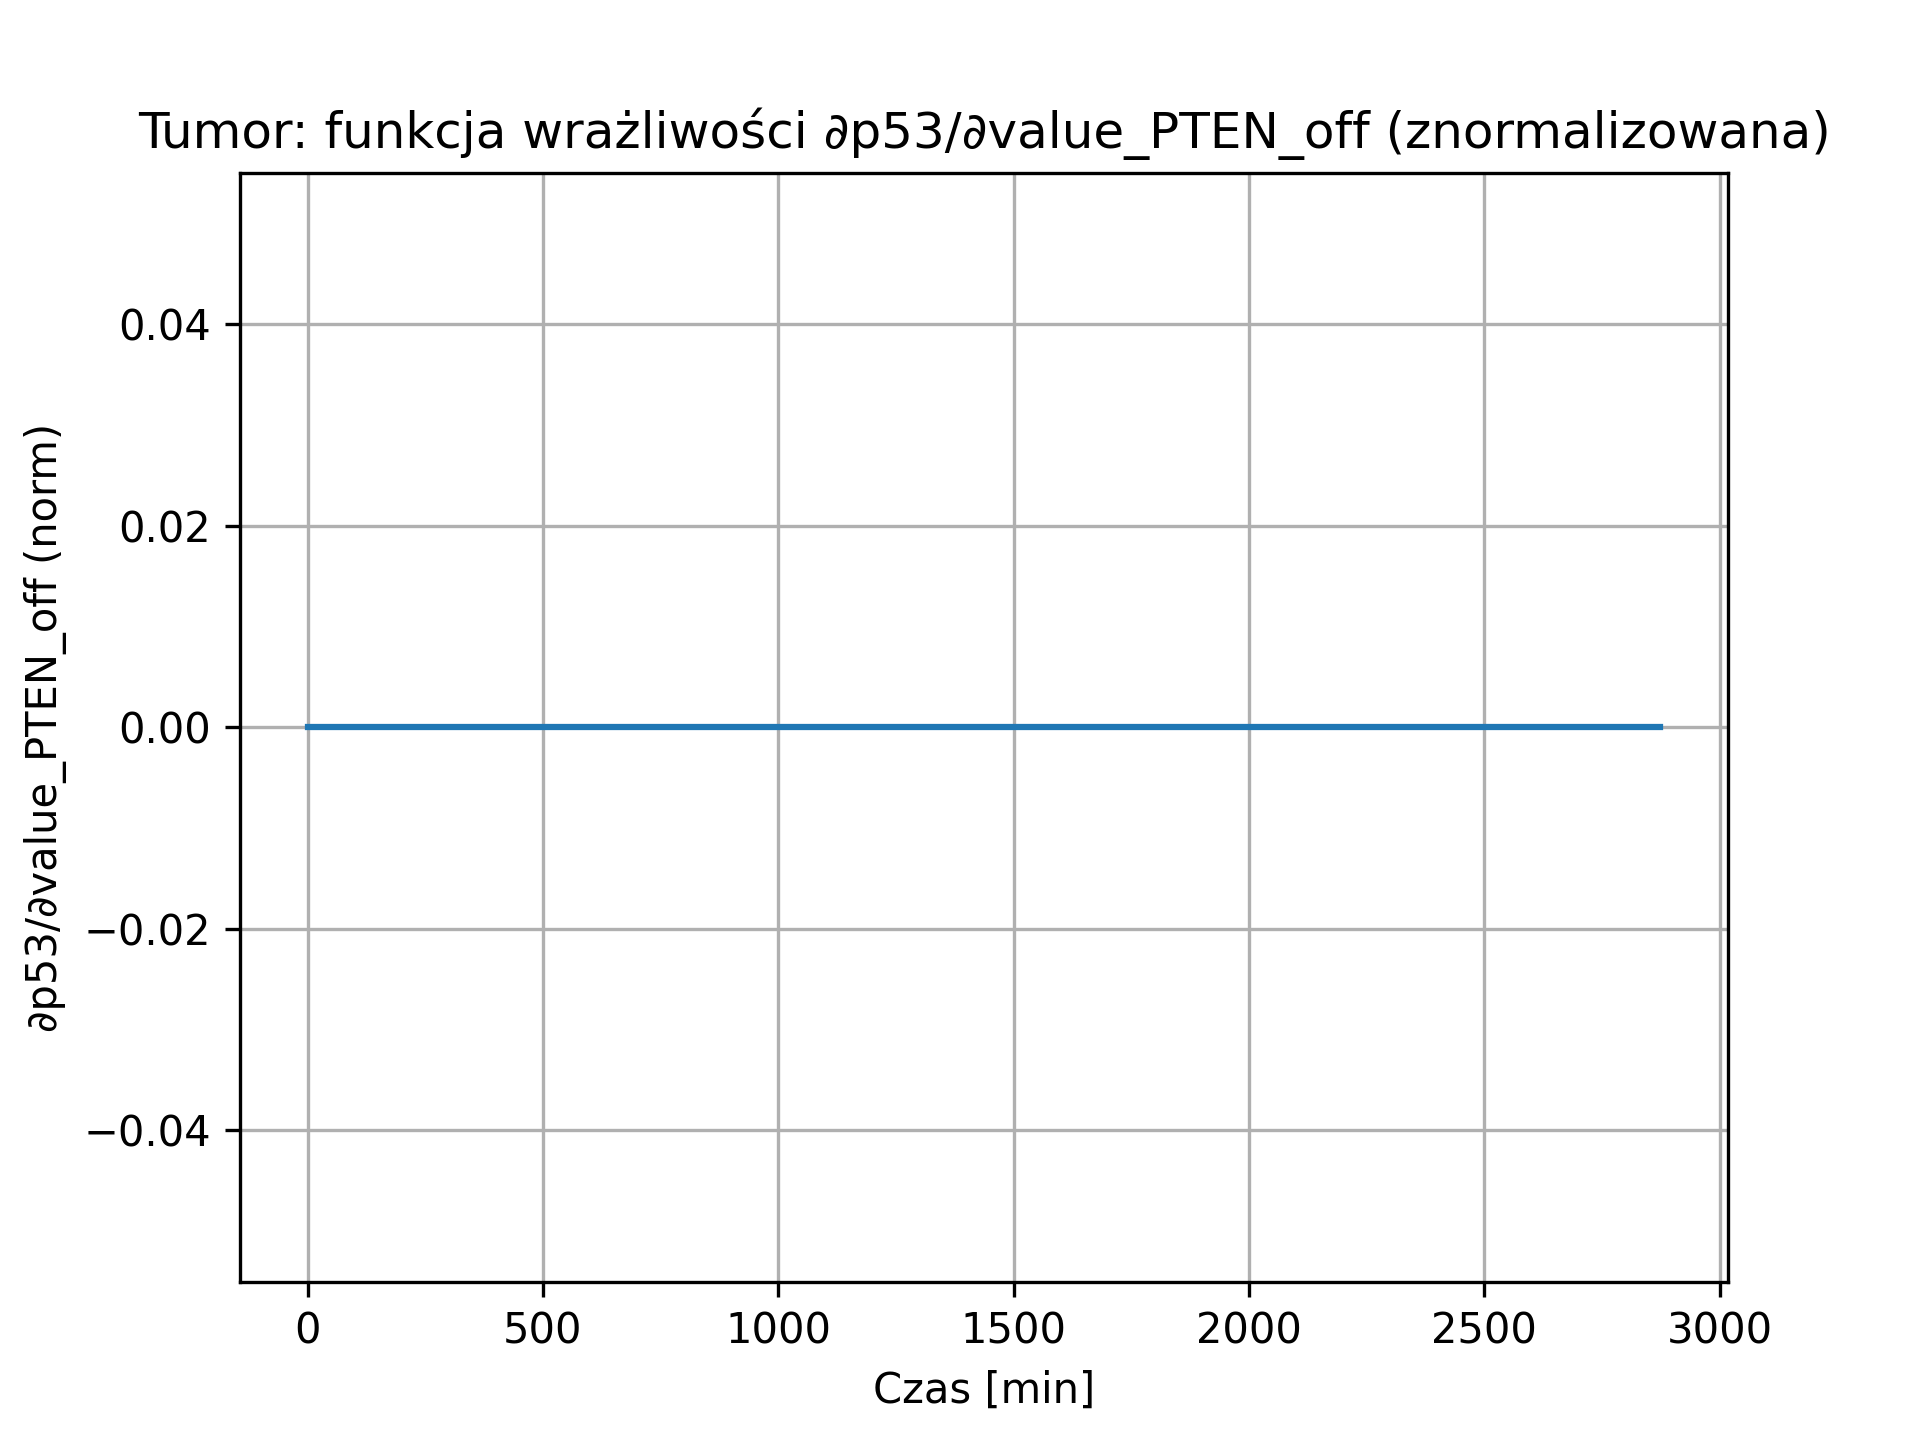
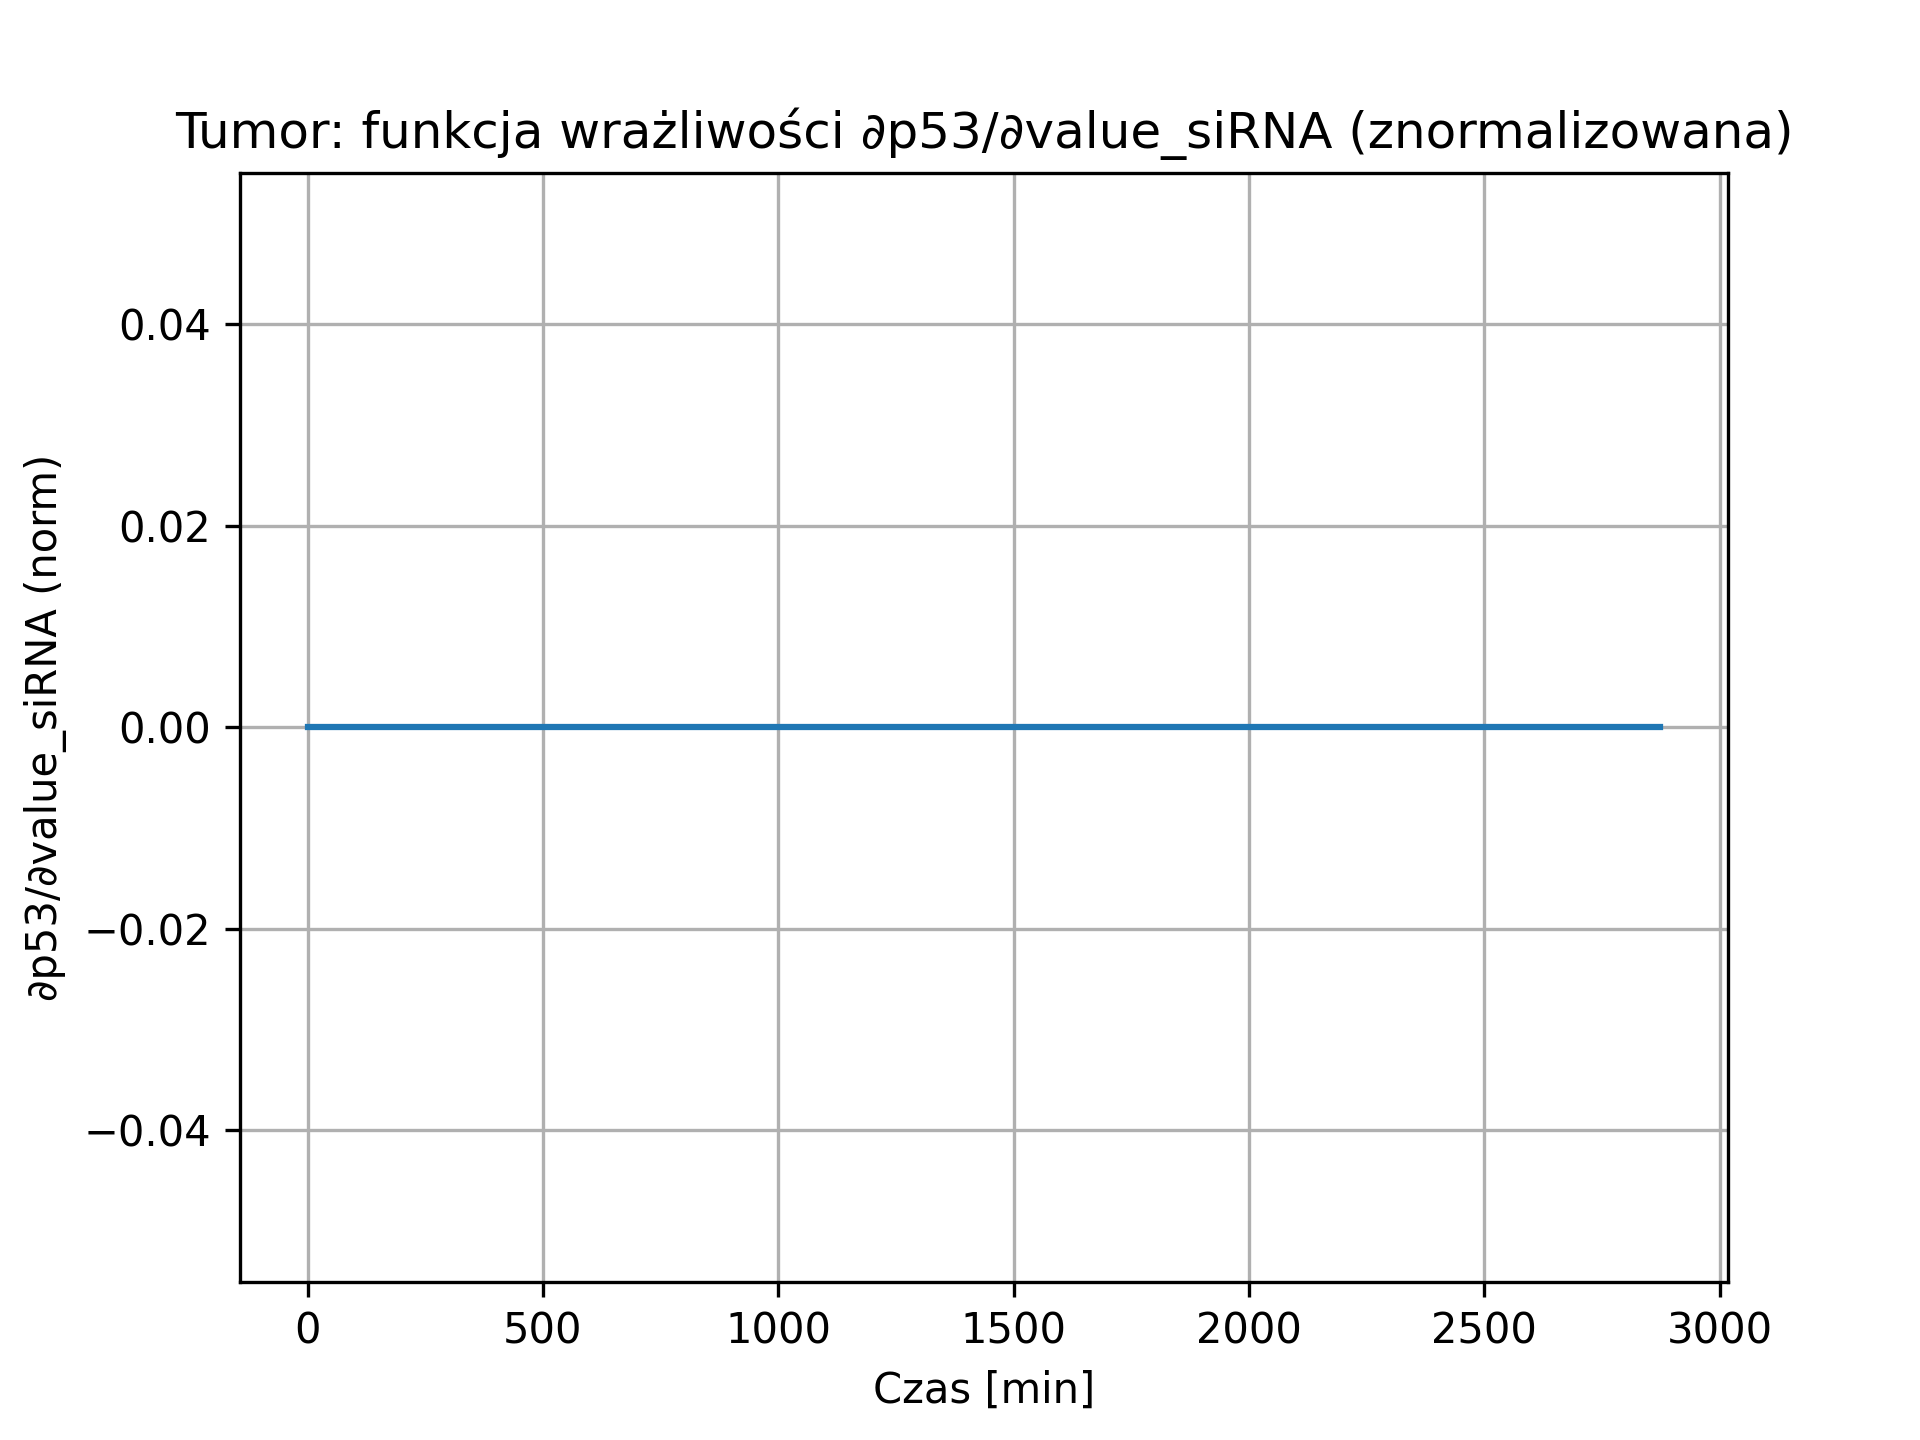
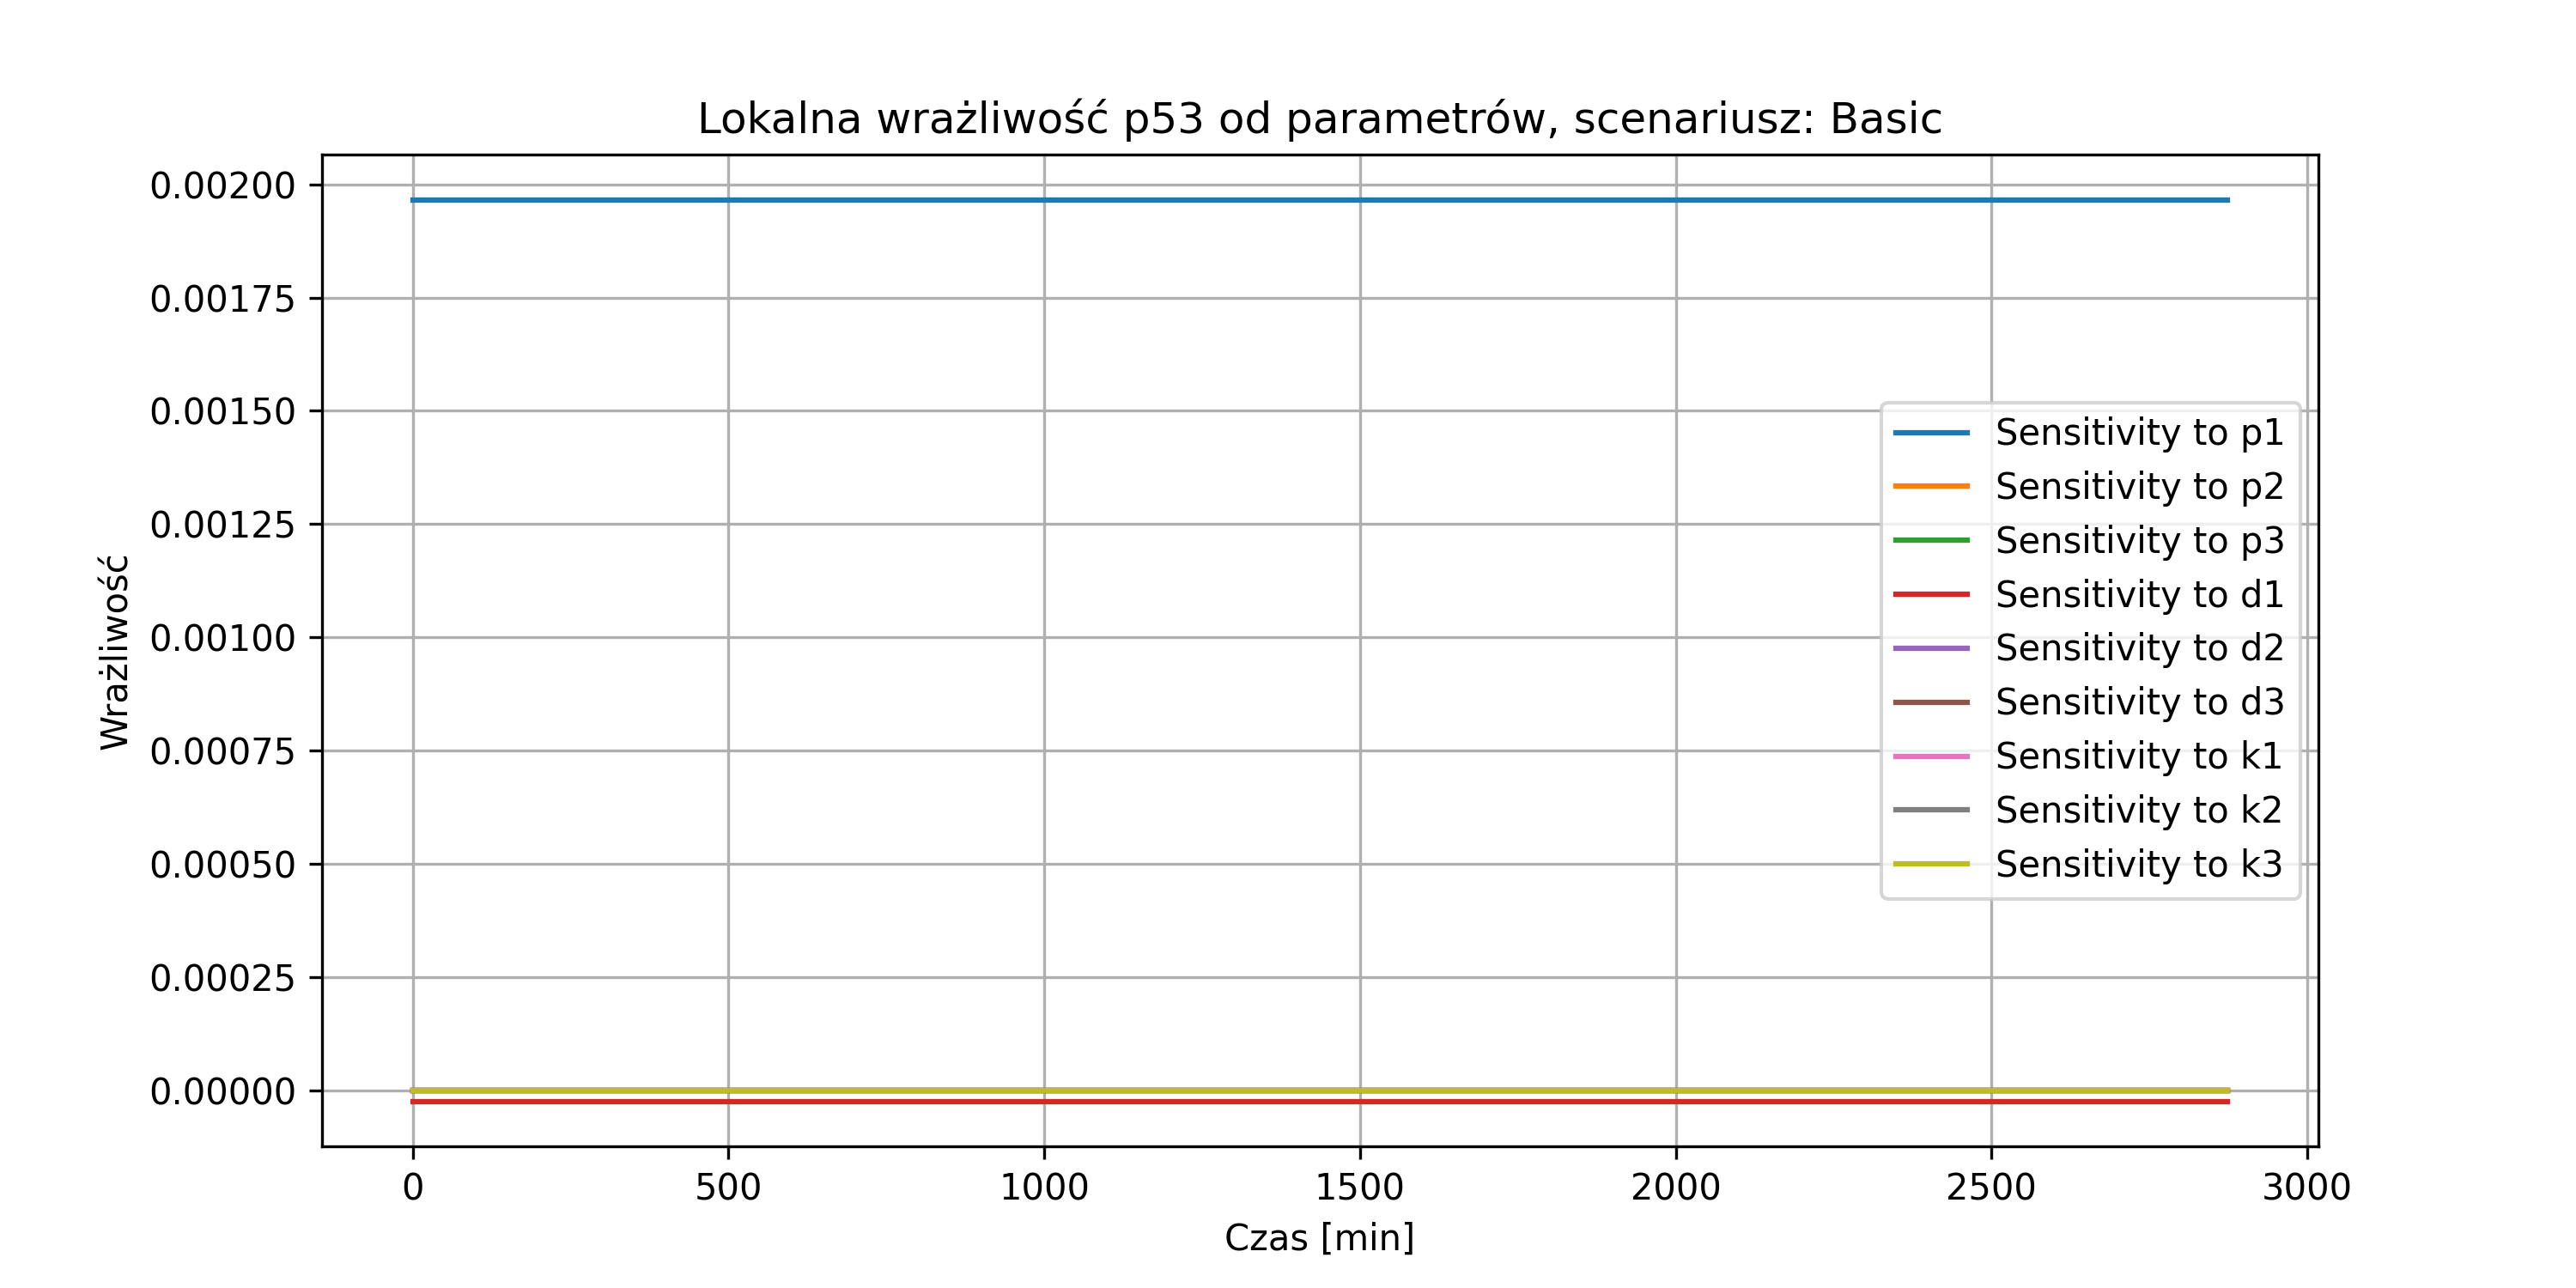
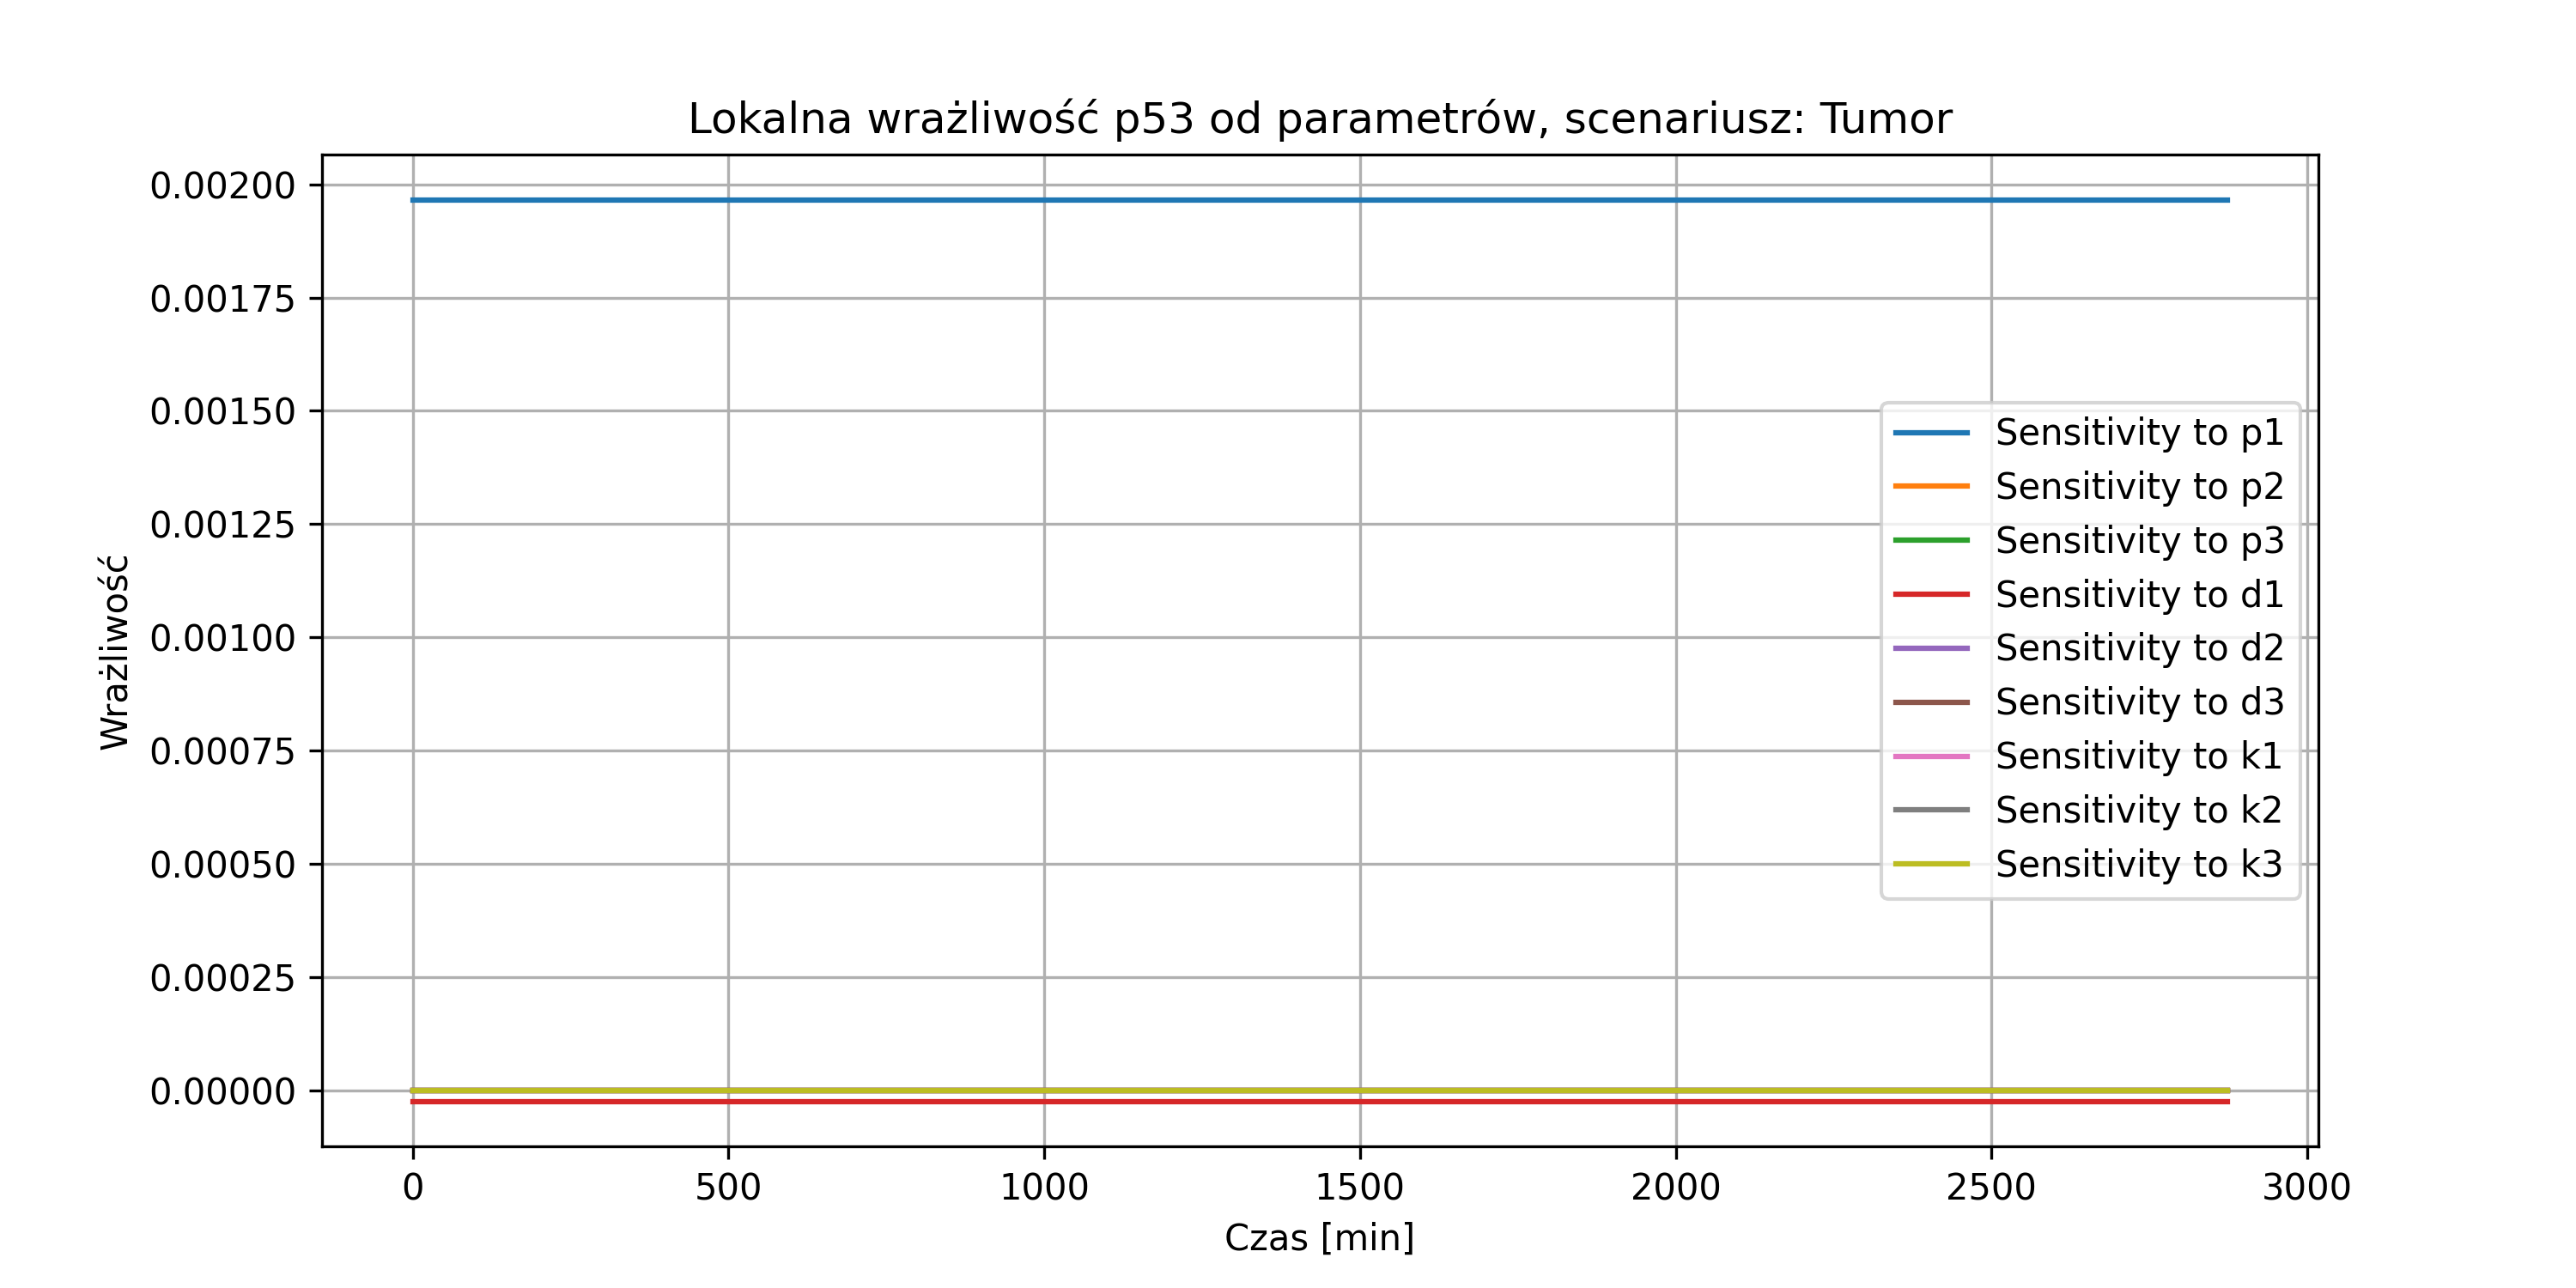

## Ranking
Ranking średni\
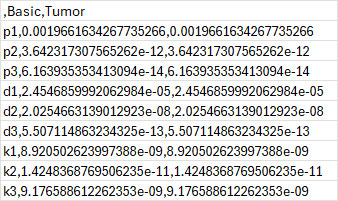 \
Ranking końcowy\
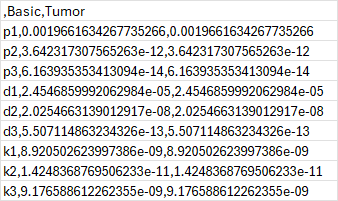

## Wnioski
Analiza lokalna wykazała, że:\
Największy wpływ na poziom białka p53 w obu scenariuszach (Healthy i Tumor) miał parametr p1, odpowiadający za produkcję p53.\
W scenariuszu Healthy najmniejszy wpływ miały parametry o pośrednim znaczeniu biologicznym, np. k2 (stała nasycenia).\
W scenariuszu Tumor najmniejszy wpływ miały parametry niezwiązane bezpośrednio z regulacją p53, np. p3 (produkcja PTEN), ponieważ jego szlak działania był wyłączony.\

Porównanie rankingów:\
Kolejność parametrów w rankingach różniła się pomiędzy scenariuszami, co wskazuje na zmianę dominujących mechanizmów regulacji.\
Różnice w pozycjach rankingowych przekładały się bezpośrednio na zmiany poziomu p53, co zostało potwierdzone przez wykresy przedstawiające wpływ ±20% zmian wartości parametrów.